# Introduction

## Import Libraries

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import datetime 
import matplotlib.pyplot as plt
import seaborn as sns

import scipy

from matplotlib.backends.backend_pdf import PdfPages
import glob
import os

import io
import requests

import sys
import itertools
from matplotlib import rcParams

import wellapplication as wa

import fbprophet
from fbprophet import Prophet
import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error as MAE
from scipy.stats import skew

import folium
from folium.plugins import MarkerCluster

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot,iplot_mpl,plot_mpl
import plotly.graph_objs as go

import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)

import wellapplication as wa

pd.plotting.register_matplotlib_converters()

rcParams['figure.figsize'] = 15, 10
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 14

## Designate Directory Paths

In [143]:
#file_place = "G:/My Drive/WORK/Leland_Harris/intermediate_data/"
file_place = "G:/My Drive/WORK/Leland_Harris/intermediate_data/"

## Define Custom Functions

In [144]:
def crosscorr(datax, datay, lag=0):
    ''' 
    http://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas
    Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    '''
    return datax.corr(datay.shift(lag))

def scatterColor(x0,y,w):
    """Creates scatter plot with points colored by variable.
    All input arrays must have matching lengths

    Arg:
        x0 (array): 
            array of x values
        y (array): 
            array of y values
        w (array): 
            array of scalar values

    Returns:
        slope and intercept of best fit line
    
    """
    import matplotlib as mpl
    import matplotlib.cm as cm
    cmap = plt.cm.get_cmap('RdYlBu')
    norm = mpl.colors.Normalize(vmin=w.min(), vmax=w.max())
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    m.set_array(w)
    sc = plt.scatter(x0, y, label='', color = m.to_rgba(w))

    xa = sm.add_constant(x0)

    est = sm.RLM(y, xa).fit()
    r2 = sm.WLS(y, xa, weights=est.weights).fit().rsquared
    slope = est.params[1]

    x_prime = np.linspace(np.min(x0),np.max(x0),100)[:, np.newaxis]
    x_prime = sm.add_constant(x_prime)
    y_hat = est.predict(x_prime)

    const = est.params[0]
    y2 = [i*slope + const for i in x0]

    plt.xlabel('Barometric Pressure (ft water)')
    plt.ylabel('Transducer Pressure (ft water)')
    lin = linregress(x0,y)
    x1 = np.arange(np.min(x0), np.max(x0),0.1)
    y1 = [i*lin[0]+lin[1] for i in x1]
    y2 = [i*slope+const for i in x1]
    plt.plot(x1,y1,c='g',label='simple linear regression m = {:.2f} b = {:.0f}, r^2 = {:.2f}'.format(lin[0],lin[1],lin[2]**2))
    plt.plot(x1,y2,c='r',label='rlm regression m = {:.2f} b = {:.0f}, r2 = {:.2f}'.format(slope,const,r2))
    plt.legend()
    cbar = plt.colorbar(m)

    cbar.set_label('Julian Date')

    return slope,const

def plotlystuff(datasets, colnames, chrttypes=None, datatitles=None, chrttitle = 'well', colors=None,
                two_yaxes = False, axisdesig= None, axislabels=['Levels','Barometric Pressure']):
    """
    datasets = list of dataframes to plot
    colnames = list of column names for each df in datasets
    chrttypes = list of types of chart to plot for each dataset; options are markers, lines+markers, lines
    datatitles = labels to use for legend
    chrttitle = title for chart; default is well
    colors = list of colors to use for each dataset
    two_yaxes = turn on second y axis to show datasets at different scale (bool); defaults to False
    axisdesig = list of designations for each axis; y1 is left axist and y2 is right axis
    axislabels = labels to use for each y axis
    """
    if chrttypes is None:
        chrttypes = ['lines']*len(datasets)
    
    if datatitles is None:
        datatitles = colnames
    
    if axisdesig is None:
        axisdesig = ['y1']*len(datasets)
        
    if colors is None:
        if len(datasets) <= 5: 
            colors = ['#228B22','#F7DC6F','#FF1493','#663399','#FF0000']
        else:
            colors = []
            for i in range(len(datasets)):
                colors[i] = '#{:02x}{:02x}{:02x}'.format(r(), r(), r())
        
    r = lambda: random.randint(0,255)
    
    modetypes = ['markers','lines+markers','lines']
    datum = {}
    
    for i in range(len(datasets)):
        datum['d' + str(i)] = go.Scatter(
            x=datasets[i].index,
            y=datasets[i][colnames[i]],
            name = datatitles[i],
            line = dict(color = colors[i]),
            mode = chrttypes[i],
            opacity = 0.8,
            yaxis = axisdesig[i])
        
    data = list(datum.values())

    layout = dict(
        title=chrttitle,
        xaxis=dict(
            rangeslider=dict(
                visible = True
            ),
            type='date',
            tickformat='%Y-%m-%d %H:%M'
        ),
        yaxis=dict(title=axislabels[0],
                   titlefont=dict(color='#1f77b4'),
                   tickfont=dict(color='#1f77b4')),
    )
    
    
    if two_yaxes:
        layout['yaxis2'] = dict(title=axislabels[1], titlefont=dict(color='#ff7f0e'),
                    tickfont=dict(color='#ff7f0e'),
                    anchor='x',
                    overlaying='y',
                    side='right',
                    position=0.15)

    fig = dict(data=data, layout=layout)
    iplot(fig, filename = 'well')
    return 

## Import Data

In [6]:
trout_creek = "https://waterdata.usgs.gov/nwis/inventory?agency_code=USGS&site_no=10172870"
flow_data = wa.nwis('dv',[10172870],'sites')
trout = flow_data.data
trt = trout.rename(columns={'value':'trout'})['trout'].to_frame().resample('1D').mean().interpolate(method='time')


connection successful


In [31]:
trout15url = "https://nwis.waterdata.usgs.gov/usa/nwis/uv/?cb_00060=on&cb_00065=on&format=rdb&site_no=10172870&period=&begin_date=2009-01-01&end_date=2019-12-18"
skipper = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,31]
trout15 = pd.read_csv(io.StringIO(requests.get(trout15url).text),index_col='datetime', 
                      parse_dates=['datetime'], skiprows=skipper,sep='\t')

trout15 = trout15.rename(columns={'144419_00060':'Q_cfs',
                        '144419_00060_cd':'Q_qual',
                        '144420_00065':'Gage_ft','144420_00065_cd':'Gage_qual'})
trout_hr = trout15.groupby(pd.Grouper(freq='1H')).mean().interpolate(method='time')

In [7]:
sntlrpt = "https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customMultiTimeSeriesGroupByStationReport,metric/daily/start_of_period/1147:NV:SNTL%7C1247:UT:SNTL%7Cid=%22%22%7Cname/POR_BEGIN,POR_END/stationId,name,PREC::value,PRCP::value,PRCPSA::value,SNWD::value,WTEQ::value?fitToScreen=false"
sntl = pd.read_csv(io.StringIO(requests.get(sntlrpt).text),skiprows=56,index_col='Date')

In [8]:
site_no = 393345113503201

nearmx = f"https://nwis.waterdata.usgs.gov/usa/nwis/gwlevels/?site_no={site_no}"
gwlev = wa.nwis('gwlevels',[site_no],'sites')
gwlevdata = gwlev.data
gwlevdata['gwelev'] = 4960.00 - gwlevdata['value']

connection successful


In [9]:
ugs_clim_raw_dly = pd.read_pickle(file_place + "ugs_clim_dly.pickle")
climate_data = pd.read_pickle(file_place+'climate_data.pickle')
wls = pd.read_pickle(file_place+"raw_hydrograph_data.pickle")
st_mt_df = pd.read_pickle(file_place+'climate_station_metadata1.pickle')
wls_piv = pd.read_pickle(file_place+"pivotedwells.pickle")
prismloc = pd.read_pickle(file_place+'prism_local_SG25.pickle')

ugs_clim_raw = pd.read_pickle(file_place + "ugs_clim.pickle")

In [11]:
st_mt_df.to_clipboard()

https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html

# Subset Datasets

In [36]:
prismloc['cdm_ppt'] = prismloc['PRISM_ppt _mm'].apply(lambda x: x- prismloc['PRISM_ppt _mm'].mean(),1).cumsum()
climate_data['cdm_ppt'] = climate_data['PRISM_ppt _mm'].apply(lambda x: x- climate_data['PRISM_ppt _mm'].mean(),1).cumsum()
climate_data['partoun_ppt_ft'] = climate_data['partoun_ppt']*0.00328084
climate_data['partoun_et_ft'] = climate_data['partoun_et']*0.00328084

In [37]:
df = pd.concat([wls_piv,climate_data,ugs_clim_raw_dly])

In [38]:
climate_data = pd.read_pickle(file_place+'climate_data.pickle')
wls_piv = pd.read_pickle(file_place+"pivotedwells.pickle")

climate_data['cdm_ppt'] = climate_data['PRISM_ppt _mm'].apply(lambda x: x- climate_data['PRISM_ppt _mm'].mean(),1).cumsum()
climate_data['partoun_ppt_ft'] = climate_data['partoun_ppt']*0.00328084
climate_data['partoun_et_ft'] = climate_data['partoun_et']*0.00328084

wellwl = ['1011_wle','1012_wle','1013_wle','1014_wle',
                 '1016_wle','1017_wle','1019_wle','1020_wle','SG25A_wle','SG25B_wle','SG25C_wle','SG25D_wle']
climsub = climate_data[['eskdale_ppt', 'eskdale_snowdpt','cdm_ppt',
       'eskdale_maxtemp', 'eskdale_et','Takka_snowdepth_cm',
       'partoun_ppt_ft', 'partoun_snowdpt','Takka-20in_soiltemp_C',
       'partoun_maxtemp', 'partoun_et_ft', 'Wheeler_snowdepth_cm',
       'Wheeler-20in_soiltemp_C', 'PRISM_ppt _mm',
       'PRISM_meantemp_deg_C',
       'PRISM_vpdmax _hpa']]


justwl = wls_piv[wellwl]
justwl = justwl.dropna(how='all')

wlClim = pd.concat([climsub,justwl],axis=1)
wlClim = wlClim.dropna(subset=wellwl, how='all').dropna(subset=climsub.columns, how='all')

# Cross Correlation

## Long-Term Water Levels

connection successful


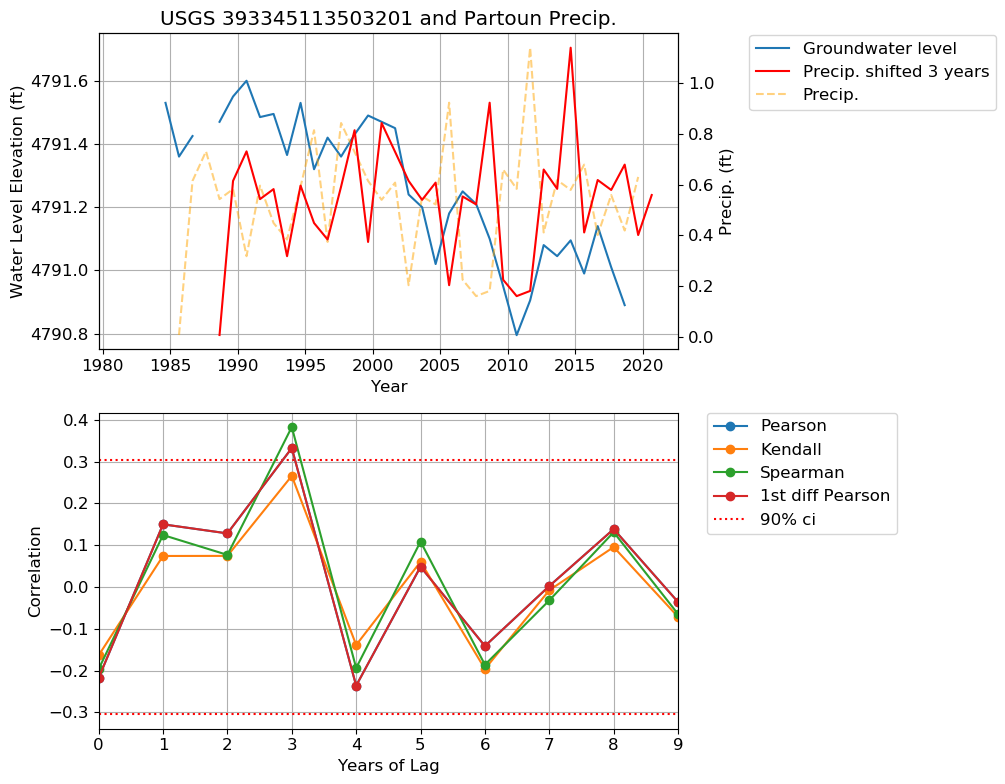

In [78]:
import matplotlib
matplotlib.rc_file_defaults()
rcParams['figure.figsize'] = 10.5, 8
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 12

site_no = 393345113503201

nearmx = f"https://nwis.waterdata.usgs.gov/usa/nwis/gwlevels/?site_no={site_no}"
gwlev = wa.nwis('gwlevels',[site_no],'sites')
gwlevdata = gwlev.data
gwlevdata['gwelev'] = 4960.00 - gwlevdata['value']
climate_data = pd.read_pickle(file_place+'climate_data.pickle')

climate_data['partoun_ppt_ft'] = climate_data['partoun_ppt']*0.00328084

fig, ax = plt.subplots(2,1,sharex=False)

x1 = climate_data.groupby(pd.Grouper(freq='12M',loffset='9M')).sum().index[:-1]#.rolling(3,center=True).mean().index
y1 = climate_data.groupby(pd.Grouper(freq='12M',loffset='9M')).sum()['partoun_ppt_ft'][:-1]#.rolling(3,center=True).mean()['partoun_ppt']

x2 = climate_data.groupby(pd.Grouper(freq='12M',loffset='9M')).sum().shift(3).index#.rolling(3,center=True).mean().index
y2 = climate_data.groupby(pd.Grouper(freq='12M',loffset='9M')).sum()['partoun_ppt_ft'].shift(3)#.rolling(3,center=True).mean()['partoun_ppt']

x = gwlevdata.groupby(pd.Grouper(freq='12M',loffset='9M')).median().index[:-1]#rolling(3).mean().index
y = gwlevdata.groupby(pd.Grouper(freq='12M',loffset='9M')).median()['gwelev'][:-1]#.rolling(3).mean()
ax[0].set_title('USGS 393345113503201 and Partoun Precip.')
lns1 = ax[0].plot(x,y,label='Groundwater level')
ax[0].set_ylabel('Water Level Elevation (ft)')
ax[0].set_ylim(4790.75,4791.75)
ax[0].grid(True)
ax2 = ax[0].twinx()
lns2 = ax2.plot(x2,y2,color='red',zorder=2,label='Precip. shifted 3 years')
lns3 = ax2.plot(x1,y1,'--',color='orange',alpha=0.5,zorder=0,label='Precip.')
ax2.set_ylabel('Precip. (ft)')
ax[0].legend(bbox_to_anchor=(1.12, 1), loc='upper left', borderaxespad=0.)
ax[0].set_xlabel('Year')

# added these three lines
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, bbox_to_anchor=(1.12, 1), loc='upper left', borderaxespad=0.1)

crr1 = []
crr2 = []
crr3 = []
crr4 = []

for i in range(0, 10):
    crr1.append(y[7:].diff().corr(y1[3:-1].diff().shift(i),min_periods=3,method='pearson'))
    crr2.append(y[7:].diff().corr(y1[3:-1].diff().shift(i),min_periods=3,method='kendall'))
    crr3.append(y[7:].diff().corr(y1[3:-1].diff().shift(i),min_periods=3,method='spearman'))
    crr4.append(y[7:].diff().corr(y1[3:-1].diff().shift(i),min_periods=3))

ax[1].plot(range(0,10),crr1,'-o',label='Pearson')
ax[1].plot(range(0,10),crr2,'-o',label='Kendall')
ax[1].plot(range(0,10),crr3,'-o',label='Spearman')
ax[1].plot(range(0,10),crr4,'-o',label='1st diff Pearson')
#cr = scipy.signal.correlate()
#ax[1].xcorr(y[7:].diff()[1:],y1[3:-1].diff()[1:],usevlines=True, normed=True,maxlags=9)
sl = 1.67 / np.sqrt(len(y[7:].diff()[1:]))
ax[1].hlines(sl,0,lags,linestyles=':',color='red',label='90% ci')
ax[1].hlines(-sl,0,lags,linestyles=':',color='red')
#ax[1].fill_between(range(lags),list(np.ones(lags) * -sl),list(np.ones(lags) * sl),alpha=0.7)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax[1].set_ylabel('Correlation')
ax[1].set_xlabel('Years of Lag')
ax[1].grid(True)
ax[1].set_xticks(range(0,10))
ax[1].set_xlim(0,9)
plt.tight_layout()

plt.savefig(file_place+'usgs_corr_with_partoun.pdf')
plt.savefig(file_place+'usgs_corr_with_partoun.svg')
plt.savefig(file_place+'usgs_corr_with_partoun.png')

## Local Precip

<Figure size 1080x720 with 0 Axes>

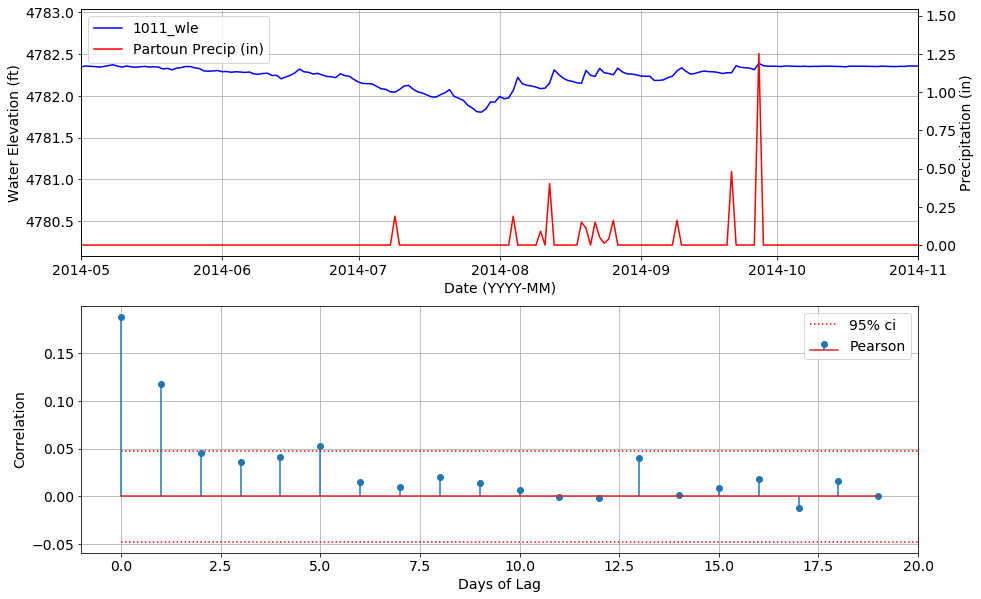

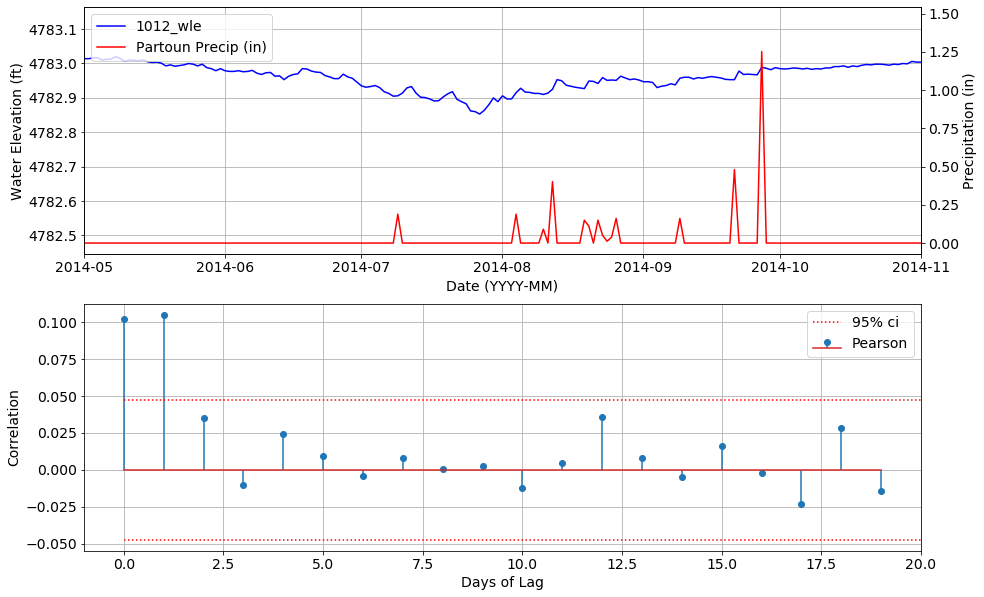

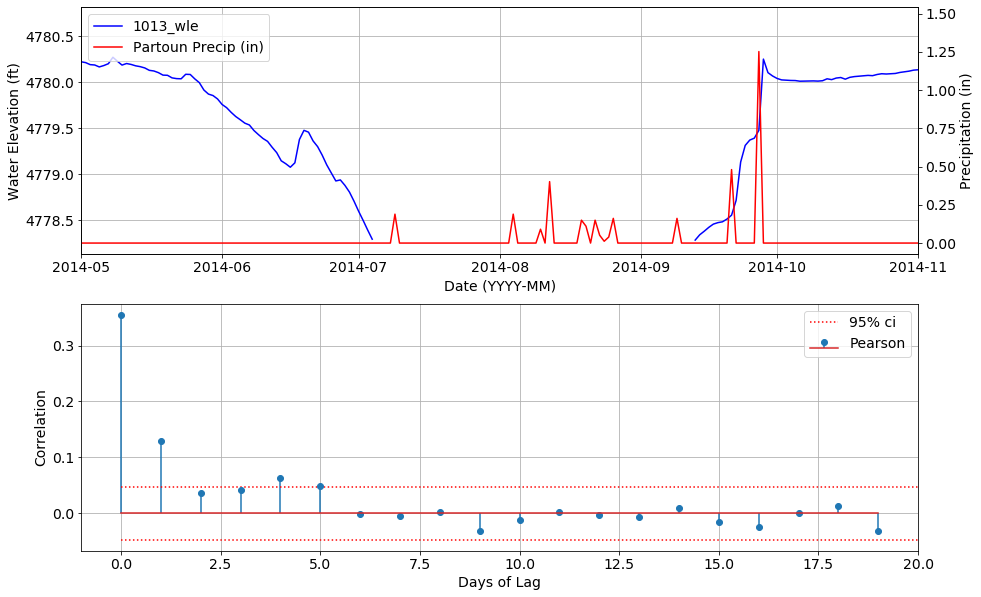

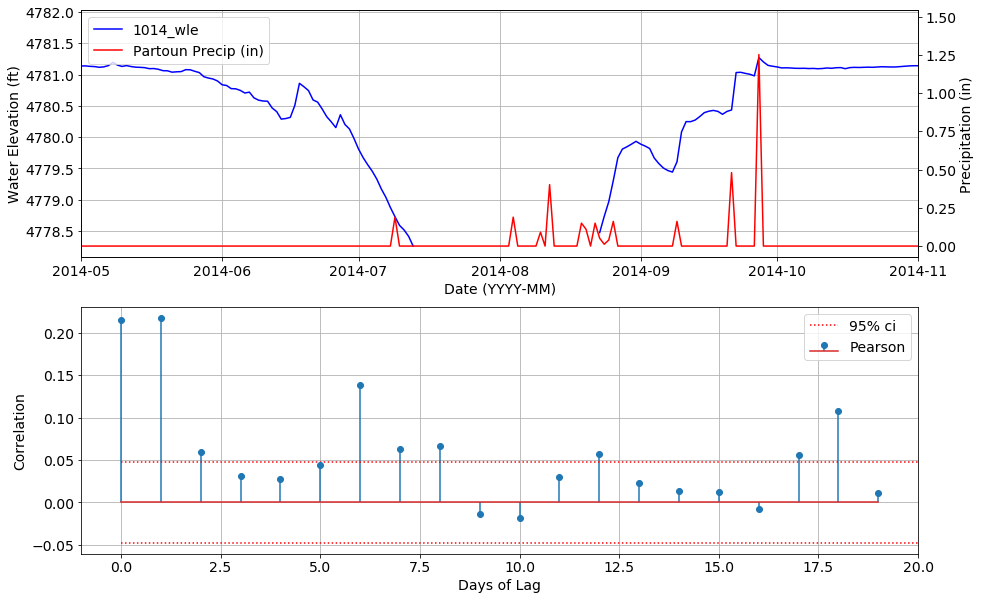

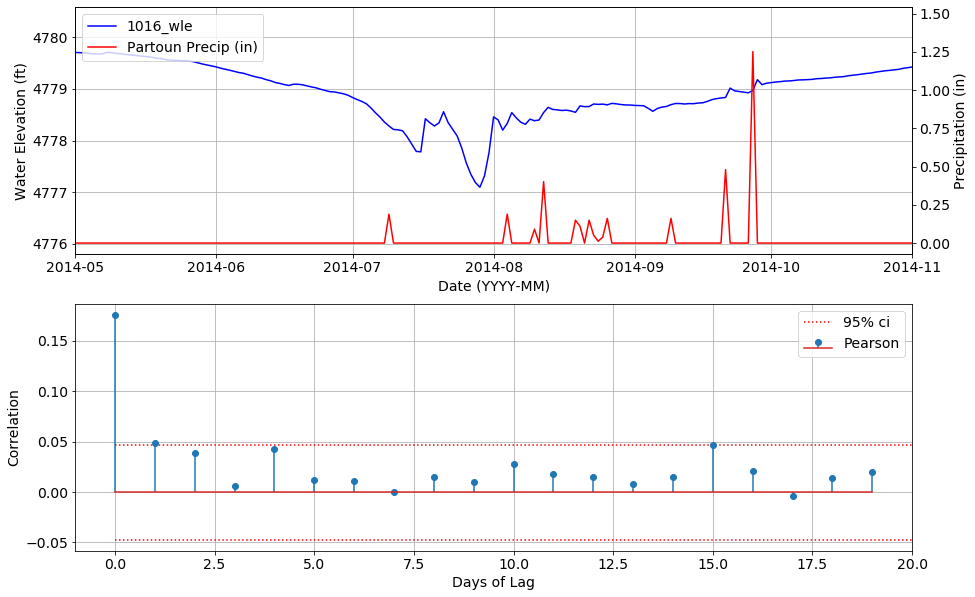

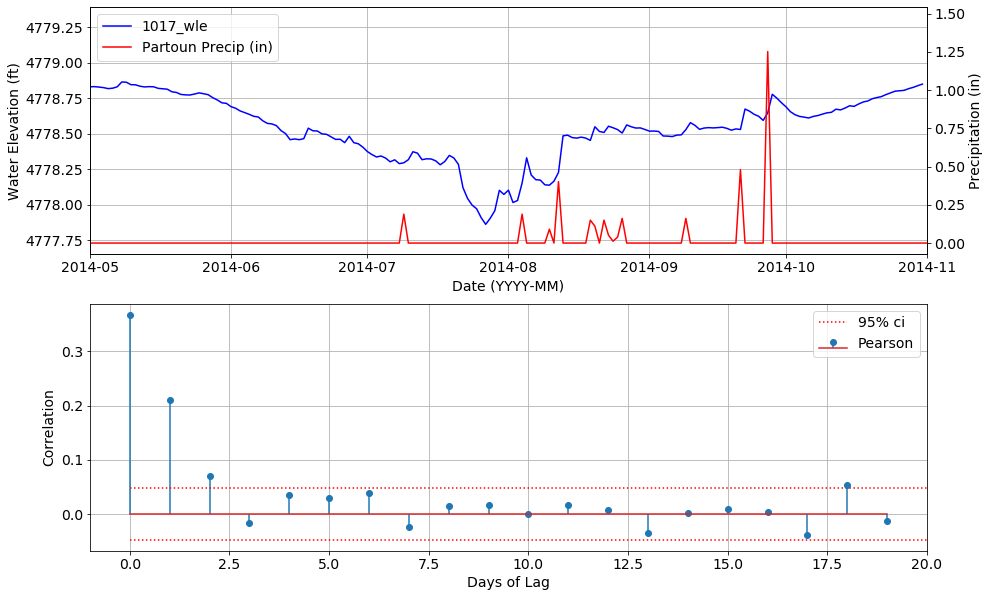

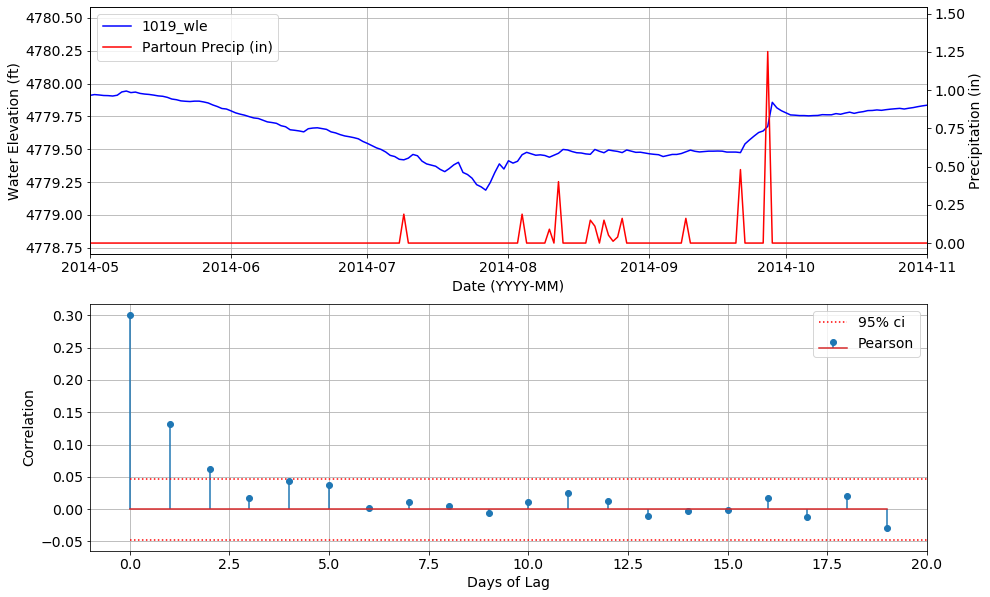

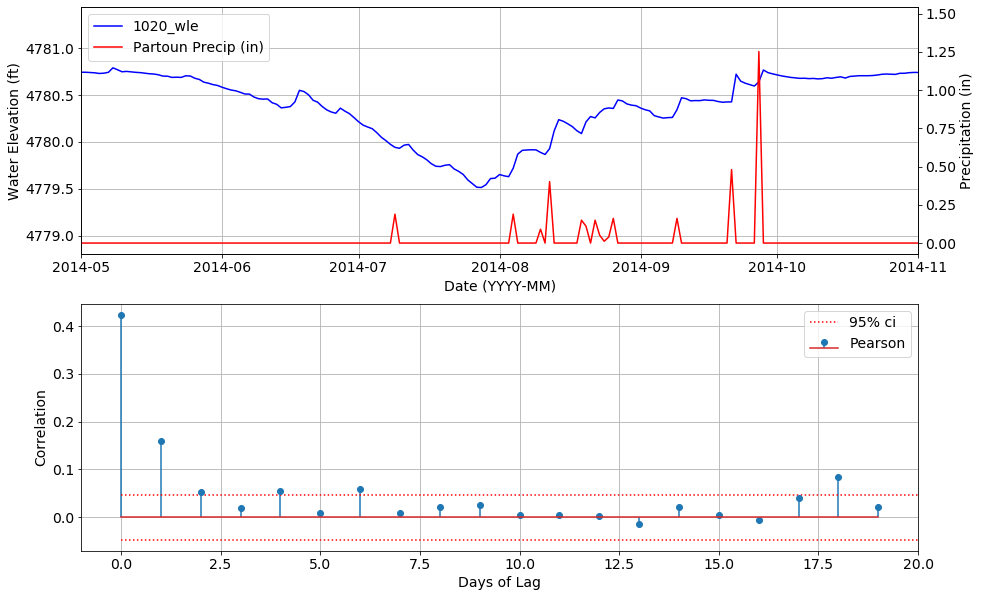

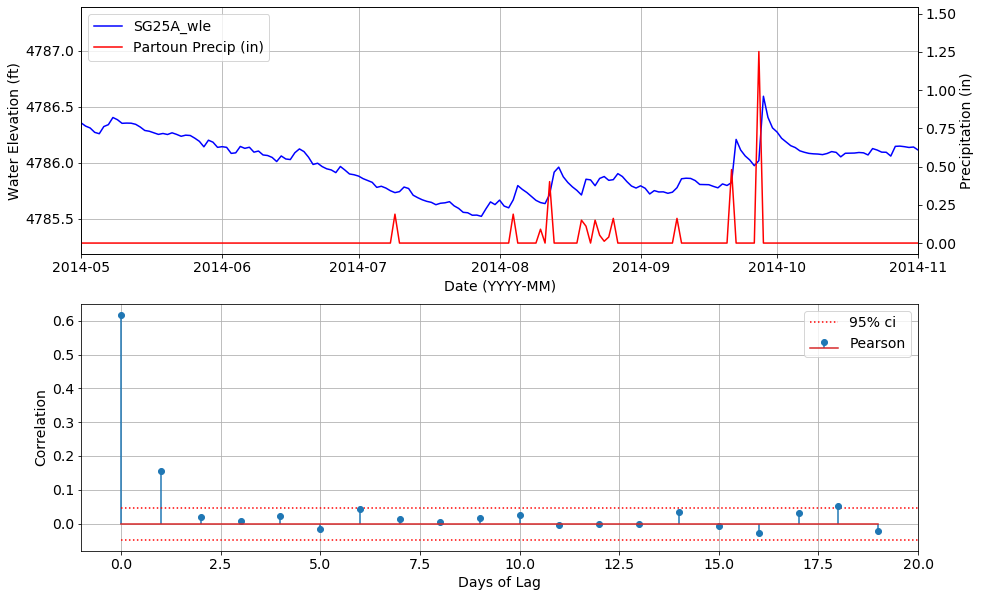

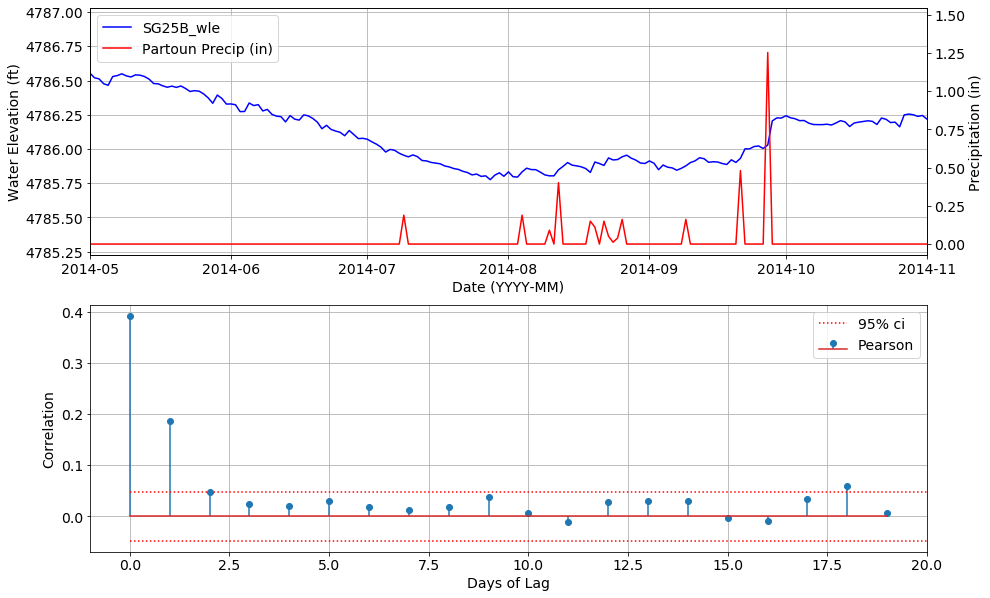

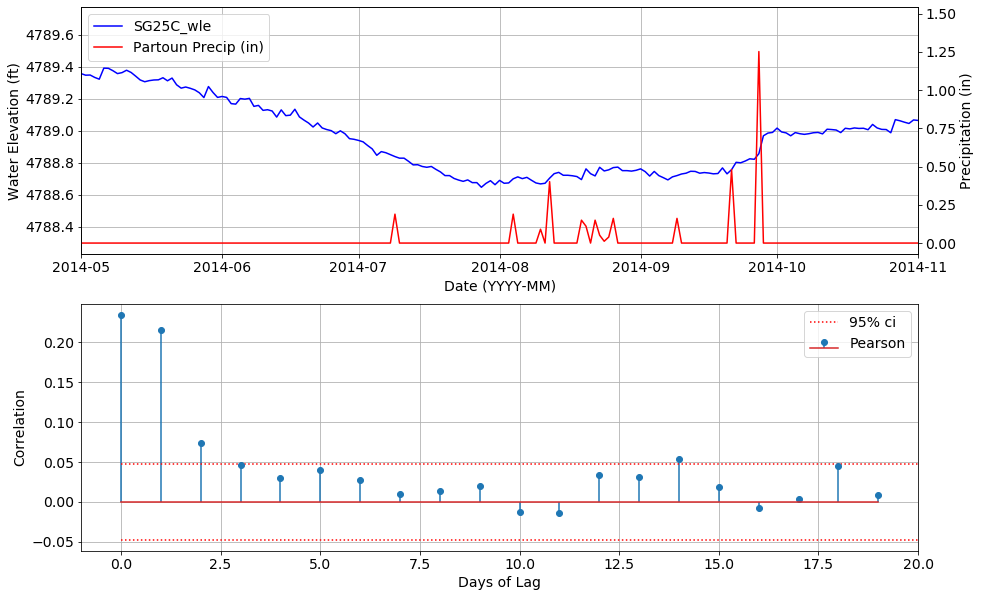

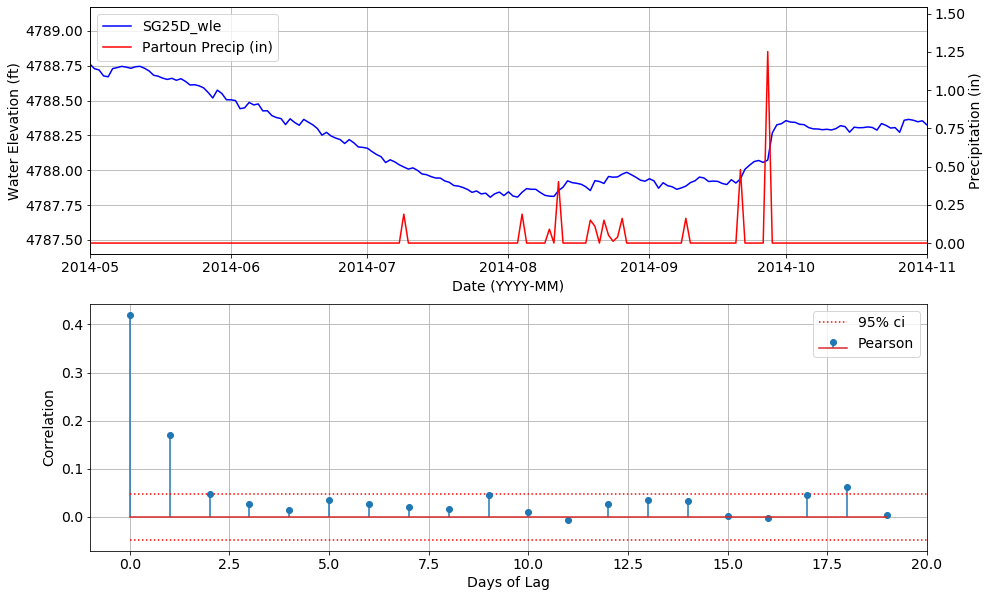

In [141]:

y2 = wlClim['partoun_ppt_ft']*12.0
lags = 20
wlClim['ppt_diff'] = wlClim['partoun_ppt_ft'].diff()

for col in wlClim.columns:
    if 'wle' in col:
        fig, ax = plt.subplots(2,1)

        x1 = wlClim.index
        y1 = wlClim[col]
        
        lns1 = ax[0].plot(x1,y1,color='blue',label=col)
        
        ax[0].set_ylabel('Water Elevation (ft)')
        ax2 = ax[0].twinx()
        ax2.set_ylabel('Precipitation (in)')
        lns2 = ax2.plot(x1,y2,color='red',label='Partoun Precip (in)')
        #ax2.plot(x1,y1.diff(),color='green',label=col)
        ax[0].set_xlim(pd.to_datetime('2014-05-01'),pd.to_datetime('2014-11-01'))
        ax[0].grid(True)
        ax[0].set_xlabel('Date (YYYY-MM)')
        lns = lns1+lns2
        labs = [l.get_label() for l in lns]
        ax[0].legend(lns, labs, loc='upper left')
        
        crr = []
        crr1 = []
        low = []
        high = []
        for i in range(0, lags):
            df = wlClim.copy()
            df['y'] = df[col].diff().shift(-1).shift(i)
            #df = df[df['ppt_diff']>0]
            df = df[df.index.month.isin([5,6,7,8,9,10])]
            crr.append(df['partoun_ppt_ft'].corr(df['y'],method='pearson'))
            
        ax[1].stem(crr,label='Pearson',use_line_collection=True)
        #ax[1].xcorr(df['ppt_diff'],df['y'],maxlags=lags,label='xcorr')
        #cr = scipy.signal.correlate(df['ppt_diff'],df['y'],mode='same')
        #dfa = pd.DataFrame({'num':np.arange(len(cr)/-2,len(cr)/2),'corr':cr})
        #ax[1].plot(dfa['num'],dfa['corr'],color='green',label='scipy')
        
        sl = 2 / np.sqrt(len(df)-lags)
        ax[1].hlines(sl,0,lags,linestyles=':',color='red',label='95% ci')
        ax[1].hlines(-sl,0,lags,linestyles=':',color='red')
    ax[1].legend(loc='upper right')
    ax[1].set_ylabel('Correlation')
    ax[1].set_xlabel('Days of Lag')
    ax[1].set_xlim(-1,lags)
    #ax[1].set_xticks(range(0,lags))
    ax[1].grid(True)
    
    
    plt.savefig(file_place+f"precip_{col}_correlat.pdf")
    plt.savefig(file_place+f"precip_{col}_correlat.png")
    plt.savefig(file_place+f"precip_{col}_correlat.svg")

In [479]:
wlClim['Wheeler_snowdepth_ft'] = wlClim['Wheeler_snowdepth_cm']*0.0328084

## Local ET

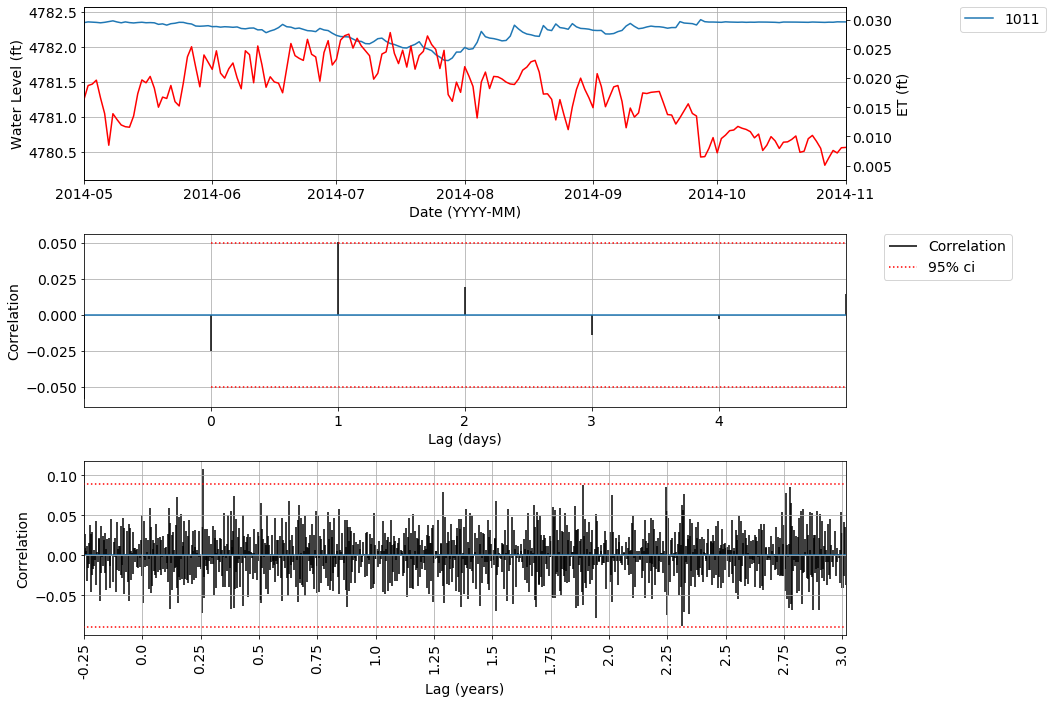

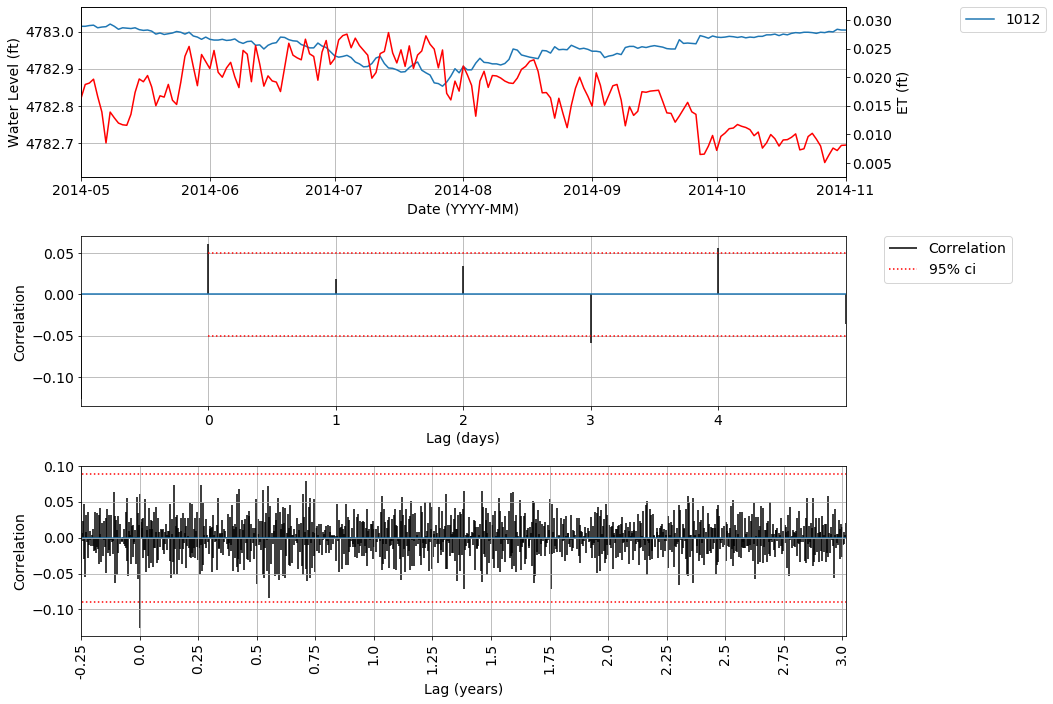

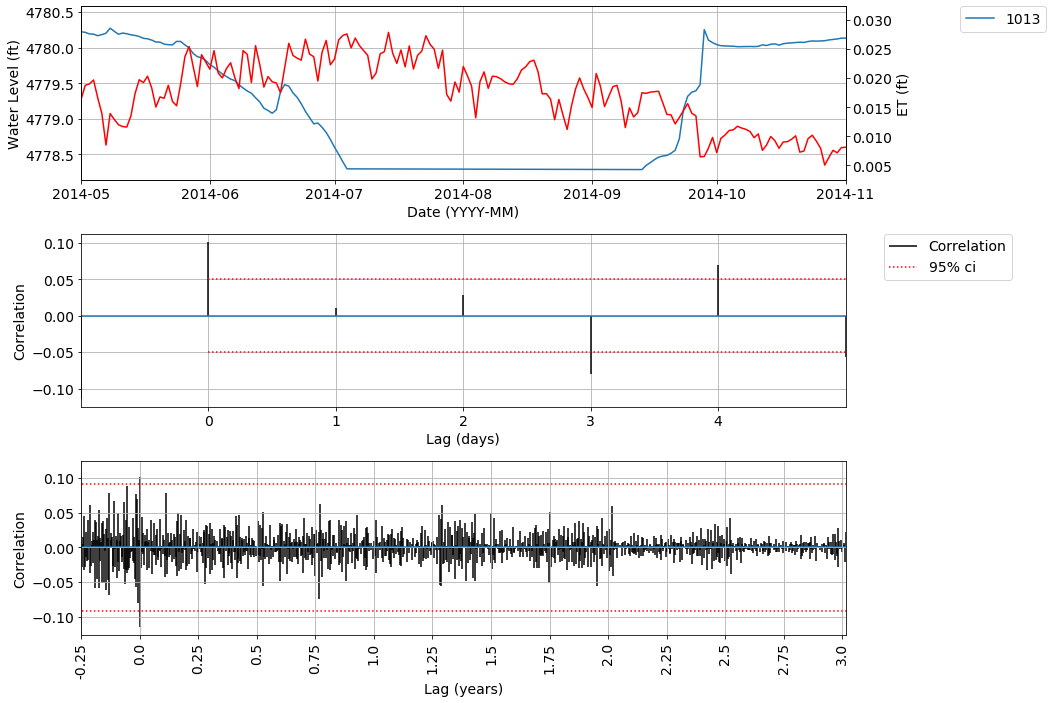

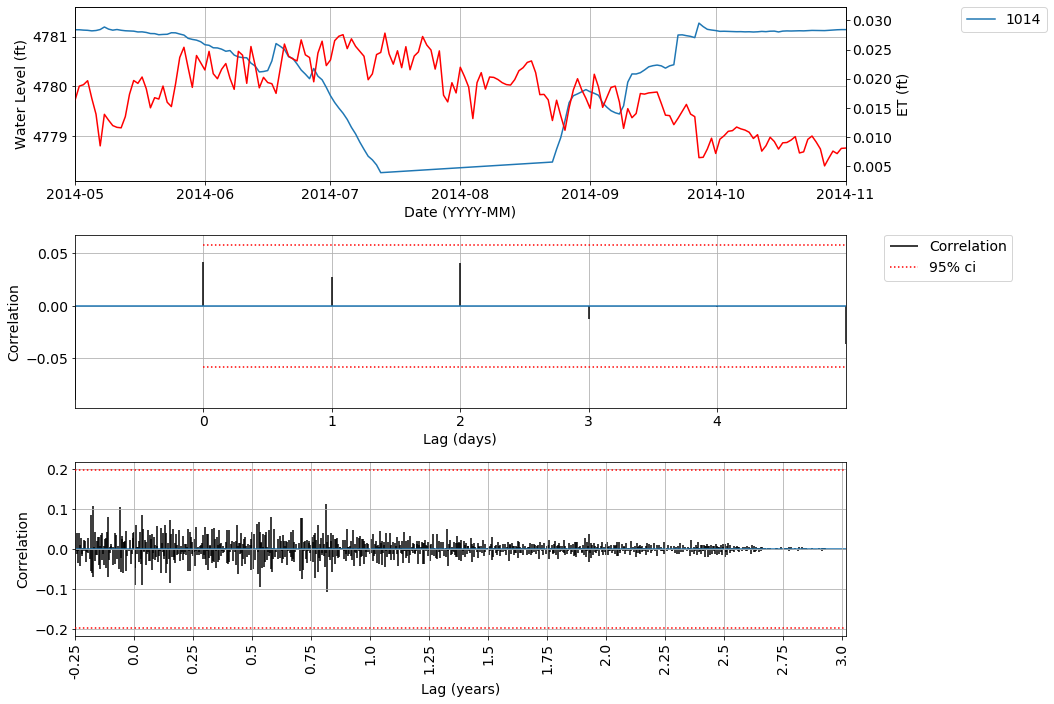

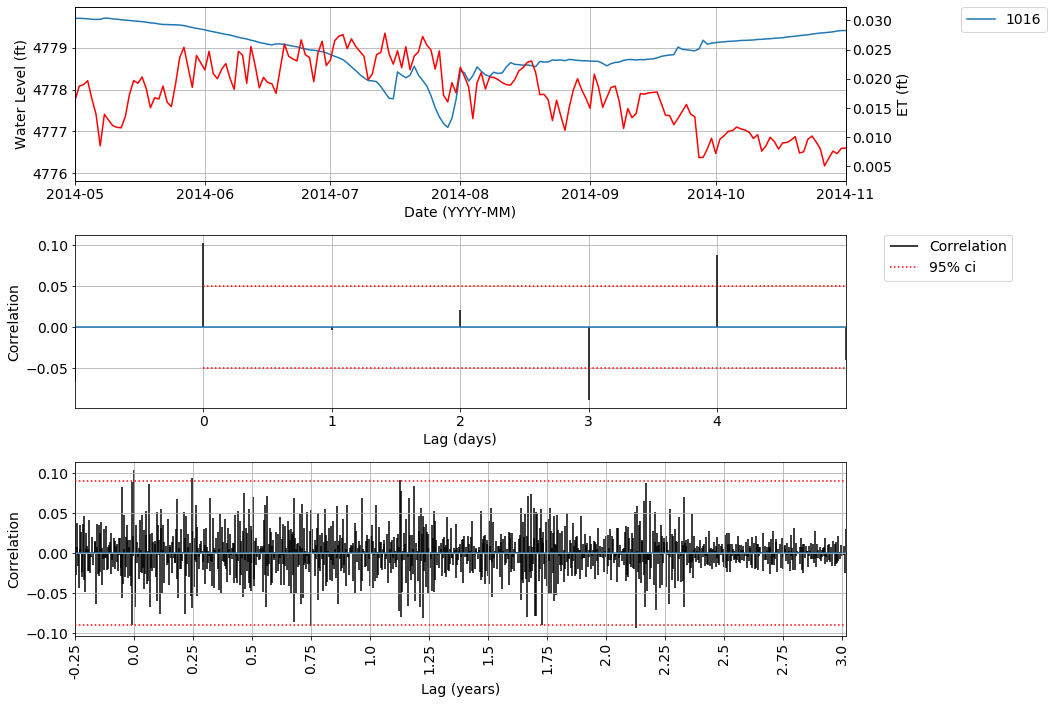

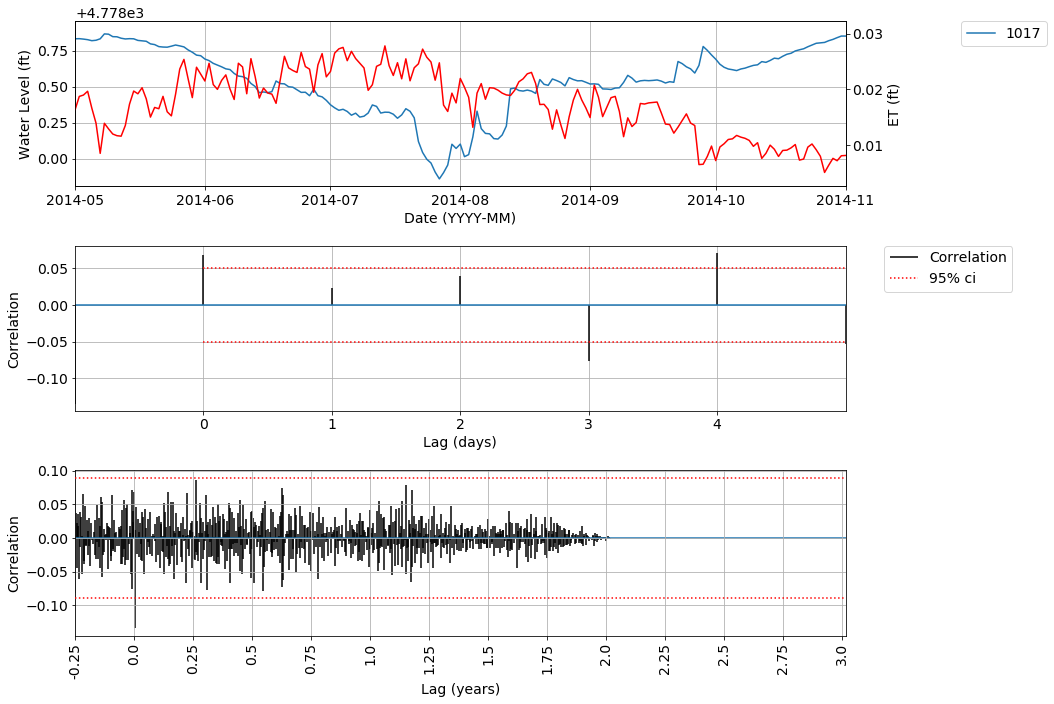

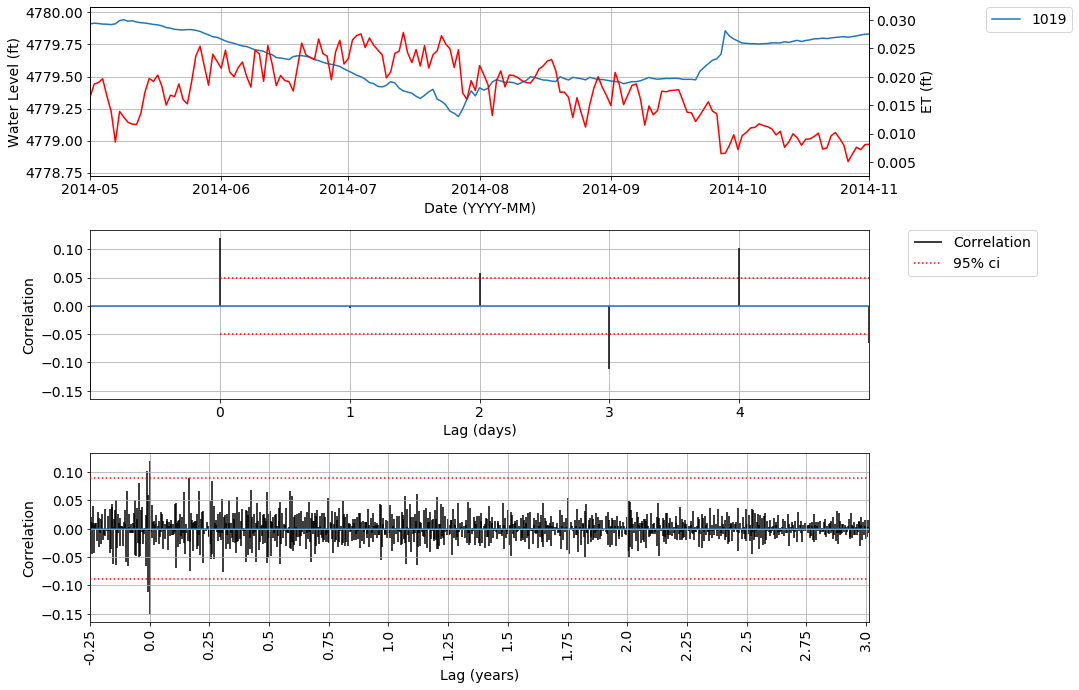

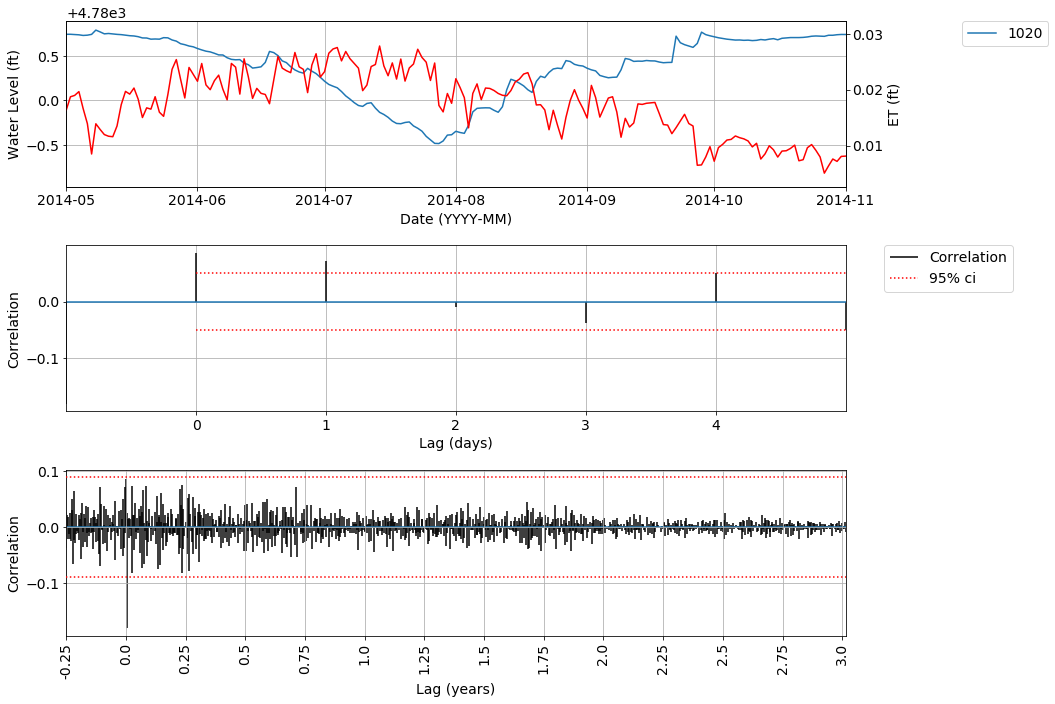

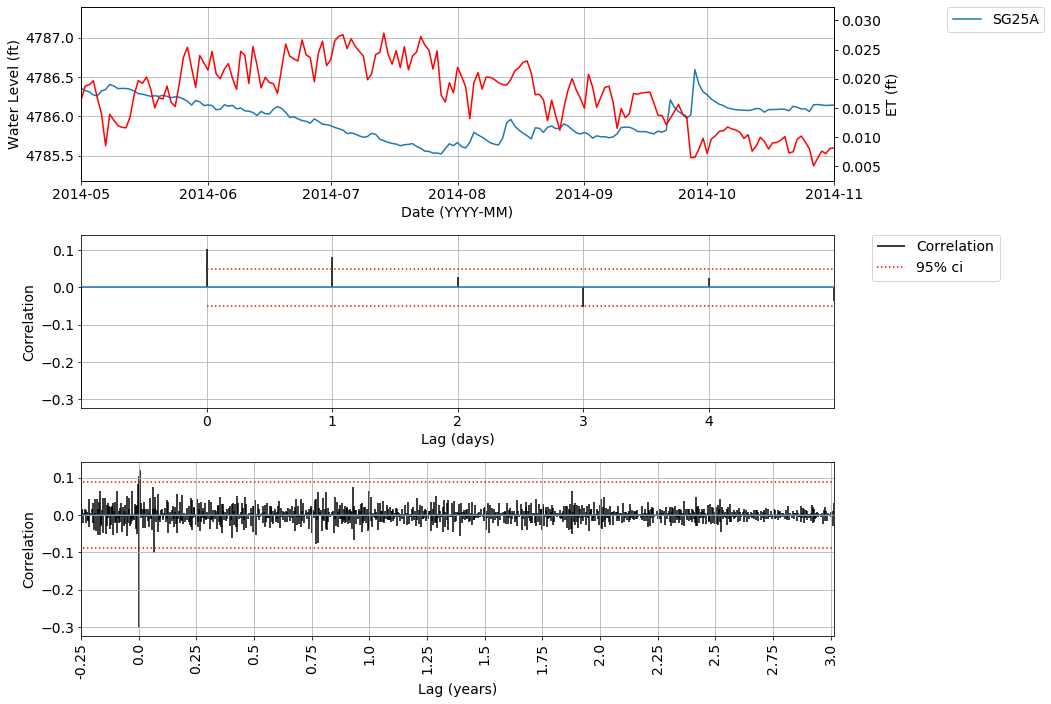

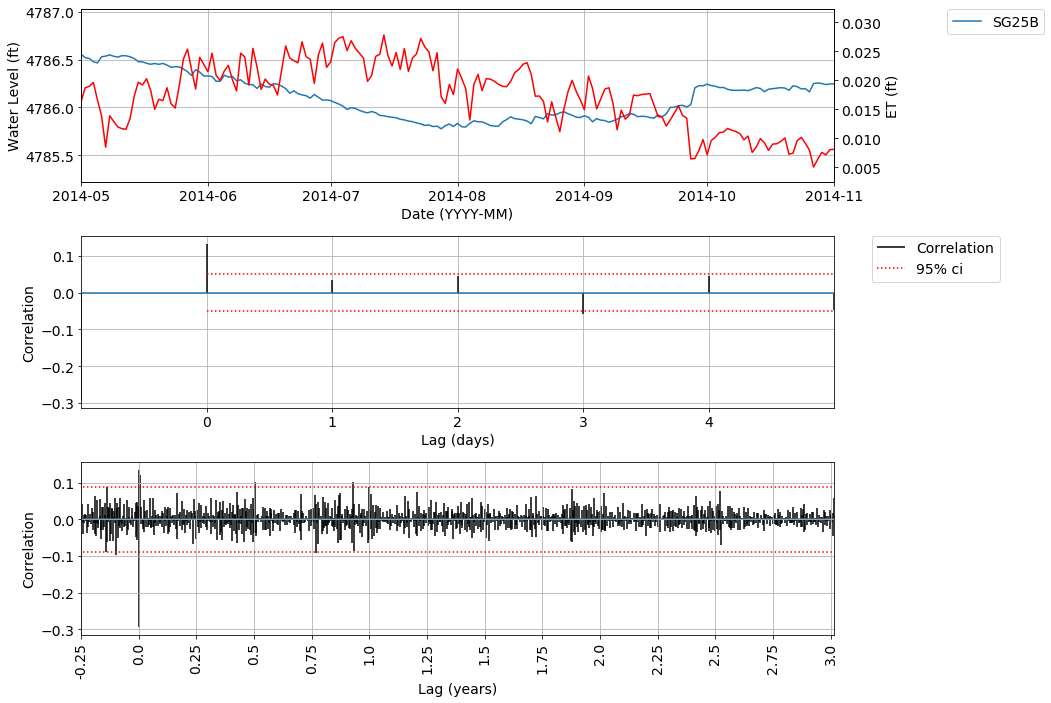

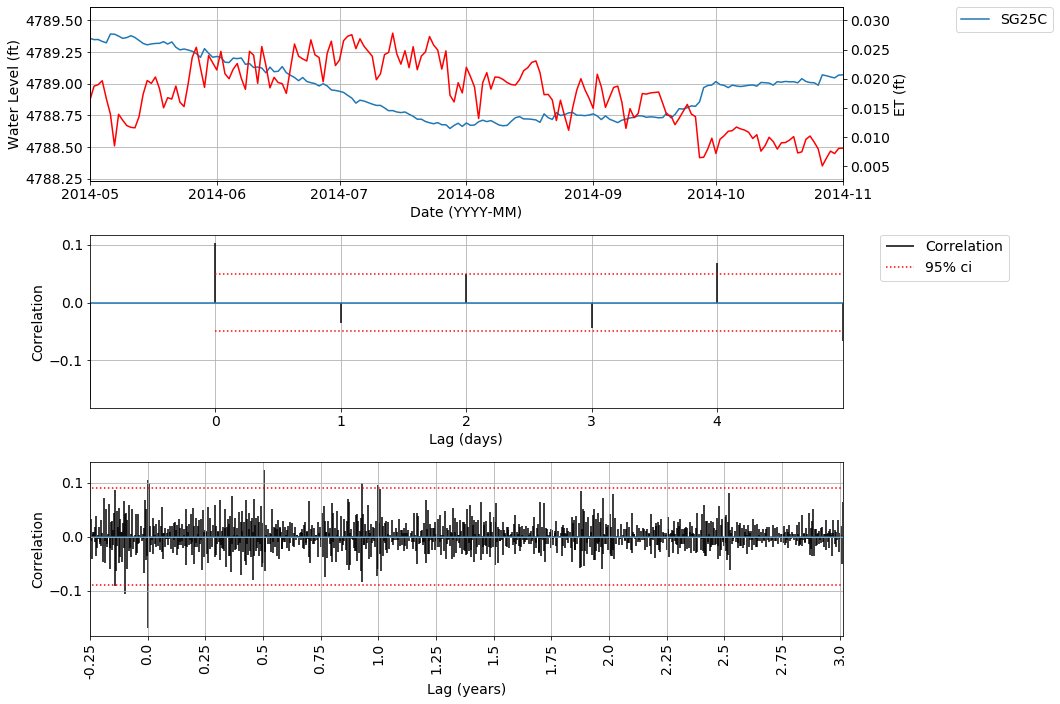

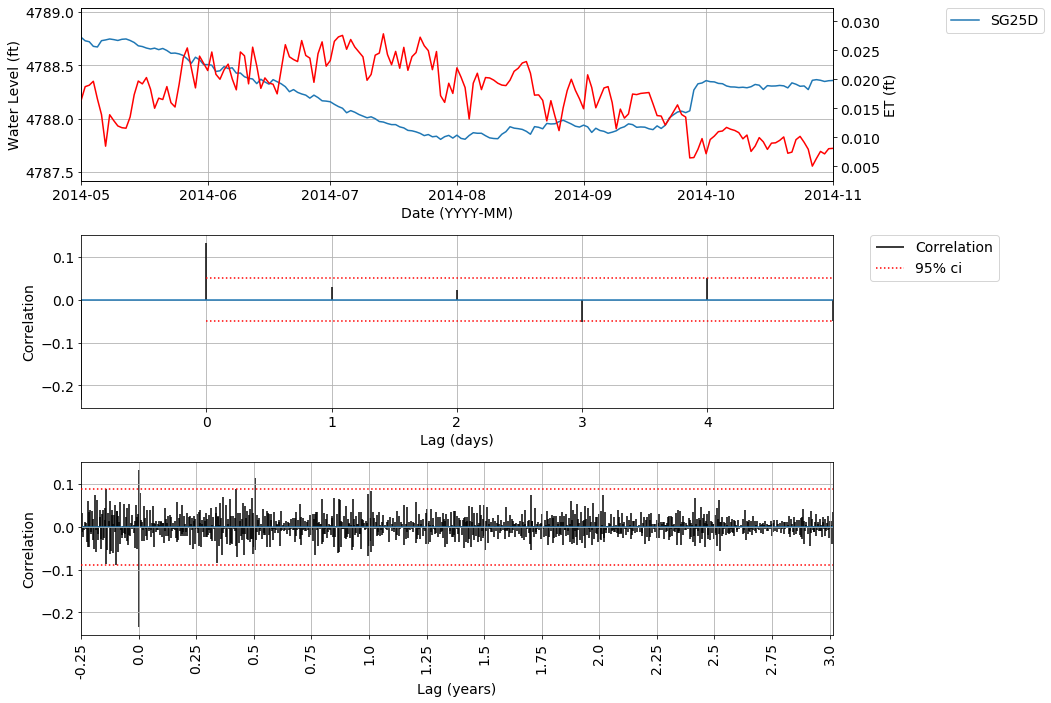

In [140]:
param = 'partoun_et_ft'
for col in wlClim.columns:
    if '_wle' in col:

        fig, ax = plt.subplots(3,1)
        #col = '1012_wle'
        df = wlClim.loc['2010-10-01':'2019-08-07',(param,col)].resample('1D').mean().interpolate(method='time').dropna()
        df = df[df.index.month.isin([5,6,7,8,9,10])]
        x = df.index
        y1 = df[col]
        y2 = df[param]

        y3 = y1.diff().diff()[2:-2].values
        y4 = y2.diff().diff()[2:-2].values

        ax[0].plot(x,y1,label=col.split('_')[0])
        ax0a = ax[0].twinx()
        ax0a.plot(x,y2,color='red',label='Partoun ET')
        ax[0].set_ylabel('Water Level (ft)')
        ax0a.set_ylabel('ET (ft)')
        ax[0].legend(bbox_to_anchor=(1.15, 1), loc='upper left', borderaxespad=0.)
        ax[0].set_xlim(pd.to_datetime('2014-05-01'),pd.to_datetime('2014-11-01'))
        ax[0].grid(True)
        ax[0].set_xlabel('Date (YYYY-MM)')
        
        lillags = 5
        sl = 2 / np.sqrt(len(df)-lillags)
        ax[1].xcorr(y4,y3, usevlines=True, normed=True, maxlags=lillags, label='Correlation')
        ax[1].grid()
        ax[1].set_xlabel('Lag (days)')
        ax[1].set_xlim(-1,lillags)
        ax[1].hlines(sl,0,lillags,linestyles=':',color='red',label='95% ci')
        ax[1].hlines(-sl,0,lillags,linestyles=':',color='red')
        ax[1].set_xticks(np.arange(0, lillags, 1))
        ax[1].set_xticklabels(np.arange(0, lillags, 1))
        ax[1].set_ylabel('Correlation')
        ax[1].legend(loc='upper left',bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        
        mult = 1
        biglags = 750
        sl2 = 2 / np.sqrt(len(df)-biglags)
        ax[2].xcorr(y3, y4,
                    usevlines=True, normed=True, 
                    maxlags=biglags,
                    zorder=0)

        ax[2].hlines(sl2,-1*biglags,biglags,linestyles=':',color='red',label='95% ci',zorder=10)
        ax[2].hlines(-sl2,-1*biglags,biglags,linestyles=':',color='red',zorder=11)
        ax[2].grid()
        ax[2].set_xlabel('Lag (years)')
        ax[2].set_xlim(-91.25*mult, biglags)
        ax[2].set_xticks(np.arange(-91.25*mult, biglags, 91.25*mult))
        ax[2].set_xticklabels(np.arange(-0.25, round(biglags/(365.25*mult)+0.25,2), 0.25),rotation=90)
        ax[2].set_ylabel('Correlation')
        
        plt.tight_layout()
        plt.savefig(file_place+f'et_corr_{col}.png')
        plt.savefig(file_place+f'et_corr_{col}.pdf')
        plt.savefig(file_place+f'et_corr_{col}.svg')

## Snowdepth

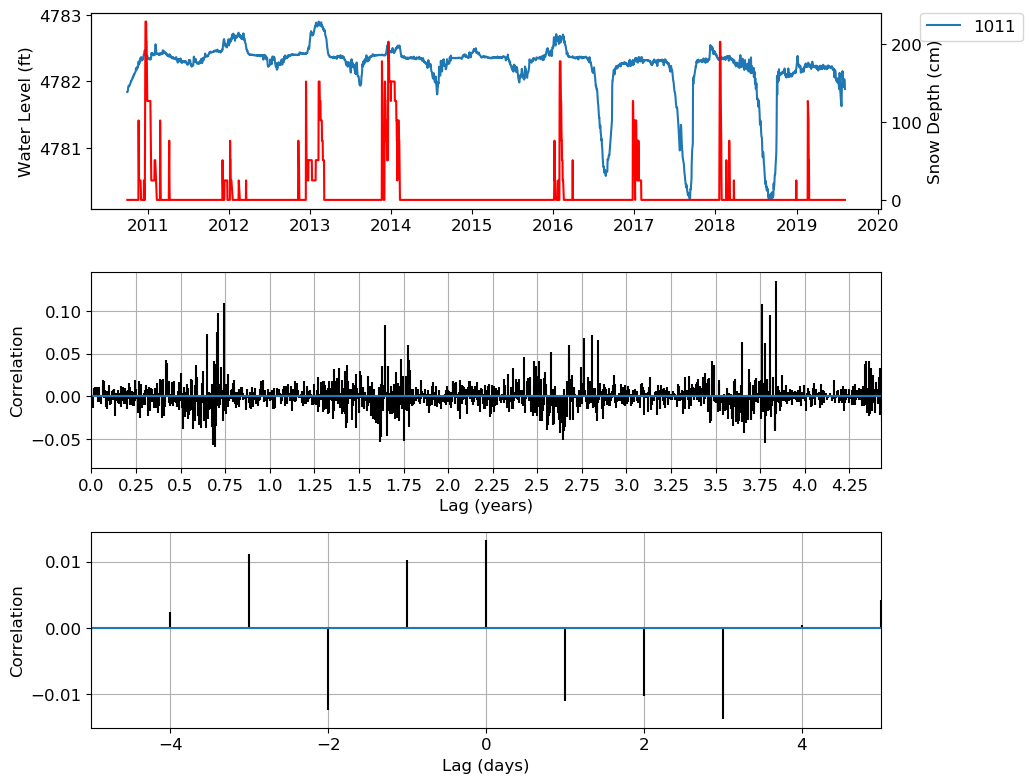

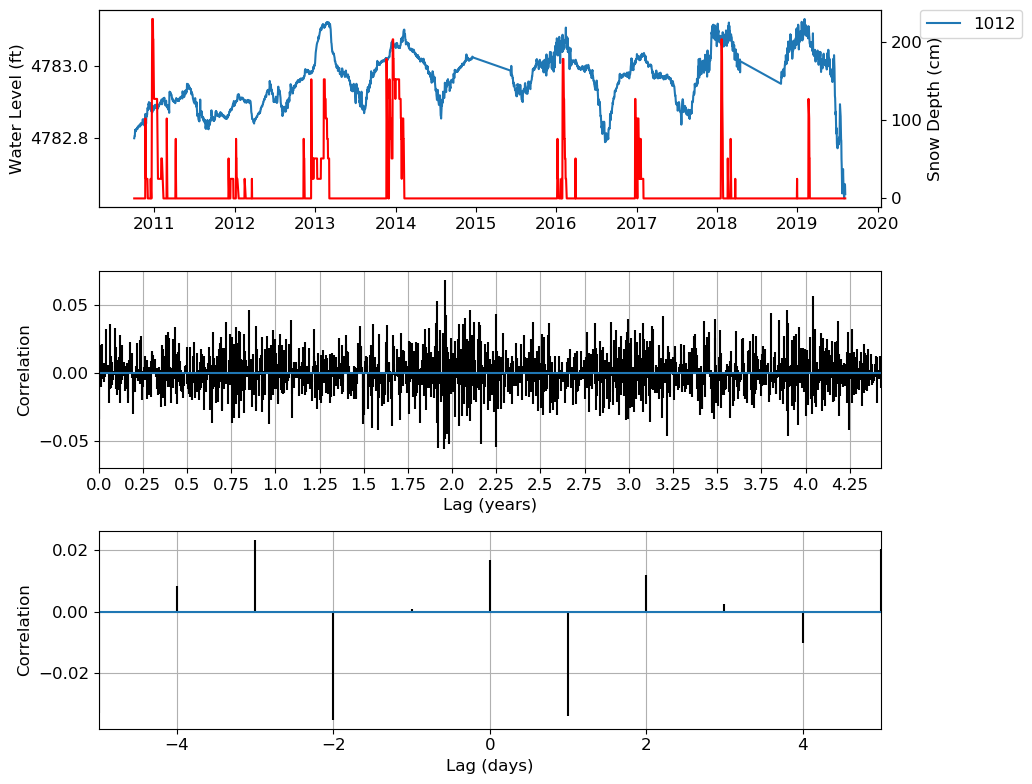

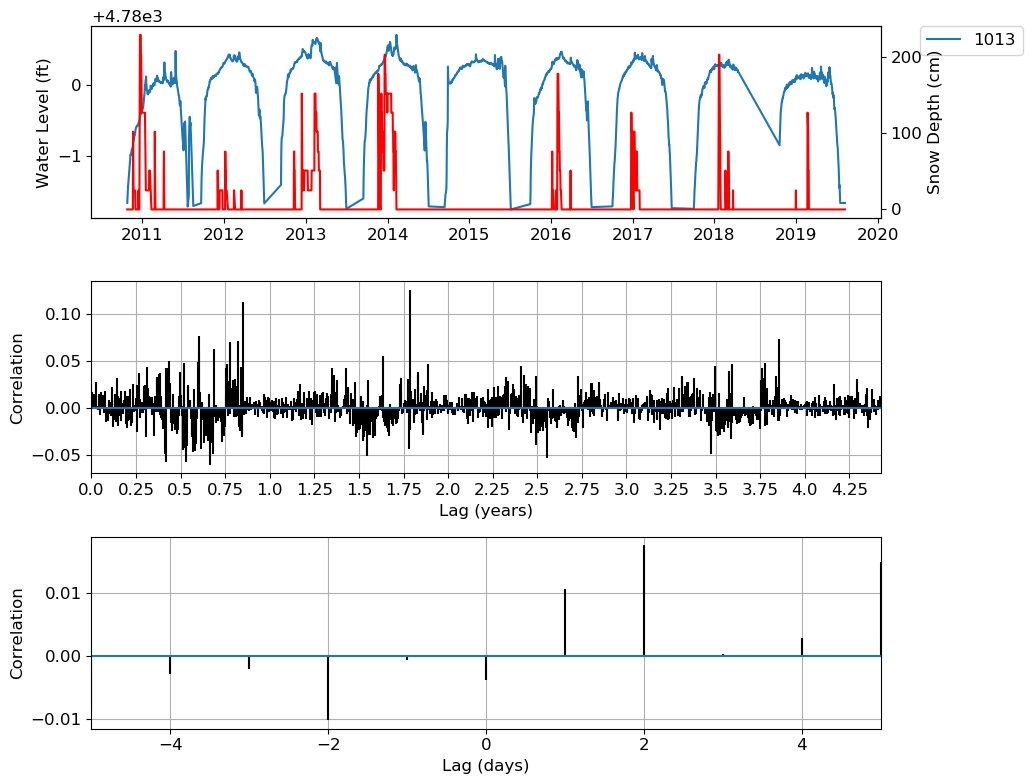

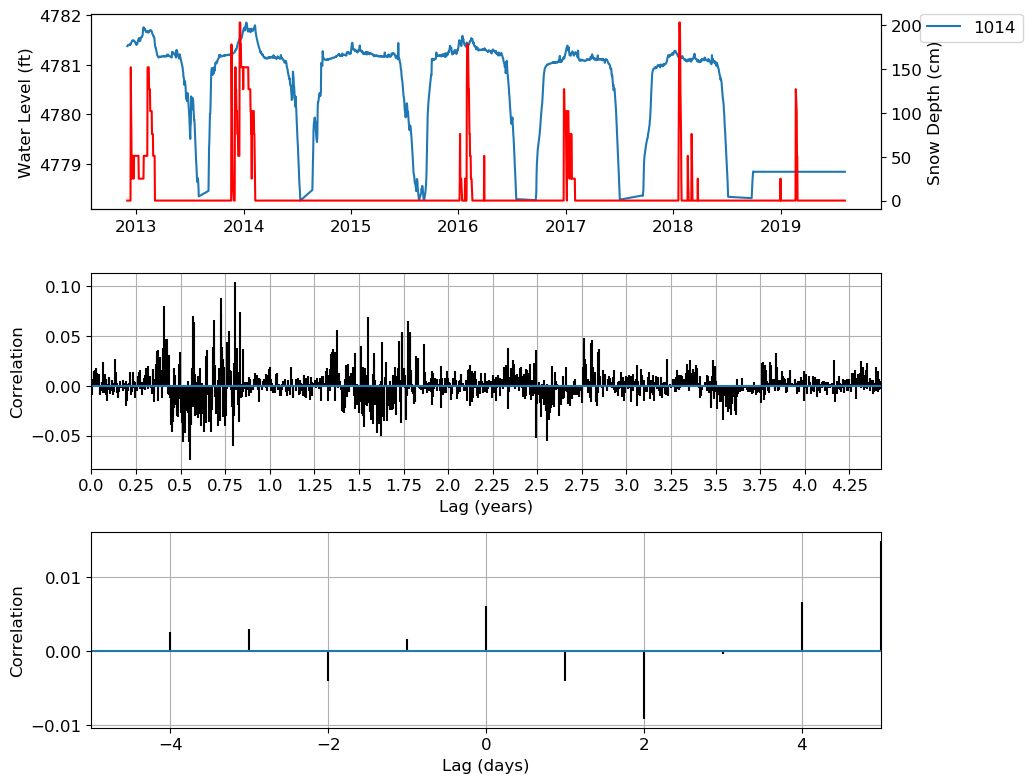

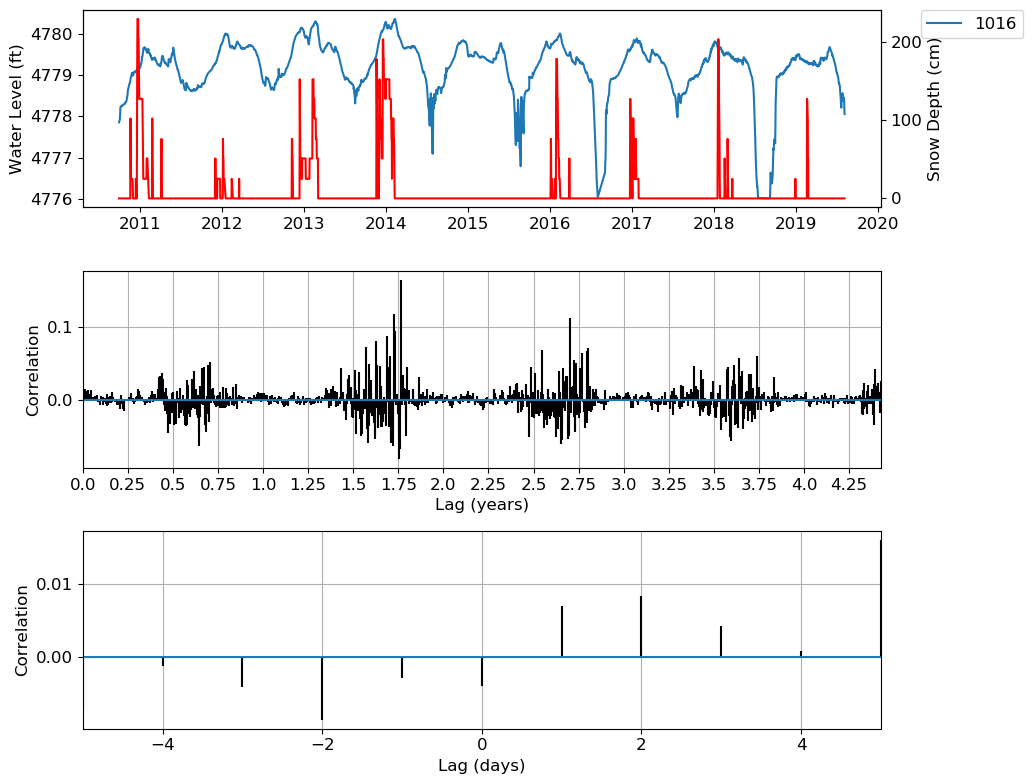

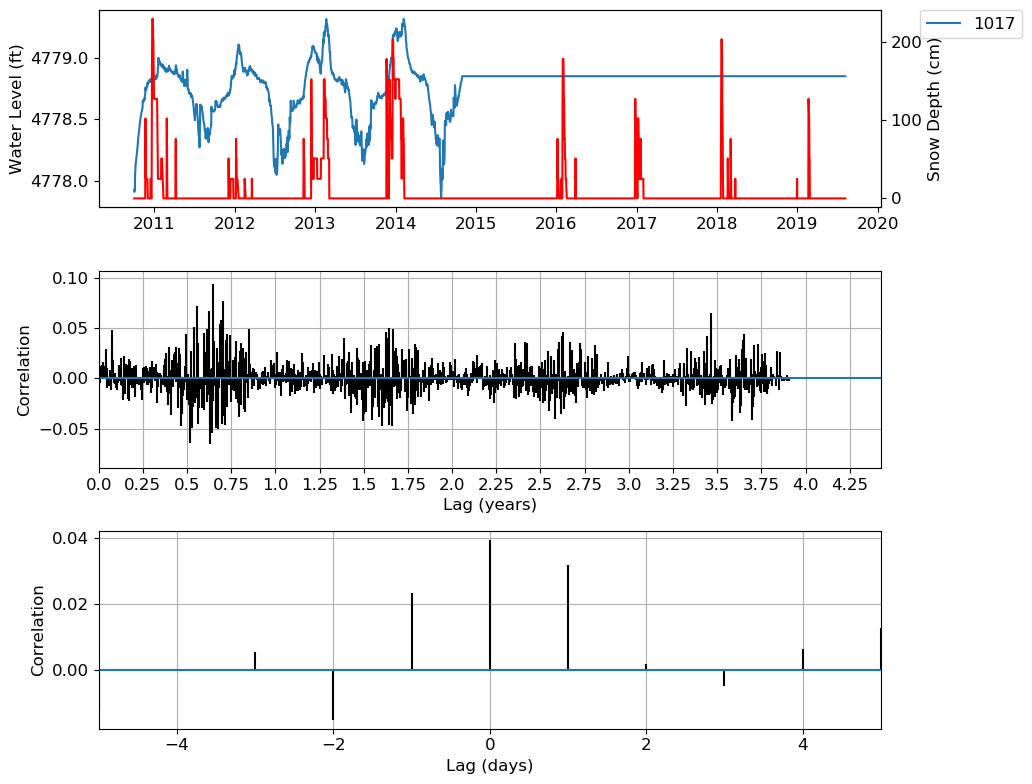

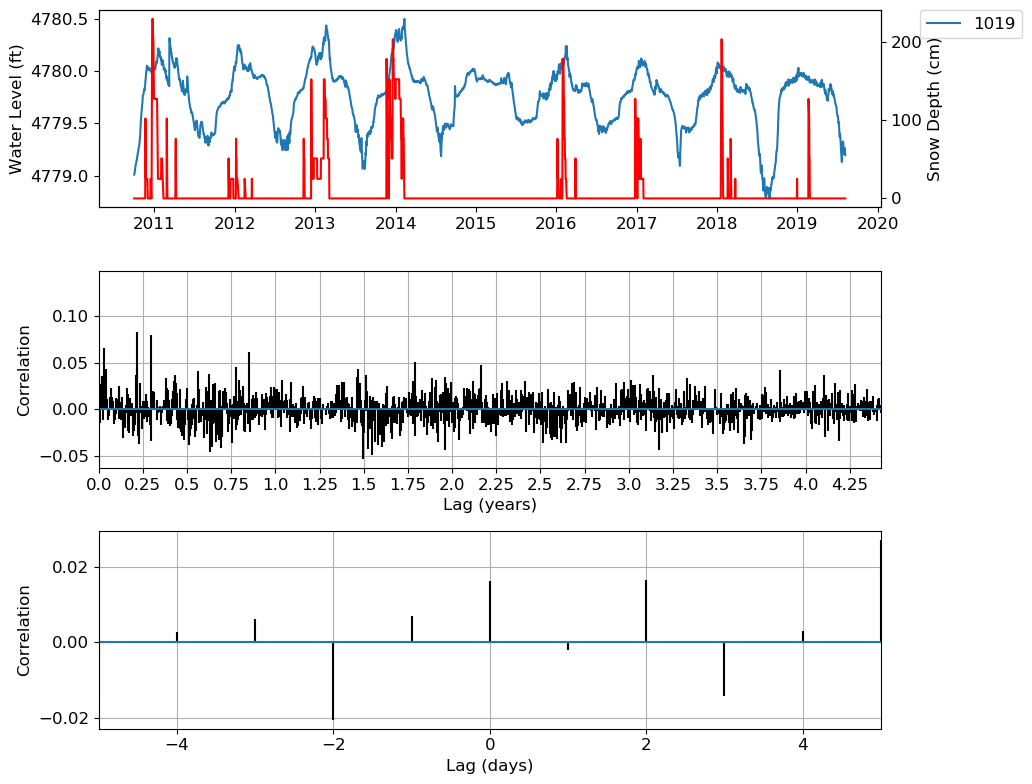

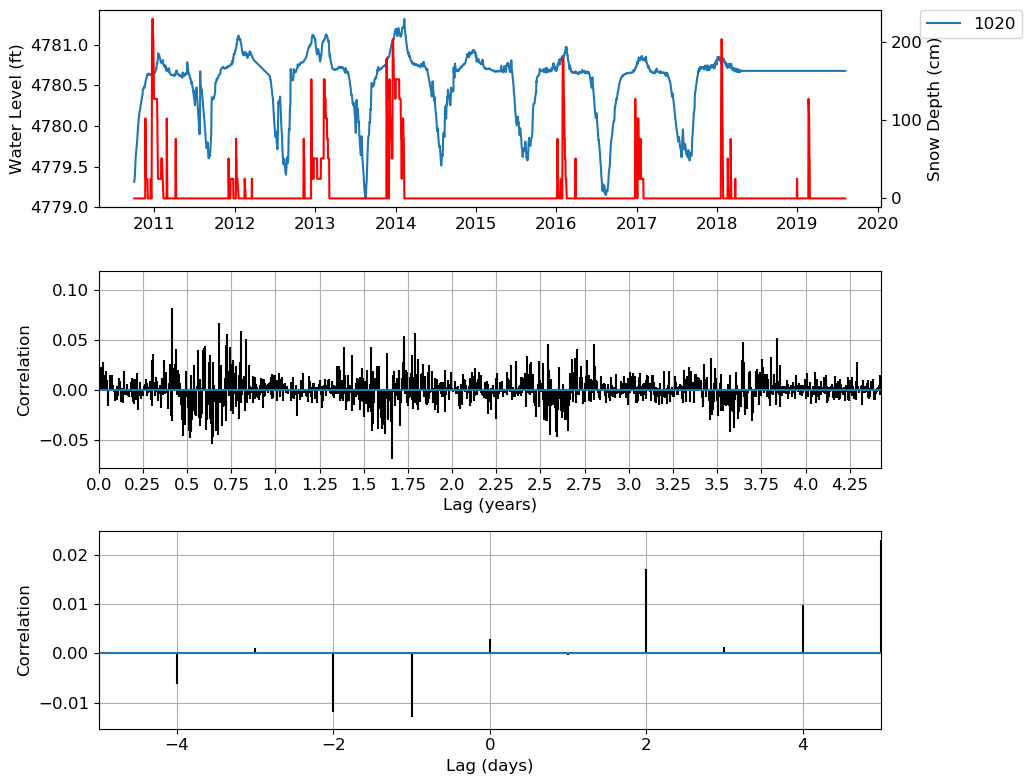

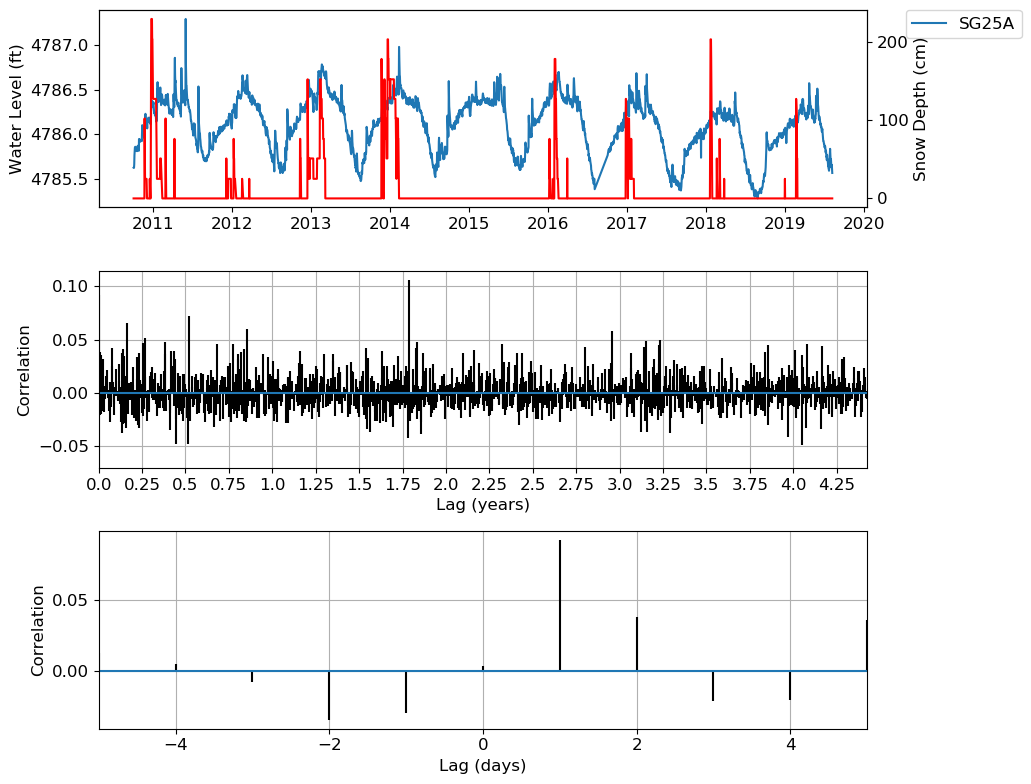

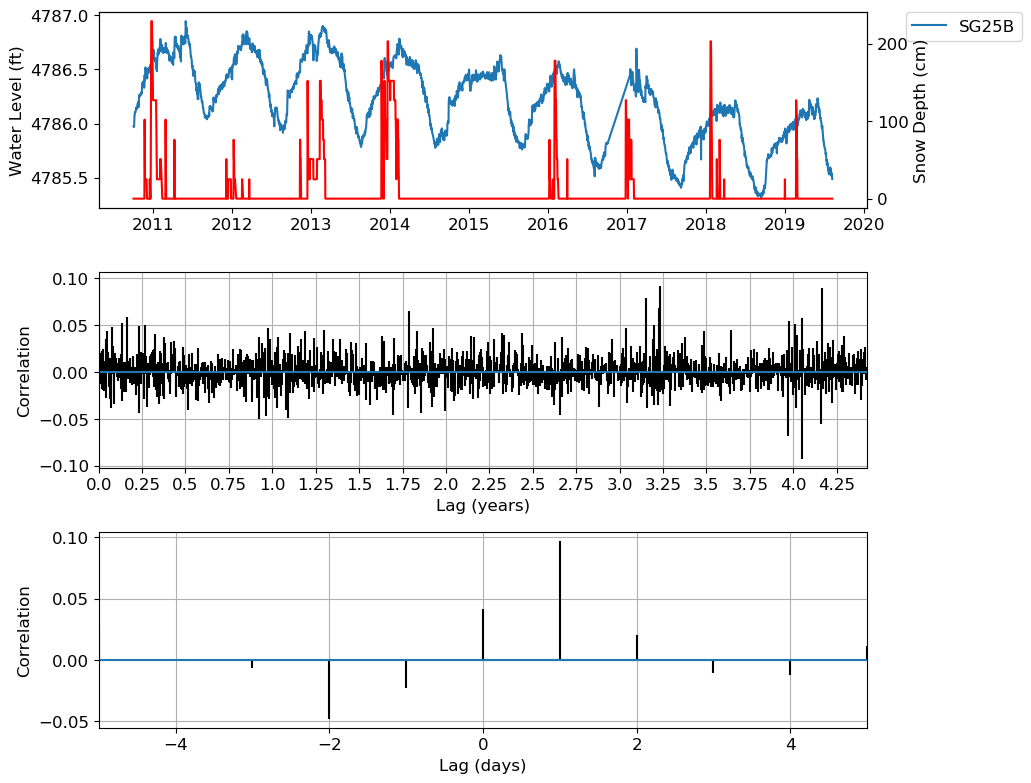

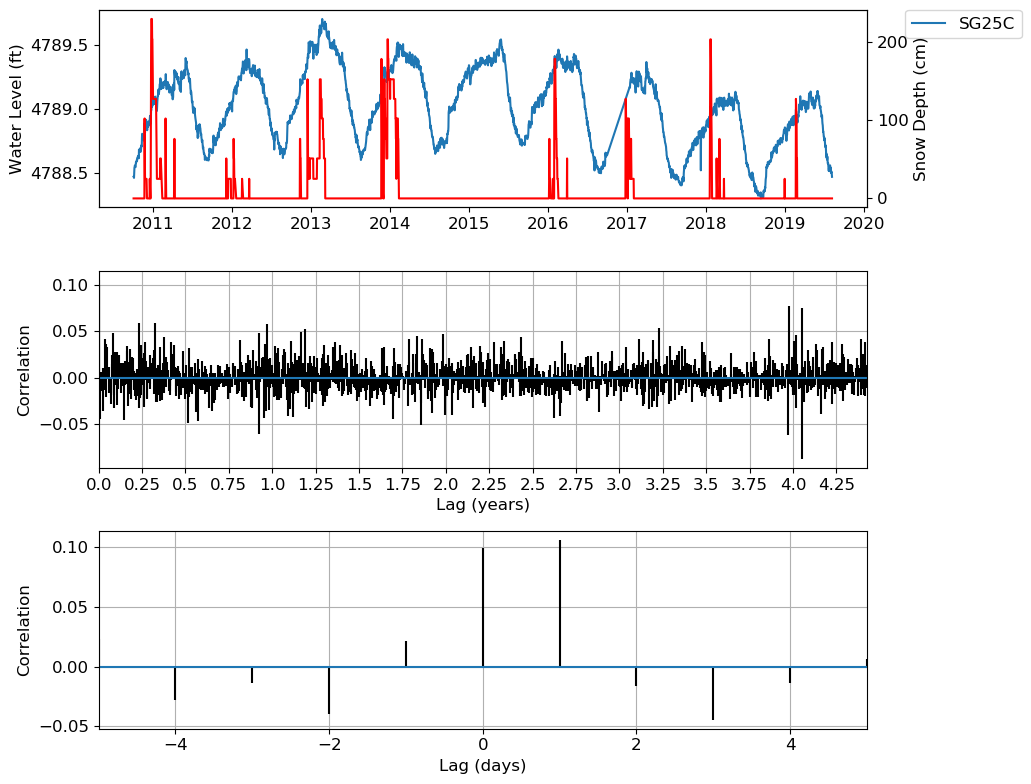

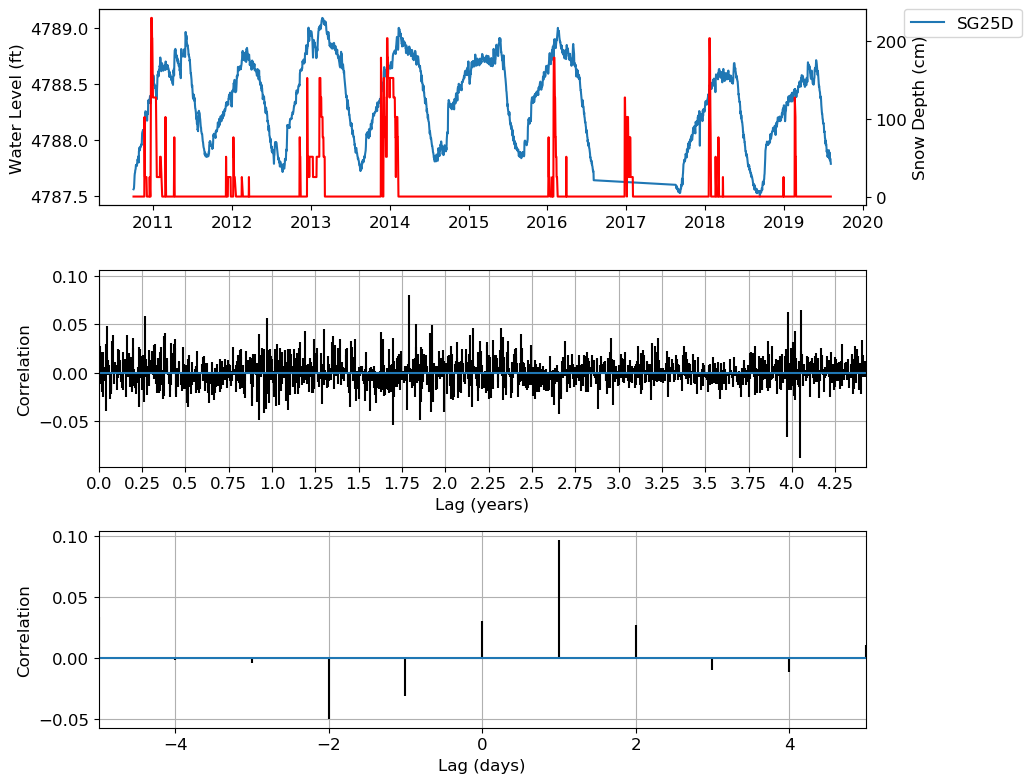

In [25]:
for col in wlClim.columns:
    if '_wle' in col:

        fig, ax = plt.subplots(3,1)
        #col = '1012_wle'
        df = wlClim.loc['2010-10-01':'2019-08-07',('partoun_snowdpt',col)].resample('1D').mean().interpolate(method='time').dropna()
        x = df.index
        y1 = df[col]
        y2 = df['partoun_snowdpt']

        y3 = y1.diff()[1:-1].values
        y4 = y2.diff()[1:-1].values

        ax[0].plot(x,y1,label=col.split('_')[0])
        ax0a = ax[0].twinx()
        ax0a.plot(x,y2,color='red',label='Partoun Snow Depth')
        ax[0].set_ylabel('Water Level (ft)')
        ax0a.set_ylabel('Snow Depth (cm)')
        ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        ax[1].xcorr(y3,y4, usevlines=True, normed=True, maxlags=2000)
        #cr = scipy.signal.correlate(y3,y4,method='fft',mode='same')
        #df = pd.DataFrame({'num':np.arange(len(cr)/-2,len(cr)/2),'corr':cr})
        #ax[1].plot(df['num'],df['corr'],color='green')

        ax[1].grid()
        ax[1].set_xlabel('Lag (years)')
        ax[1].set_xlim(0,len(cr)/2)
        ax[1].set_xticks(np.arange(0,(len(cr)/2),91.25))
        ax[1].set_xticklabels(np.arange(0,(len(cr)/2)/365,0.25))
        ax[1].set_ylabel('Correlation')
        ax[2].xcorr(y3,y4, usevlines=True, normed=True, maxlags=5)
        #ax[2].plot(df['num'],df['corr'],color='green')
        ax[2].grid()
        ax[2].set_xlabel('Lag (days)')
        ax[2].set_xlim(-5,5)
        ax[2].set_ylabel('Correlation')
        plt.tight_layout()
        plt.savefig(file_place+f'sd_corr_{col}.png')
        plt.savefig(file_place+f'sd_corr_{col}.pdf')
        plt.savefig(file_place+f'sd_corr_{col}.svg')

## Temperature

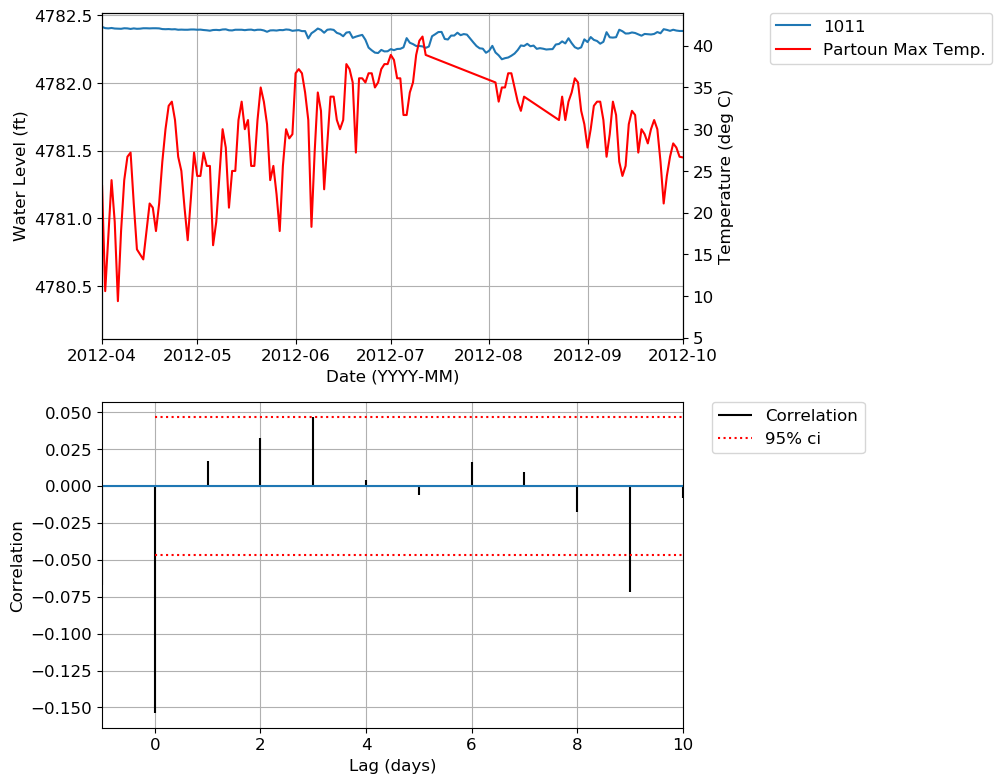

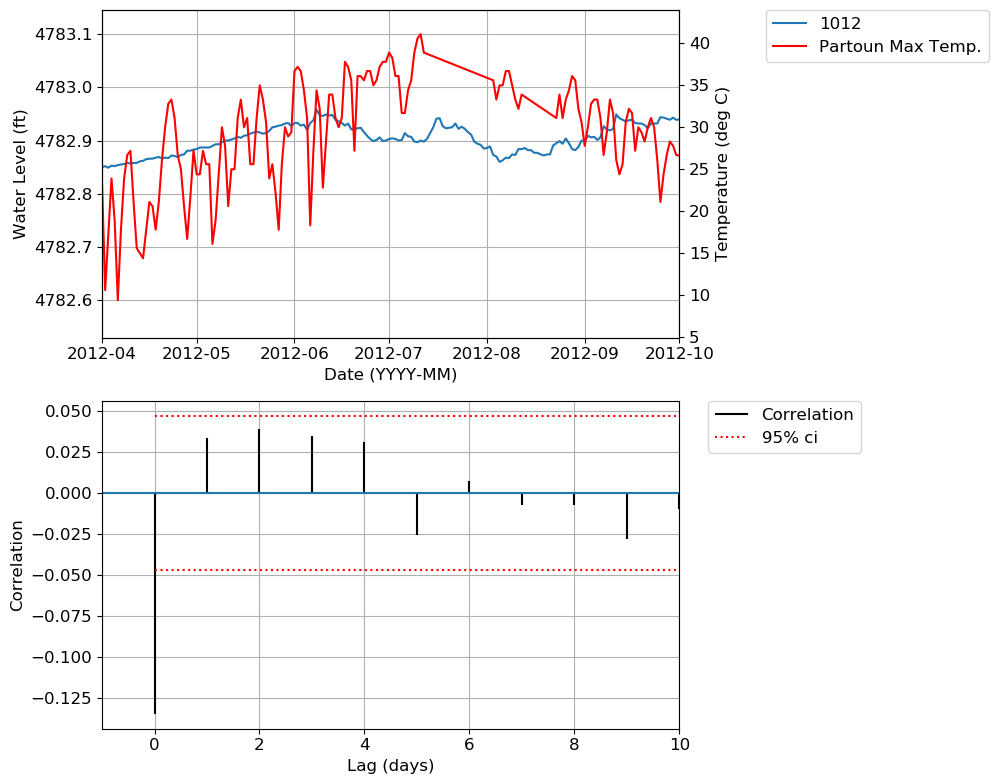

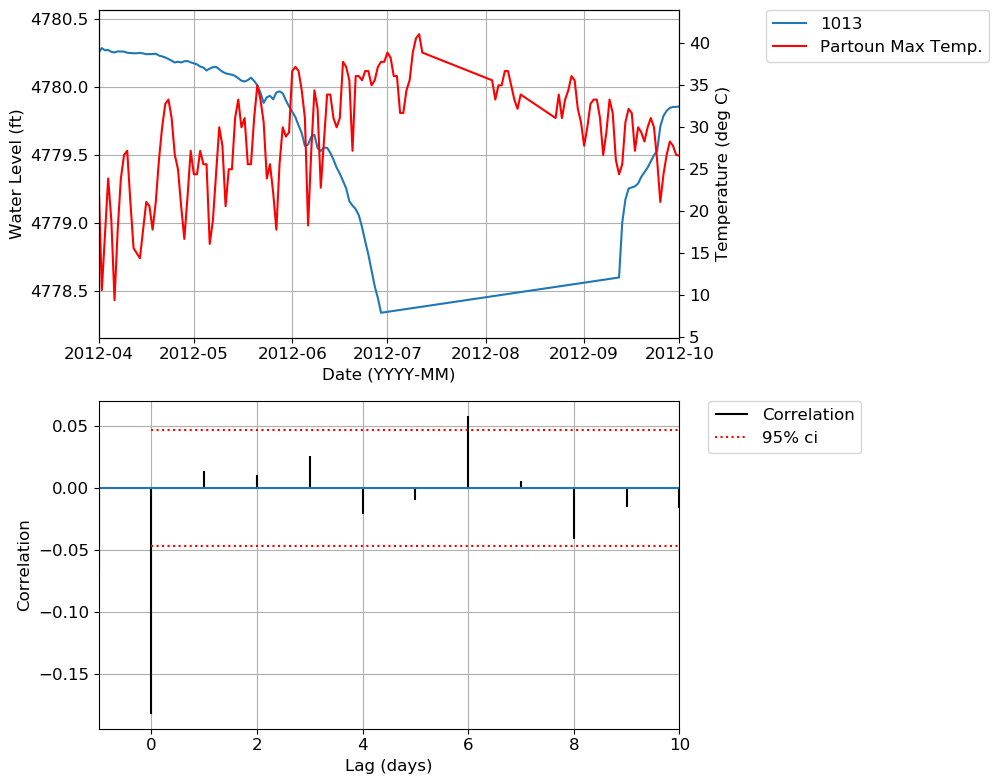

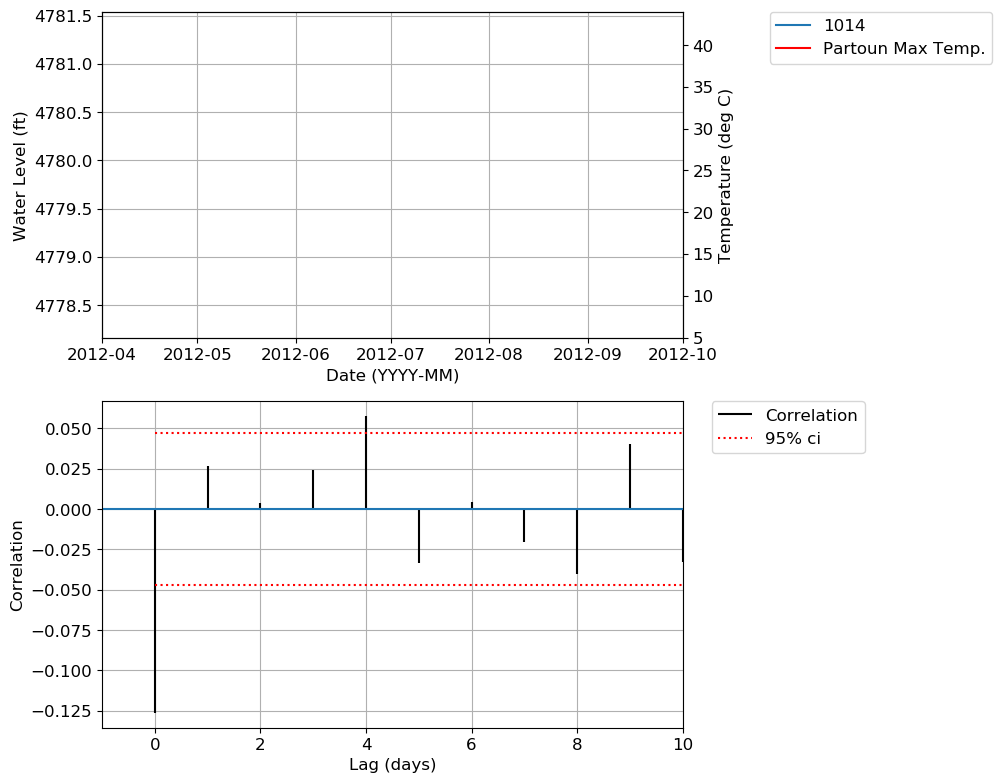

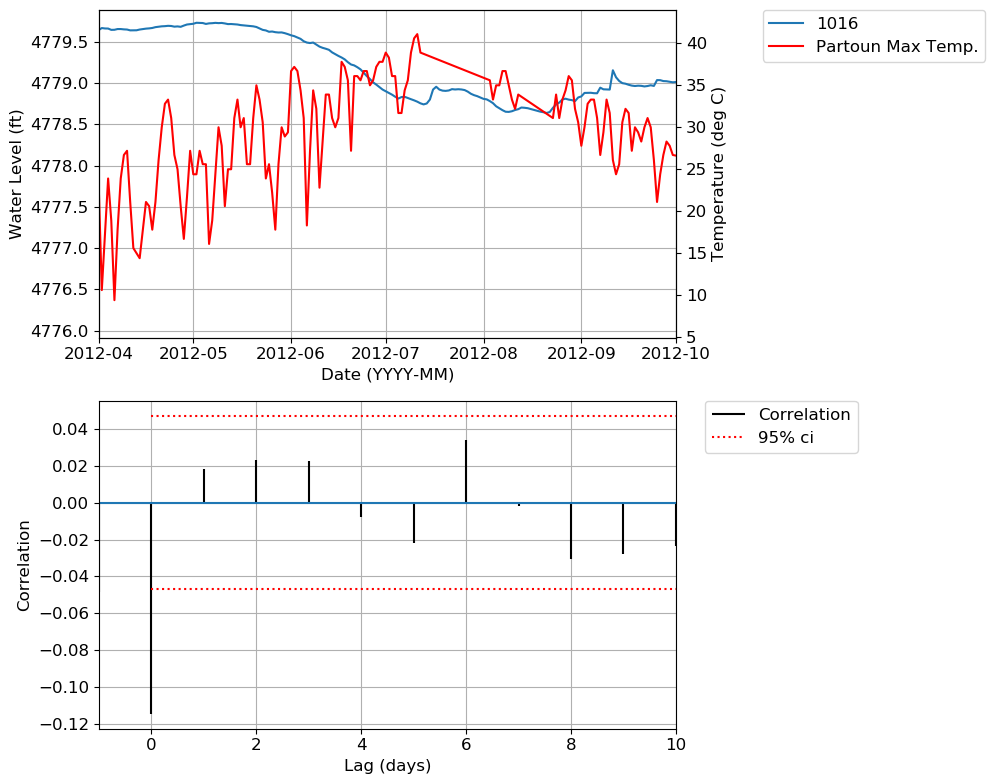

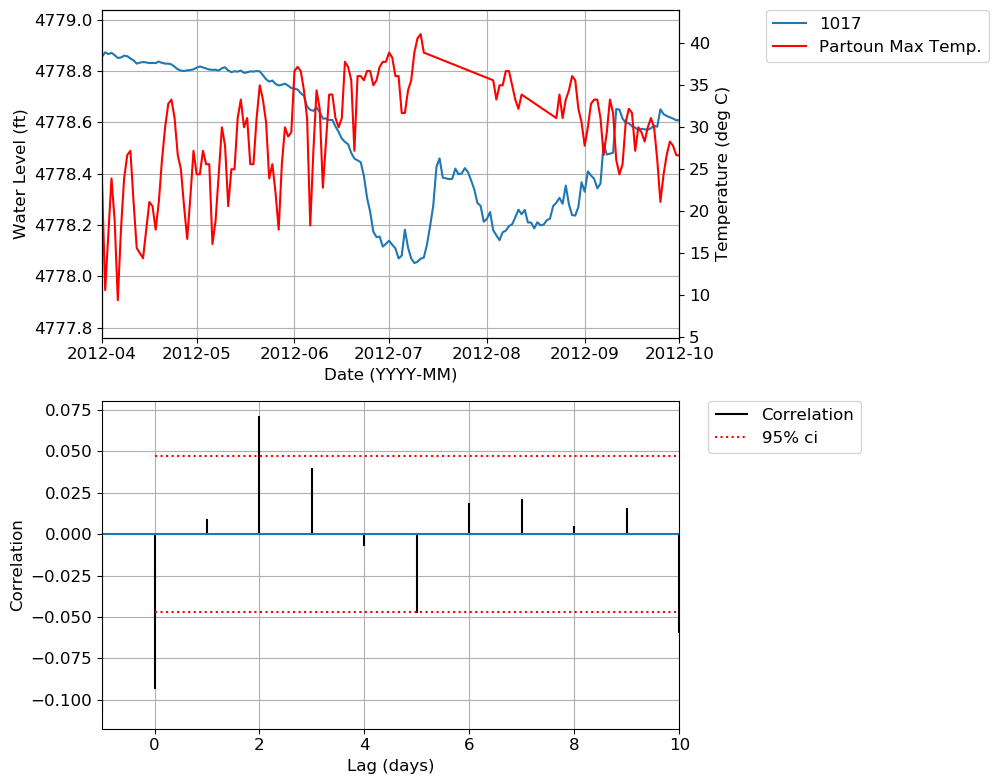

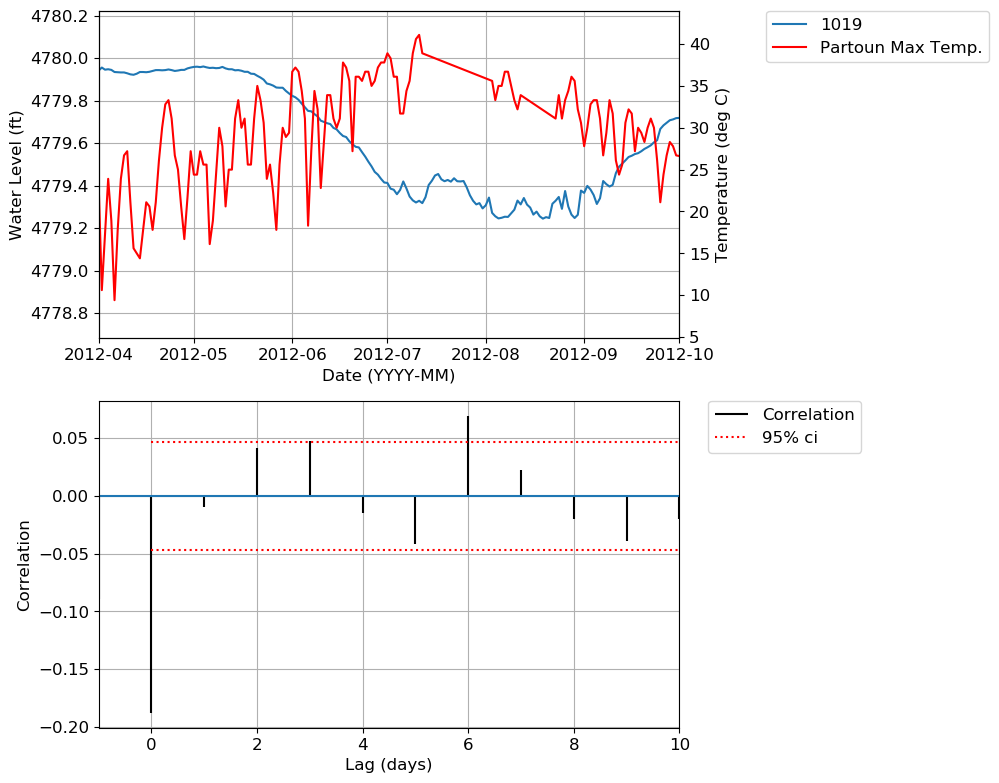

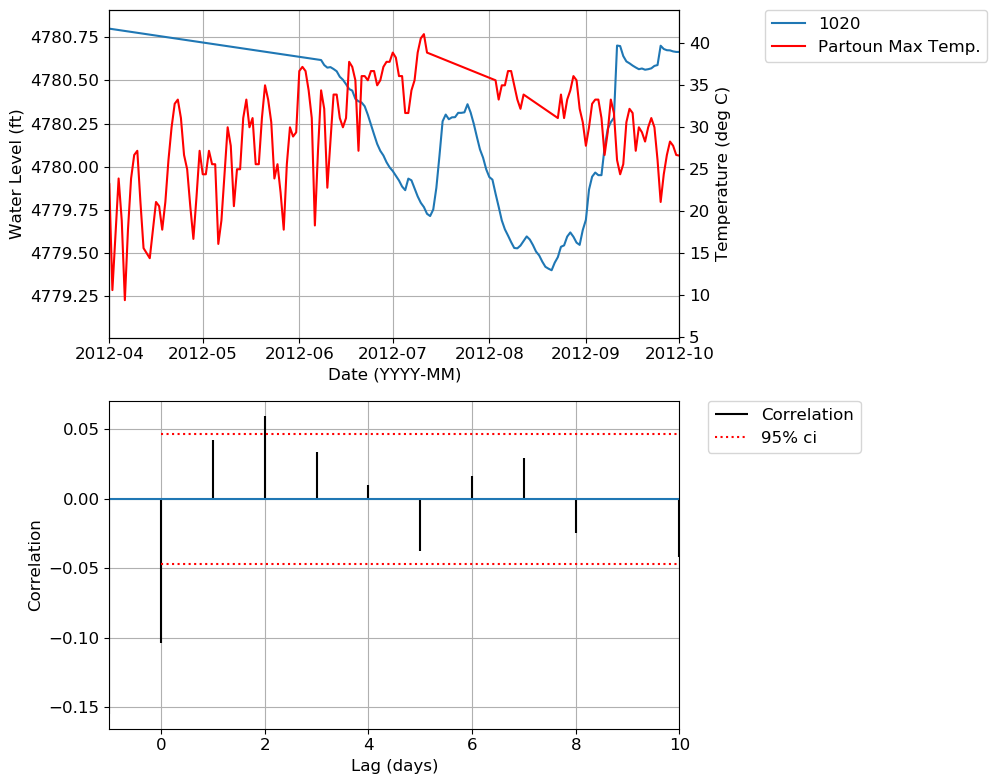

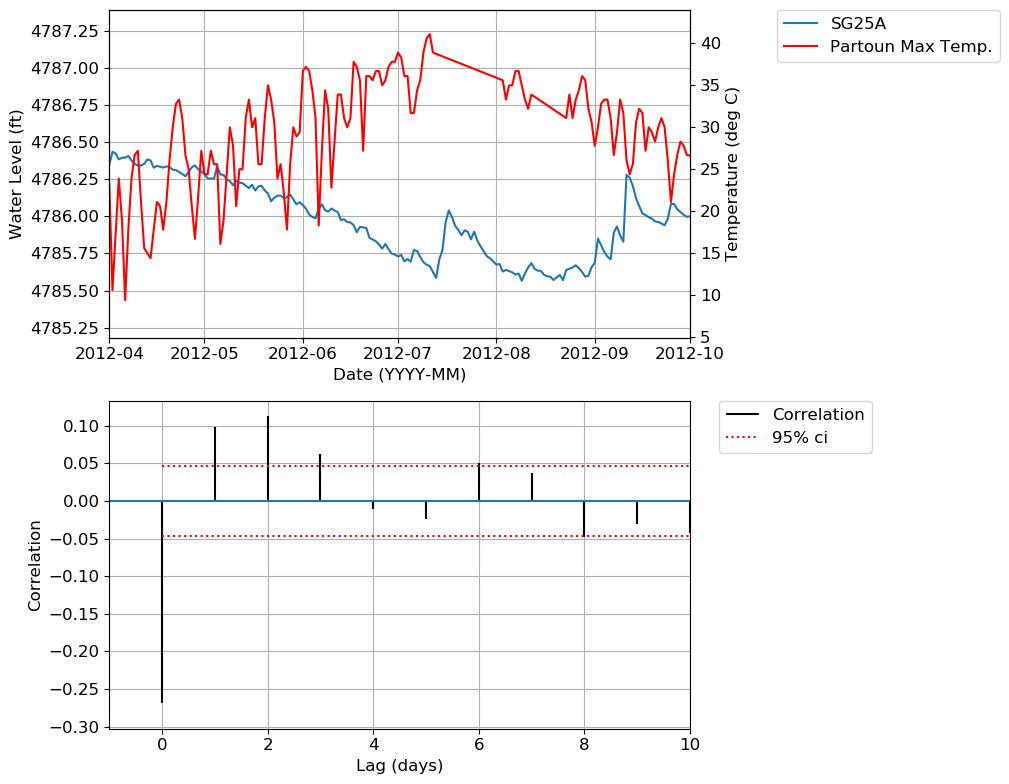

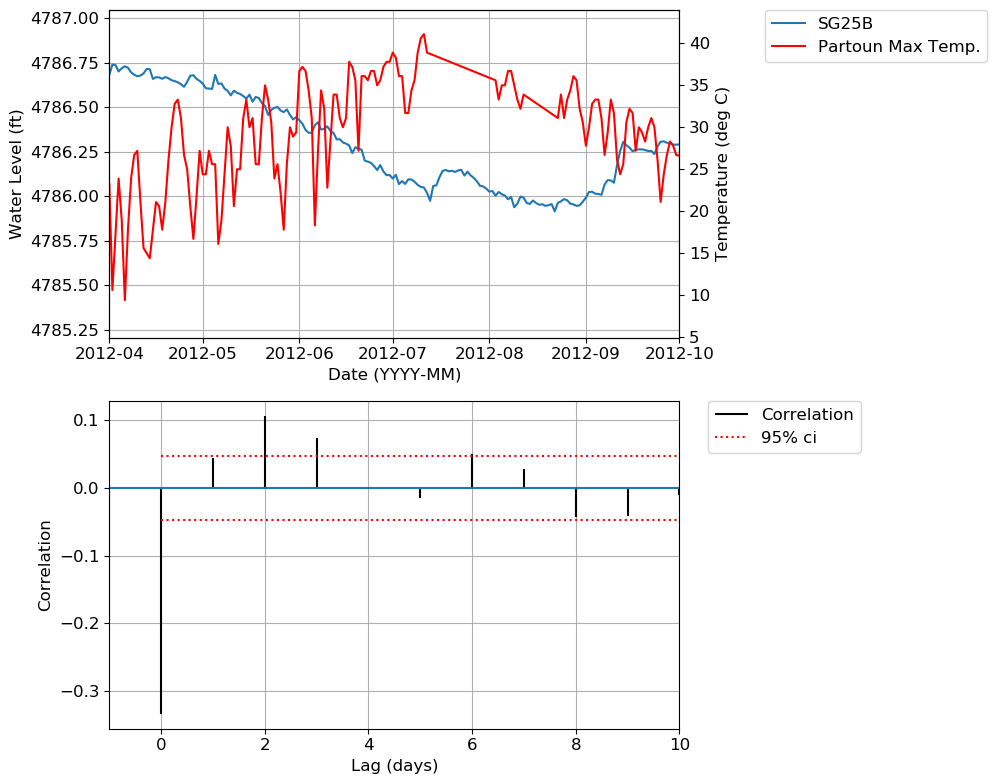

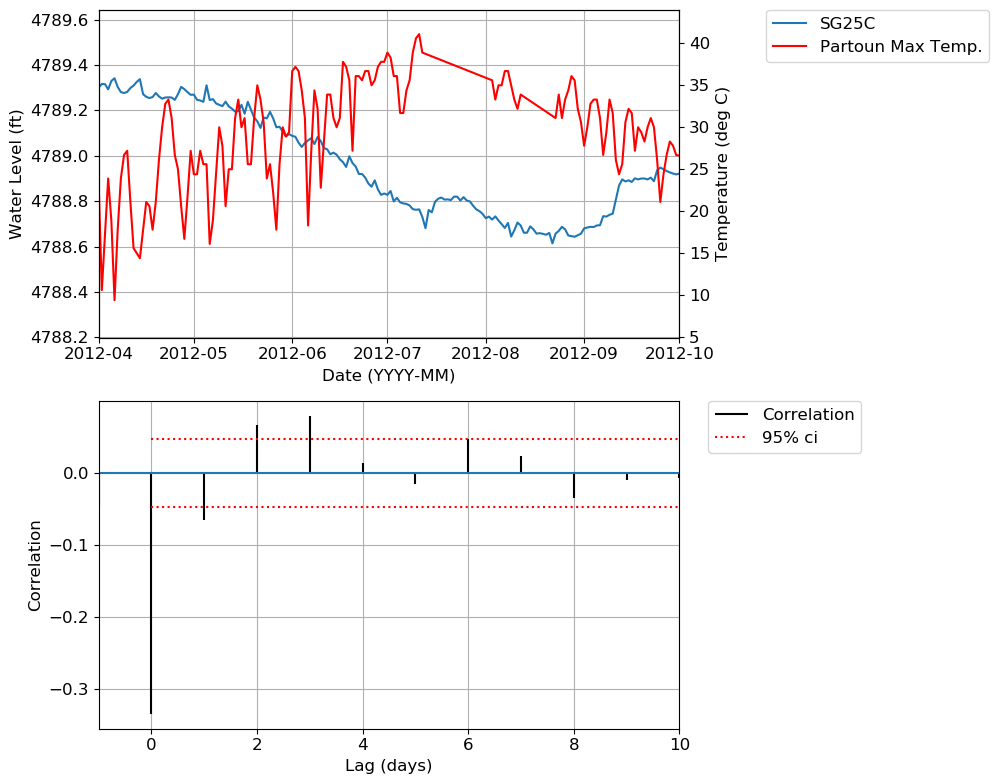

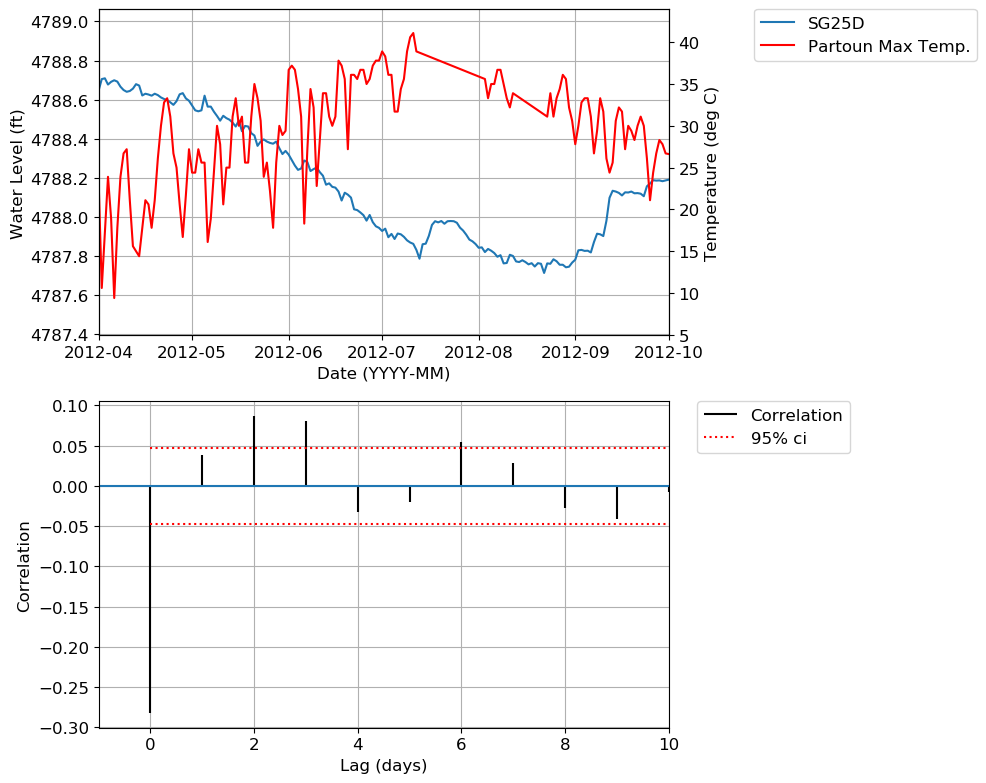

In [153]:
for col in wlClim.columns:
    if '_wle' in col:

        fig, ax = plt.subplots(2,1)
        #col = '1012_wle'
        df = wlClim.loc['2010-10-01':'2019-08-07',('partoun_maxtemp',col)].resample('1D').mean().interpolate(method='time').dropna()
        df = df[df.index.month.isin([4,5,6,7,8,9])]
        x = df.index
        y1 = df[col]
        y2 = df['partoun_maxtemp']

        y3 = y1.diff()[1:-1].values
        y4 = y2.diff()[1:-1].values

        ln1 = ax[0].plot(x,y1,label=col.split('_')[0])
        ax[0].set_ylim(y1.min()-0.1,y1.max()+0.1)
        ax0a = ax[0].twinx()
        ln2 = ax0a.plot(x,y2,color='red',label='Partoun Max Temp.')
        ax[0].set_ylabel('Water Level (ft)')
        ax0a.set_ylabel('Temperature (deg C)')
        ax[0].set_xlim(pd.to_datetime('2012-04-01'),pd.to_datetime('2012-10-01'))
        ax[0].grid(True)
        ax[0].set_xlabel('Date (YYYY-MM)')
        
        lns = ln1+ln2
        labs = [l.get_label() for l in lns]
        ax[0].legend(lns, labs, loc='upper left',bbox_to_anchor=(1.15, 1), borderaxespad=0.)
        
        lillags = 10
        sl = 2 / np.sqrt(len(df)-lillags)
        ax[1].xcorr(y4,y3, usevlines=True, normed=True, maxlags=lillags, label='Correlation')
        ax[1].grid()
        ax[1].set_xlabel('Lag (days)')
        ax[1].set_xlim(-1,lillags)
        ax[1].hlines(sl,0,biglags,linestyles=':',color='red',label='95% ci')
        ax[1].hlines(-sl,0,biglags,linestyles=':',color='red')
        ax[1].set_ylabel('Correlation')
        ax[1].legend(loc='upper left',bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        
        plt.tight_layout()
        plt.savefig(file_place+f'temp_sum_corr_{col}.png')
        plt.savefig(file_place+f'temp_sum_corr_{col}.pdf')
        plt.savefig(file_place+f'temp_sum_corr_{col}.svg')

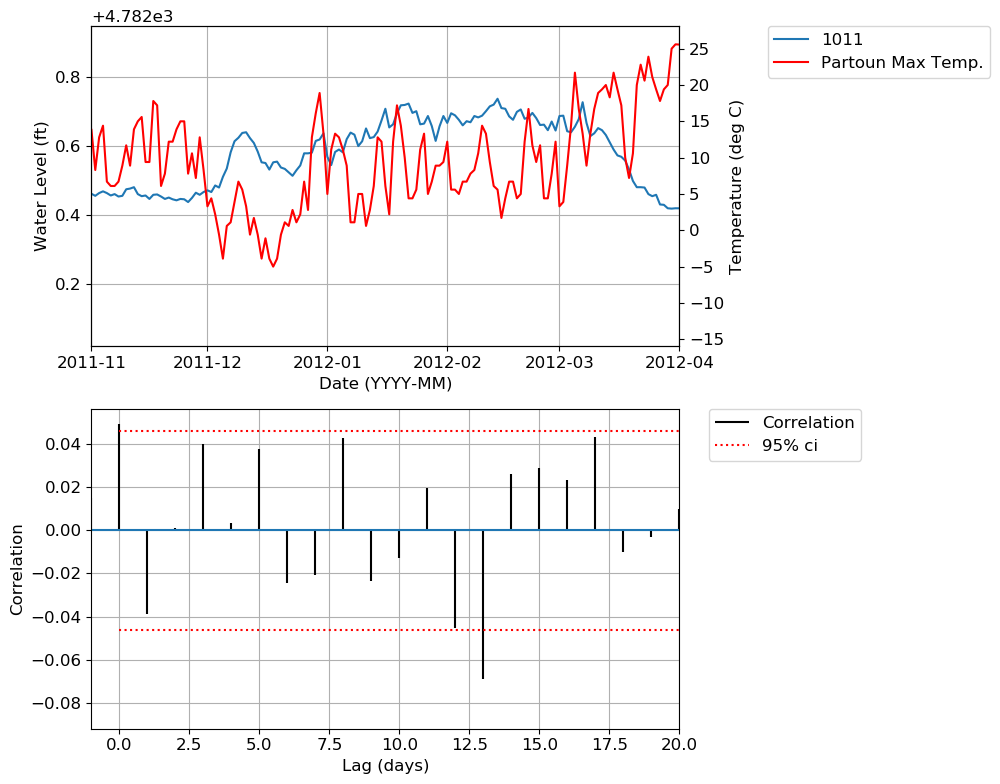

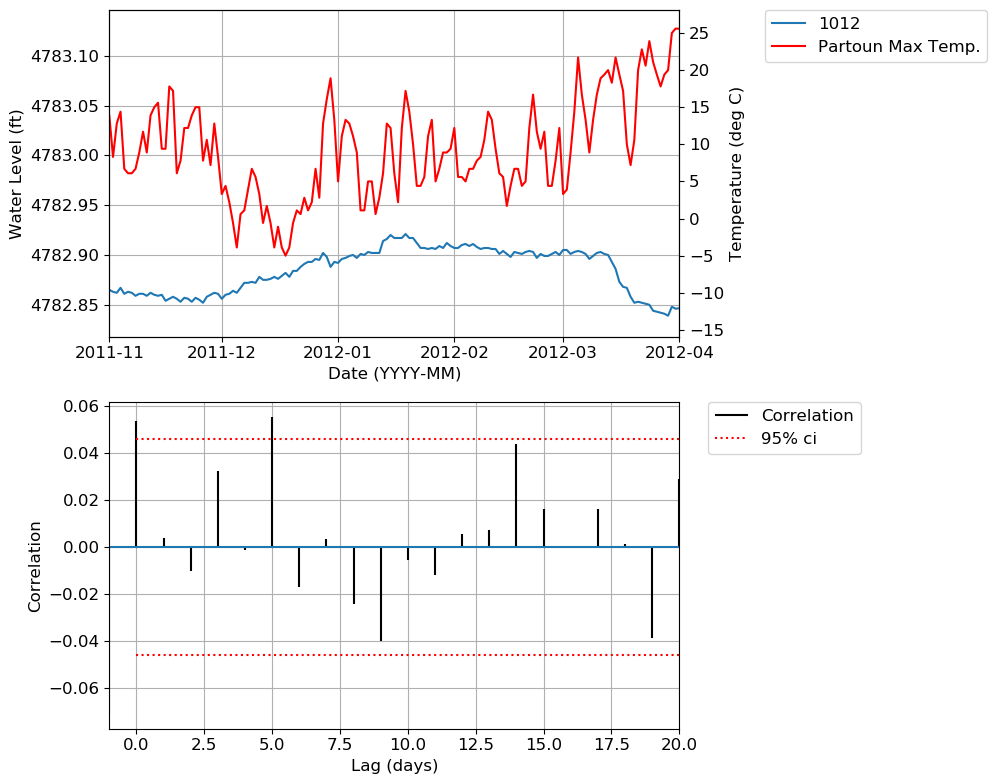

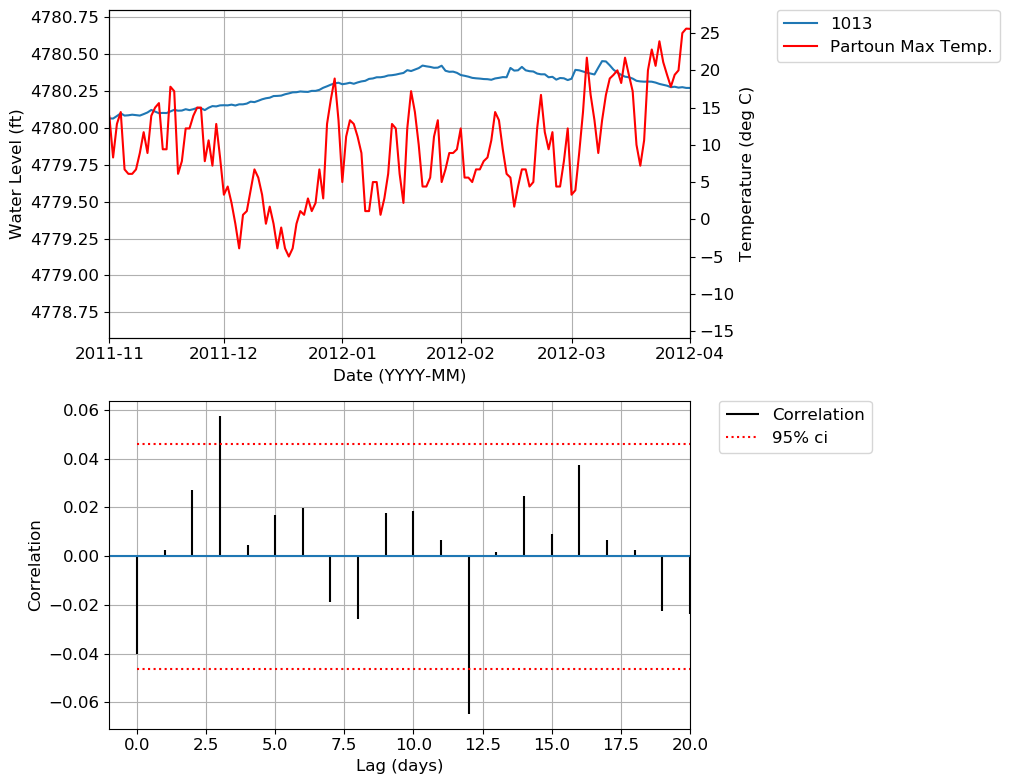

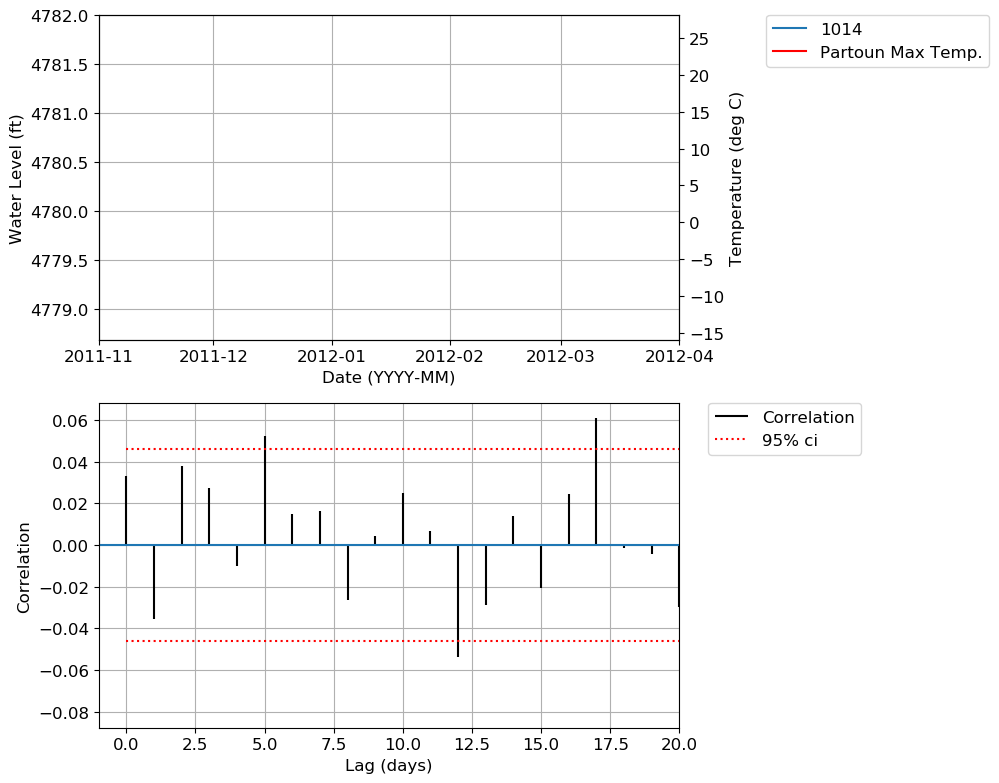

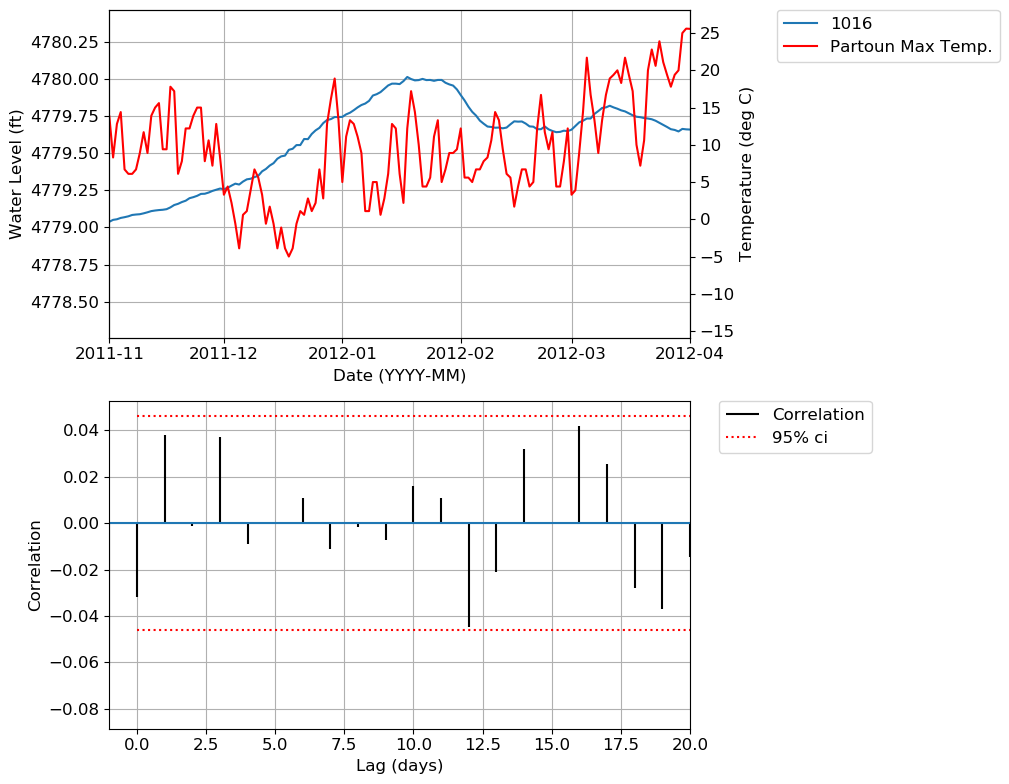

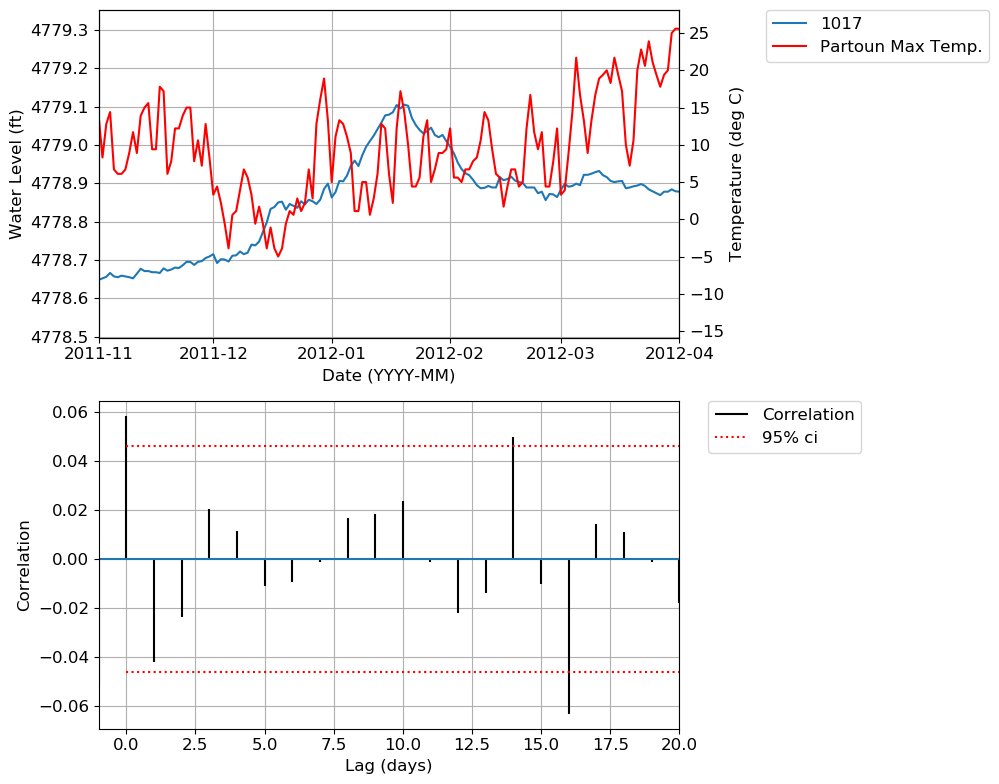

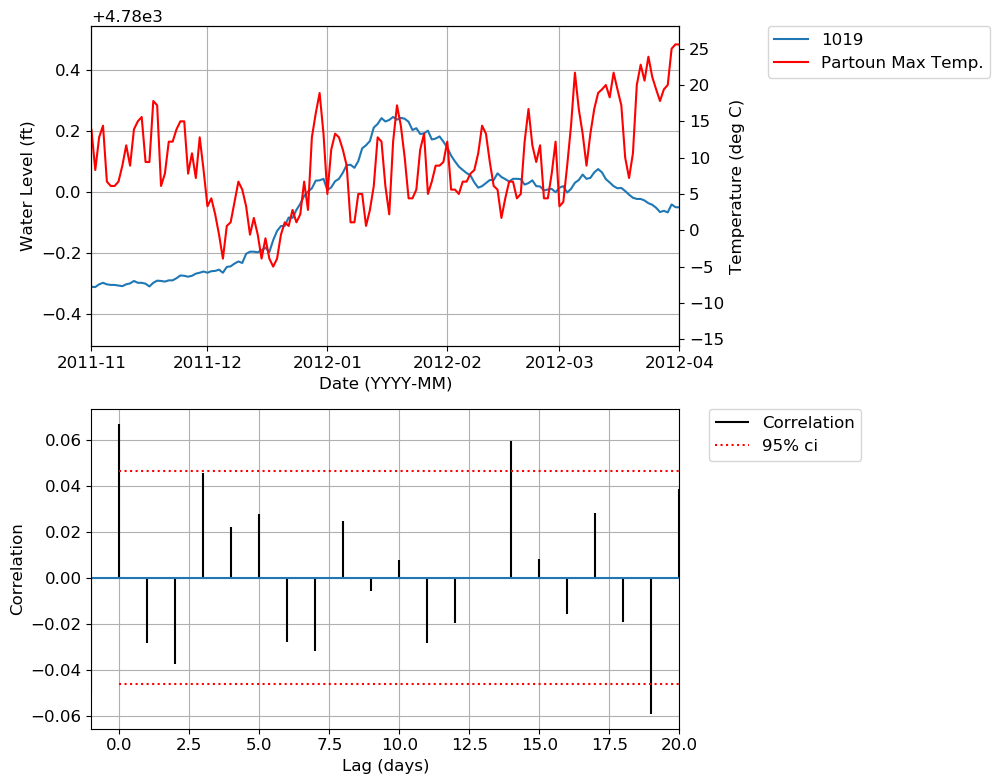

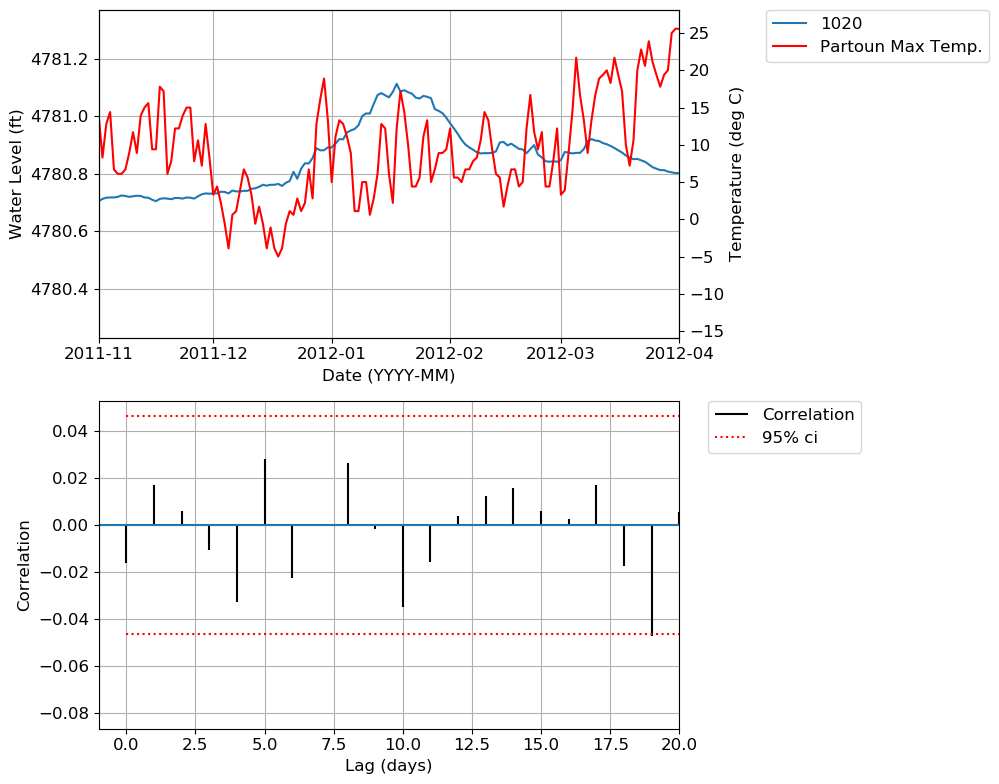

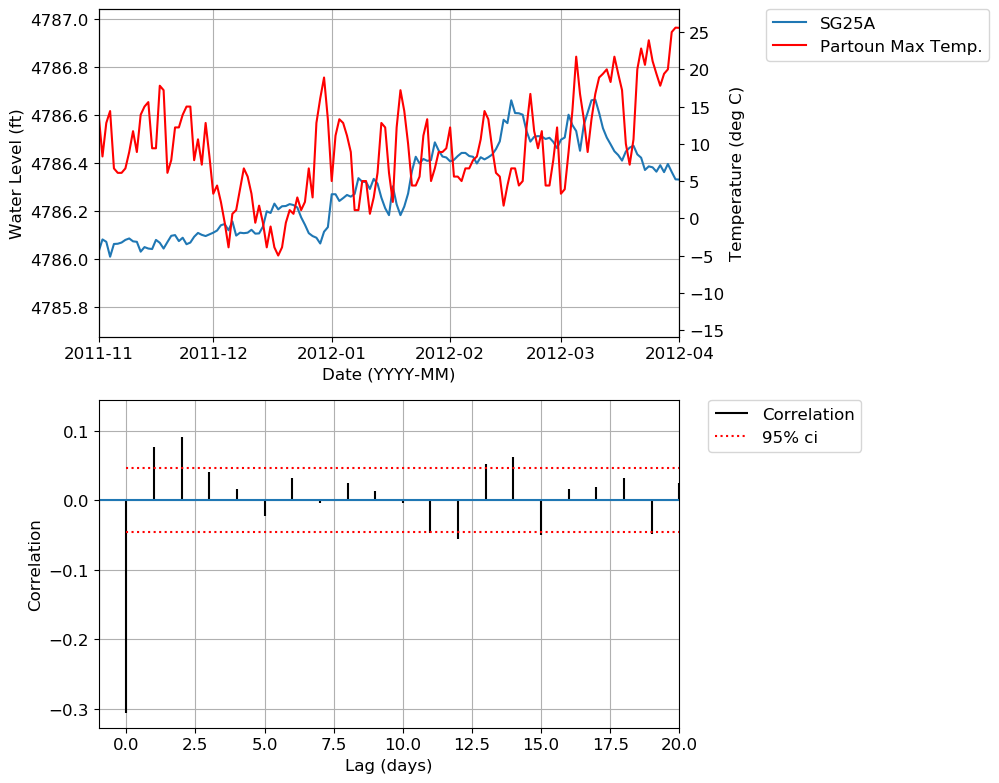

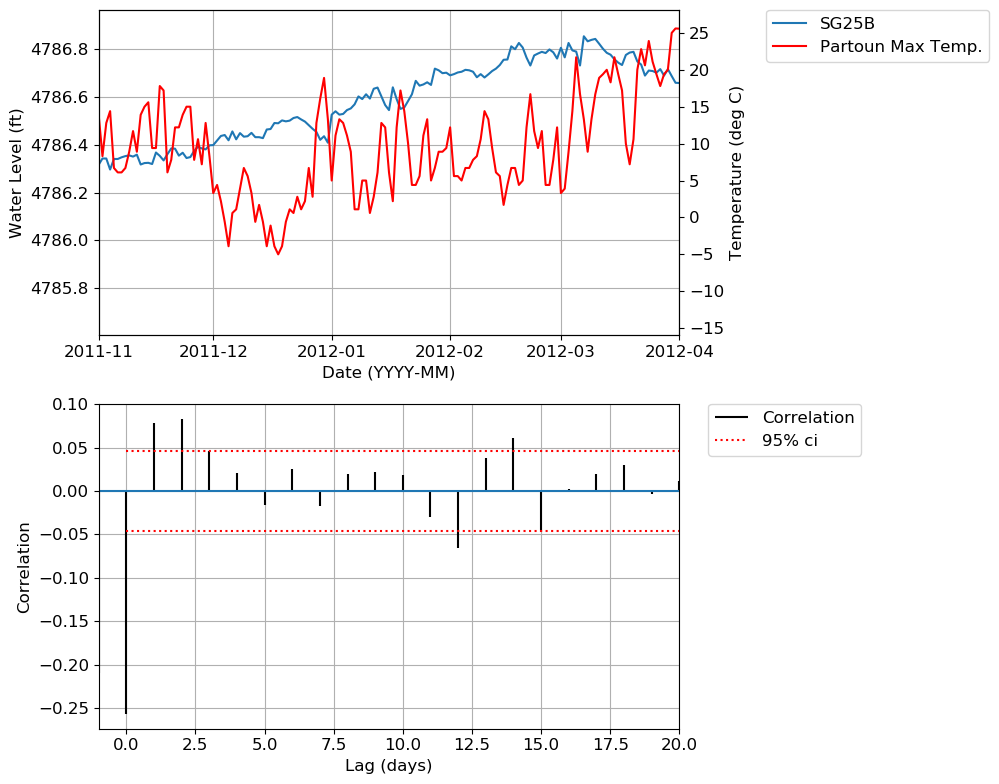

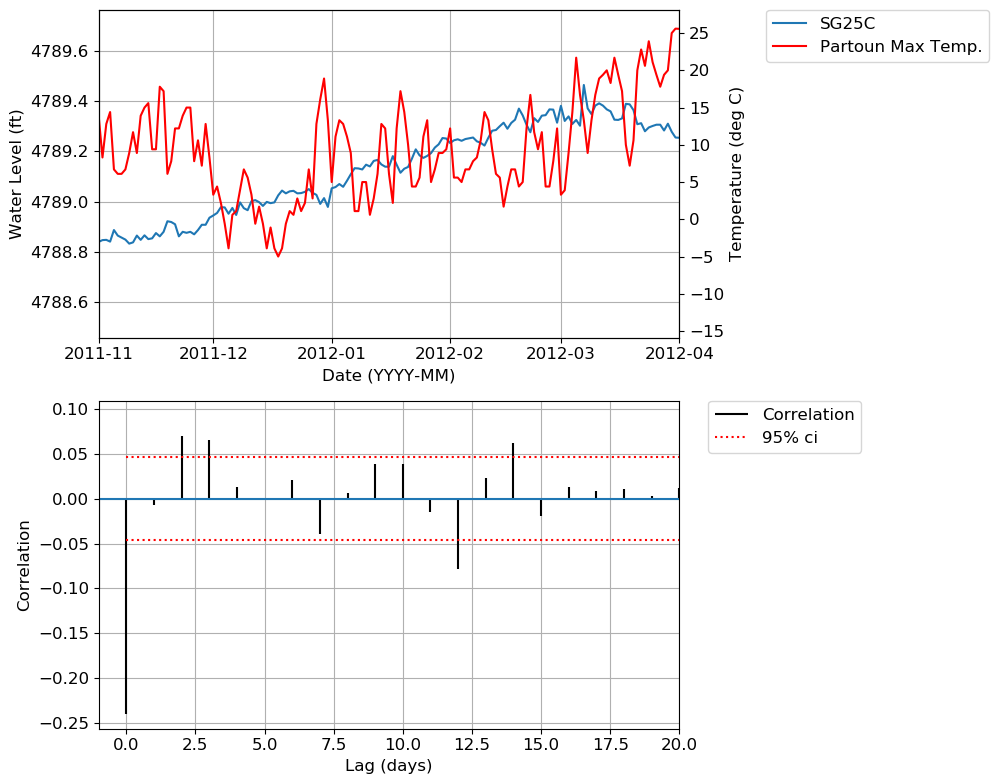

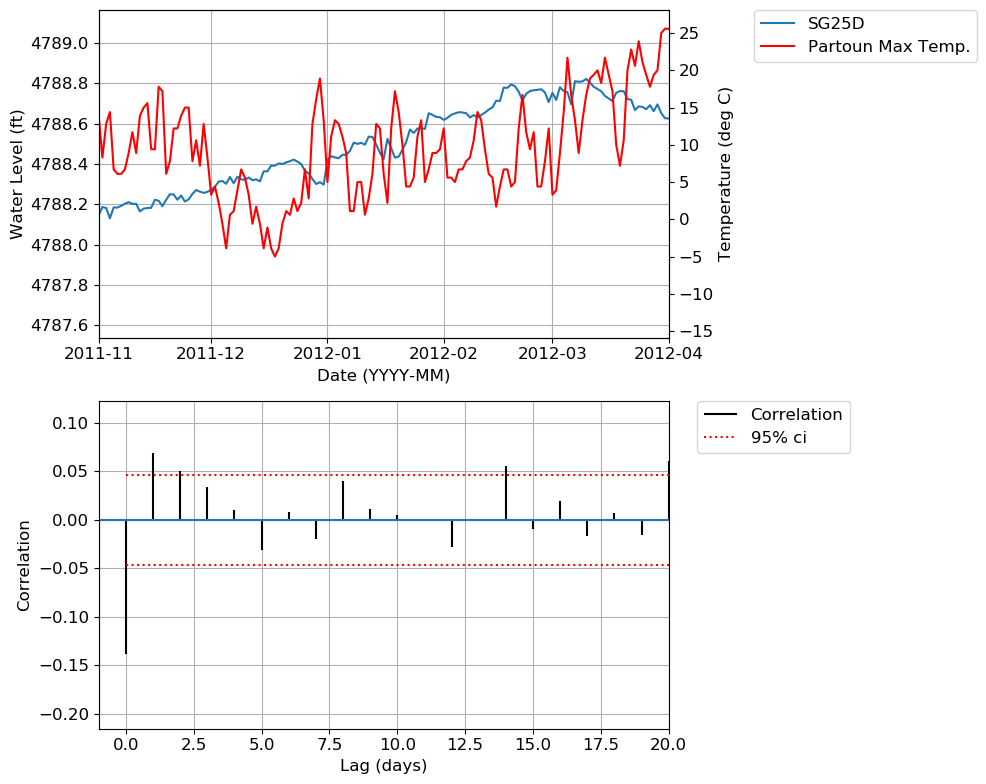

In [149]:
for col in wlClim.columns:
    if '_wle' in col:

        fig, ax = plt.subplots(2,1)
        #col = '1012_wle'
        df = wlClim.loc['2010-10-01':'2019-08-07',('partoun_maxtemp',col)].resample('1D').mean().interpolate(method='time').dropna()
        df = df[df.index.month.isin([11,12,1,2,3])]
        x = df.index
        y1 = df[col]
        y2 = df['partoun_maxtemp']

        y3 = y1.diff()[1:-1].values
        y4 = y2.diff()[1:-1].values

        ln1 = ax[0].plot(x,y1,label=col.split('_')[0])
        ax0a = ax[0].twinx()
        ln2 = ax0a.plot(x,y2,color='red',label='Partoun Max Temp.')
        ax[0].set_ylabel('Water Level (ft)')
        ax0a.set_ylabel('Temperature (deg C)')
        ax[0].set_xlim(pd.to_datetime('2011-11-01'),pd.to_datetime('2012-04-01'))
        ax[0].grid(True)
        ax[0].set_xlabel('Date (YYYY-MM)')
        
        lns = ln1+ln2
        labs = [l.get_label() for l in lns]
        ax[0].legend(lns, labs, loc='upper left',bbox_to_anchor=(1.15, 1), borderaxespad=0.)
        
        lillags = 20
        sl = 2 / np.sqrt(len(df)-lillags)
        ax[1].xcorr(y4,y3, usevlines=True, normed=True, maxlags=lillags, label='Correlation')
        ax[1].grid()
        ax[1].set_xlabel('Lag (days)')
        ax[1].set_xlim(-1,lillags)
        ax[1].hlines(sl,0,biglags,linestyles=':',color='red',label='95% ci')
        ax[1].hlines(-sl,0,biglags,linestyles=':',color='red')
        ax[1].set_ylabel('Correlation')
        ax[1].legend(loc='upper left',bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        
        plt.tight_layout()
        plt.savefig(file_place+f'temp_corr_wint_{col}.png')
        plt.savefig(file_place+f'temp_corr_wint_{col}.pdf')
        plt.savefig(file_place+f'temp_corr_wint_{col}.svg')

## Flow

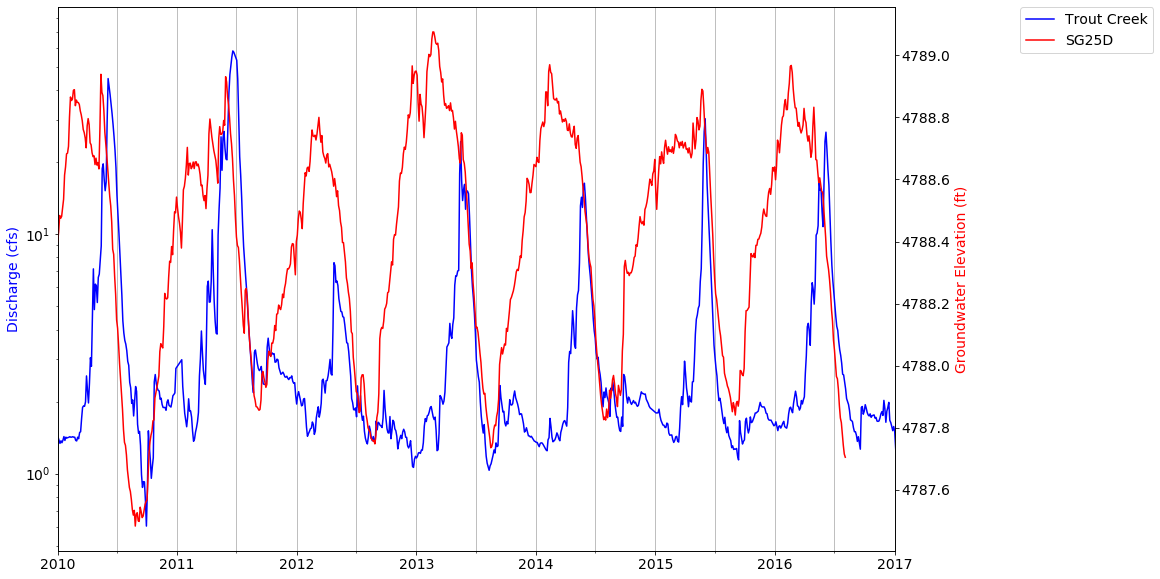

In [77]:
fig, ax = plt.subplots(1,1)

#x1 = trout_hr.index
#y1 = trout_hr['Q_cfs']
x1 = trout_hr.resample('3D').mean().index
y1 = trout_hr['Q_cfs'].resample('3D').mean()

#x2 = wls_piv.index
#y2 = wls_piv['SG25D_wle']
x2 = wls_piv.resample('3D').mean().index
y2 = wls_piv['SG25D_wle'].resample('3D').mean()

ln1 = ax.plot(x1, y1, color='blue',label='Trout Creek')
ax.set_yscale('log')
ax.set_ylabel('Discharge (cfs)',color='blue')
ax0 = ax.twinx()
ax0.set_ylabel('Groundwater Elevation (ft)', color='red')
ln2 = ax0.plot(x2, y2, color='red',label='SG25D')
lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='upper left',bbox_to_anchor=(1.15, 1), borderaxespad=0.)
ax.set_xlim('2010','2017')
minor_ticks = pd.date_range('2010','2017',freq='6MS')
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='both',axis='x')

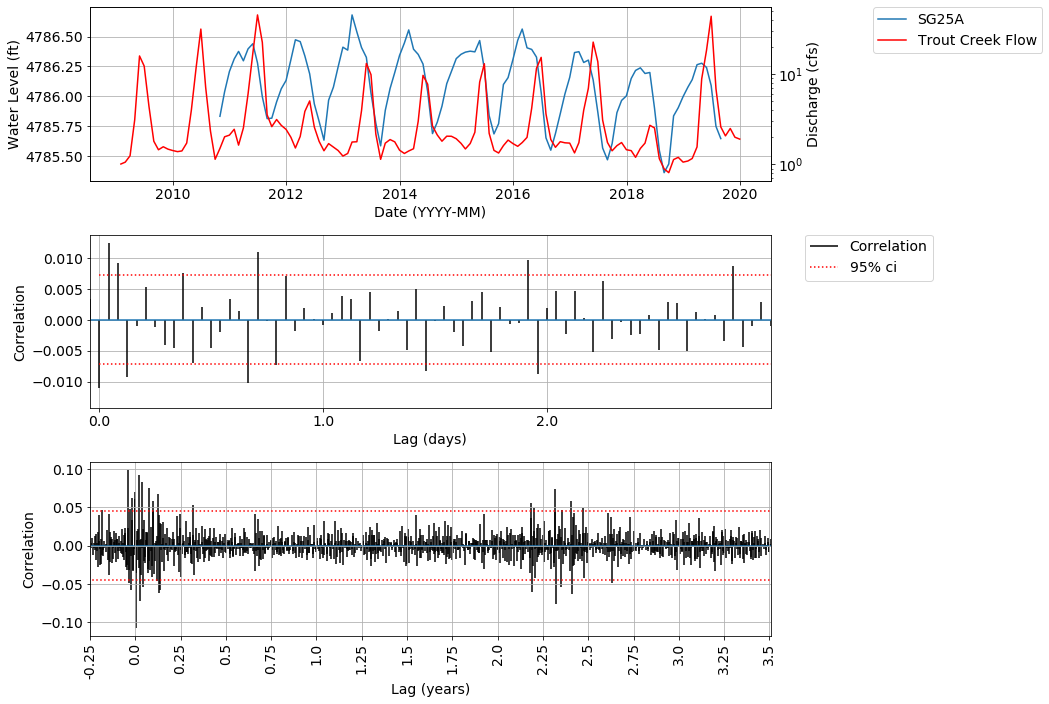

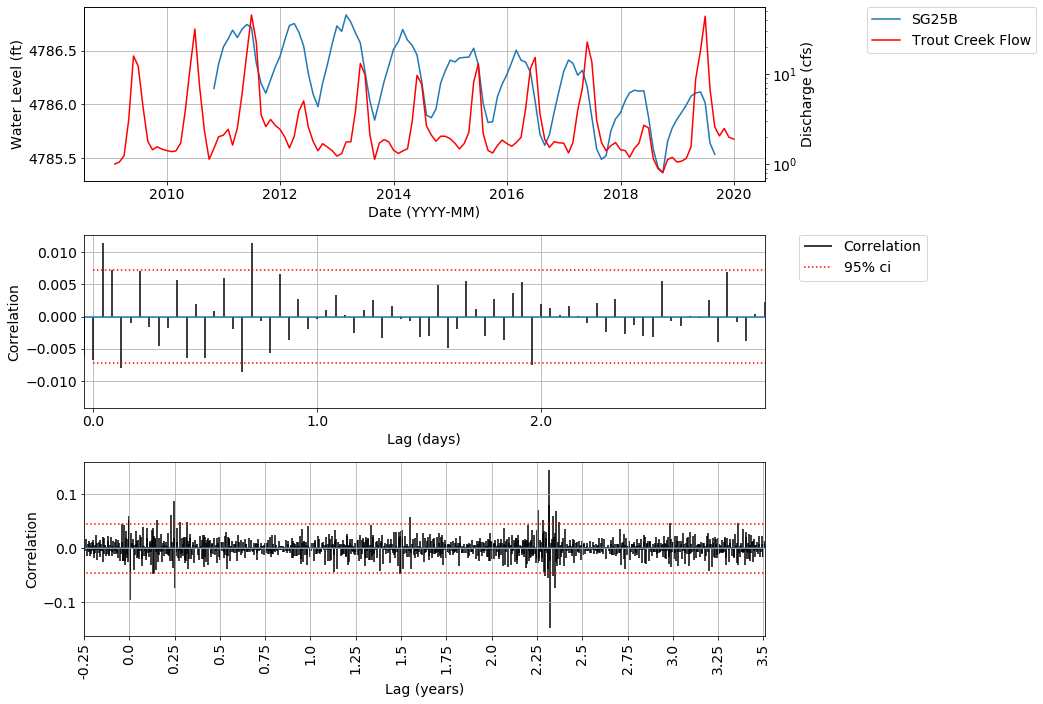

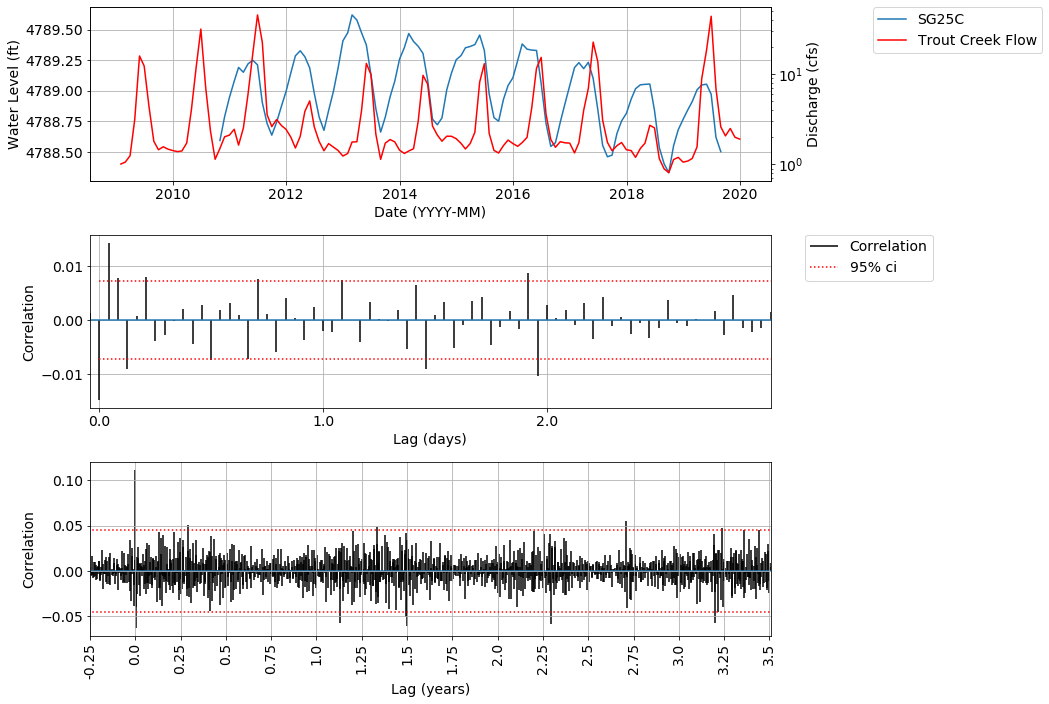

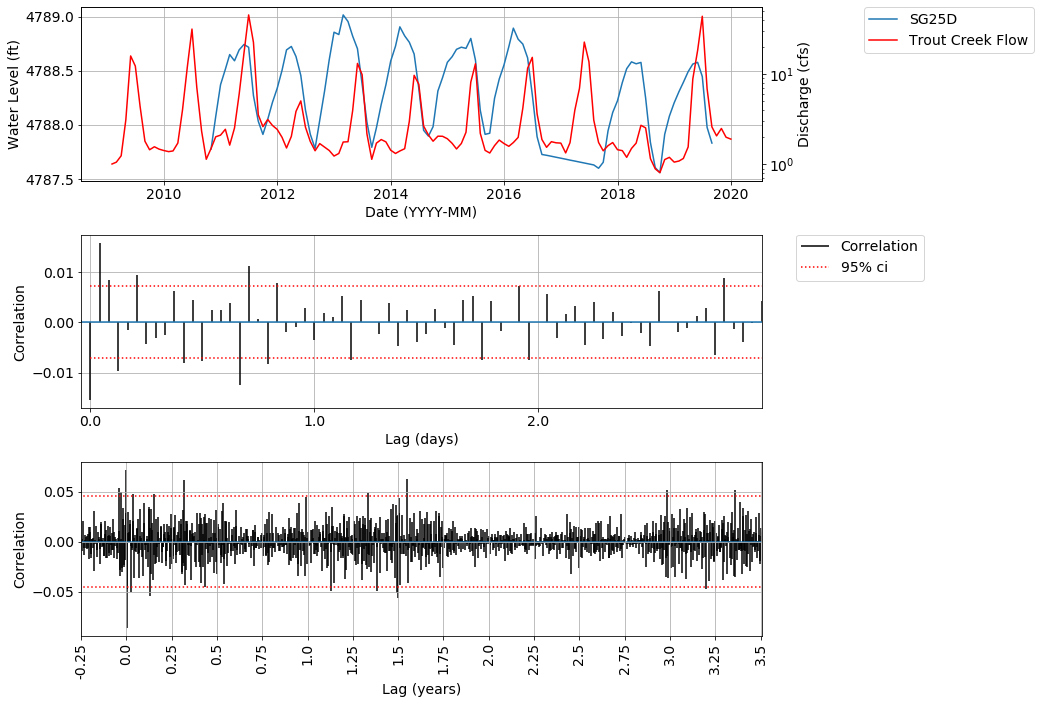

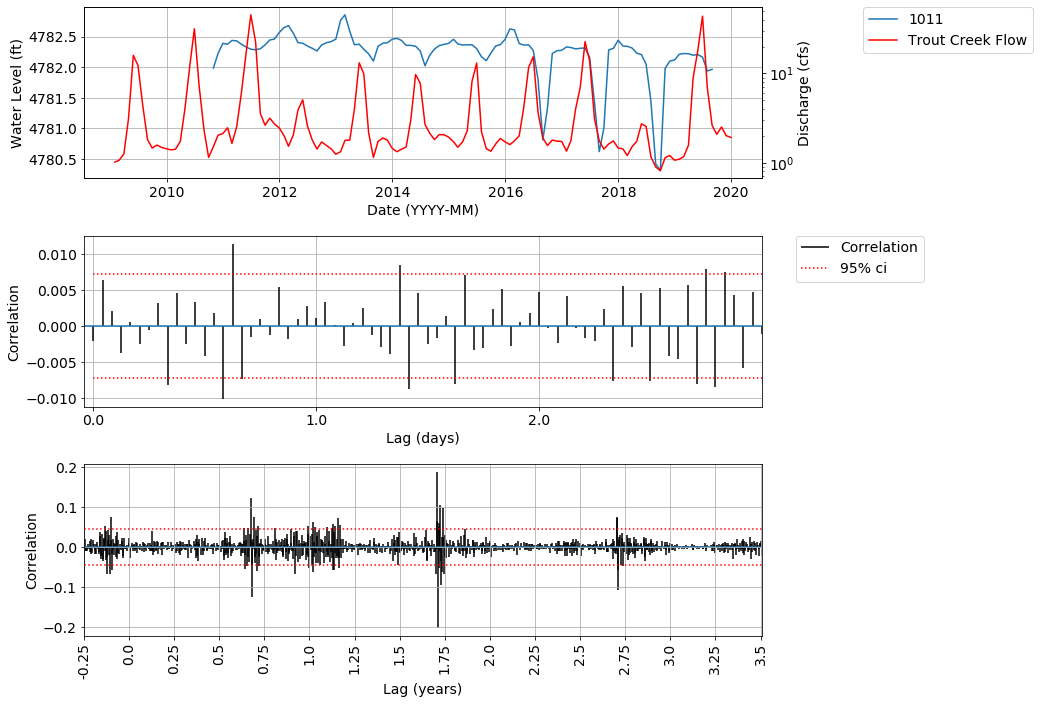

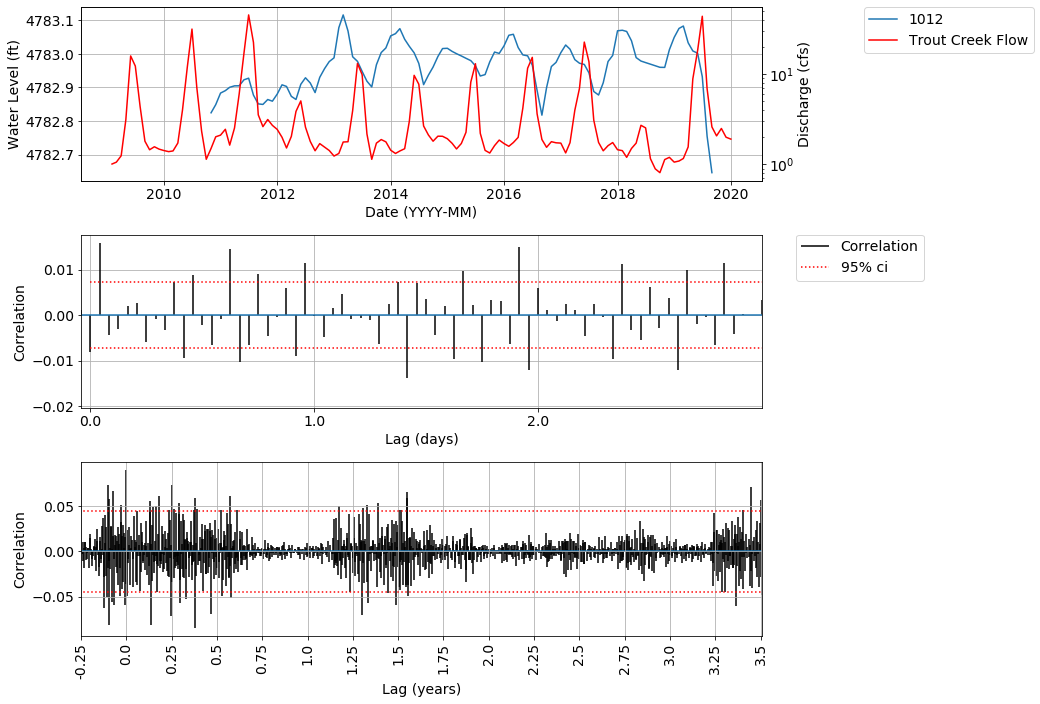

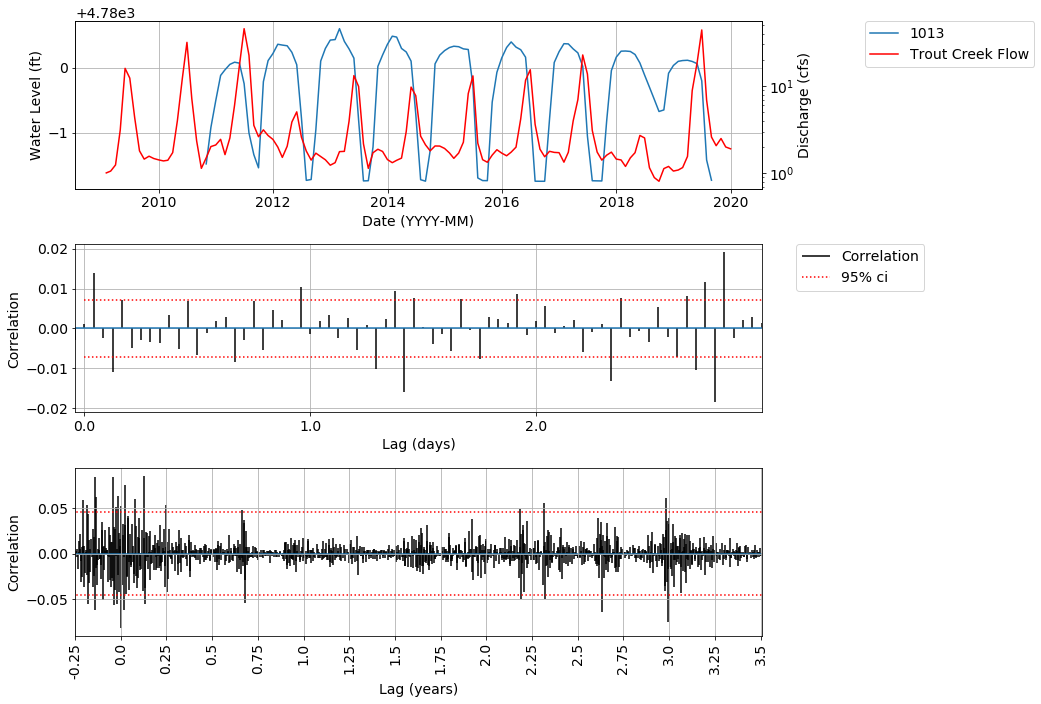

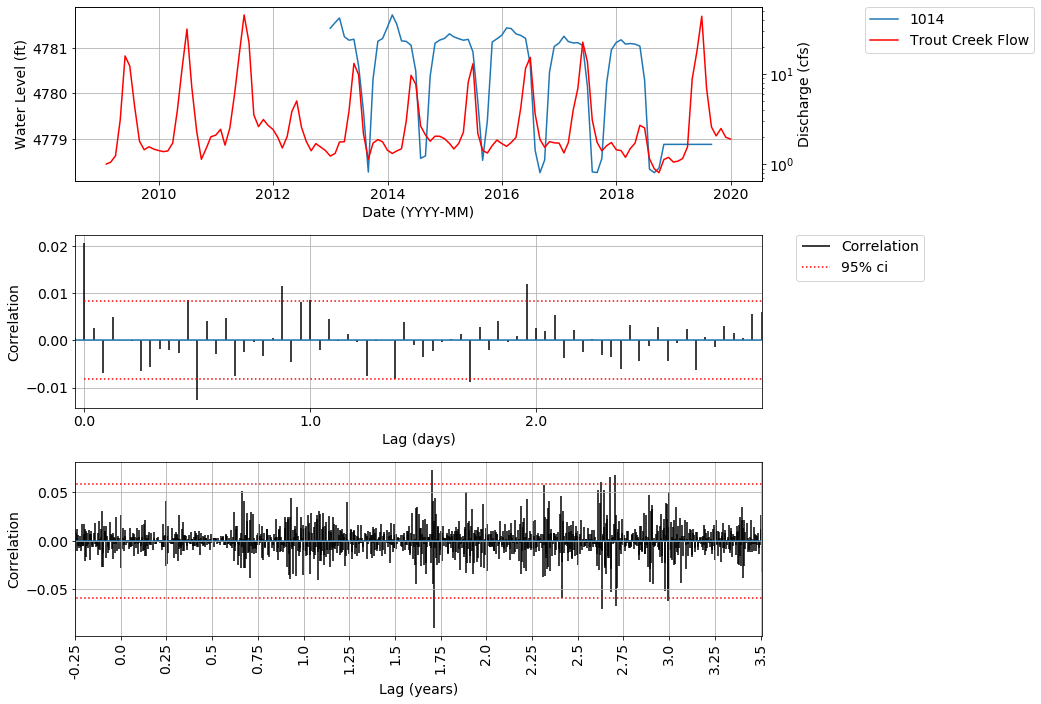

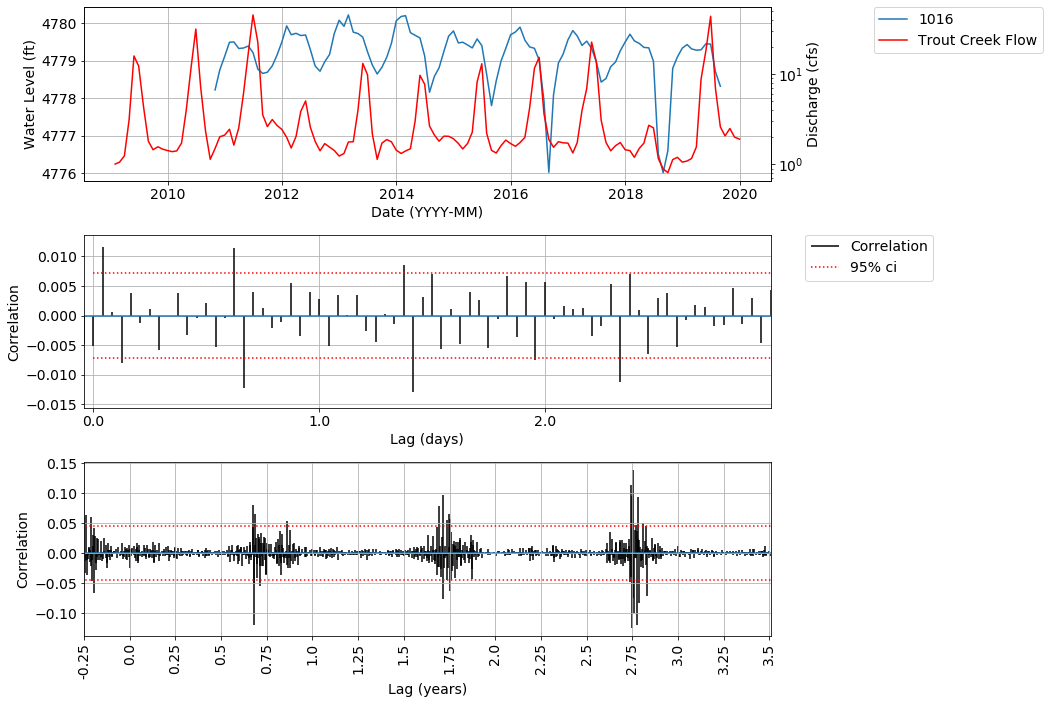

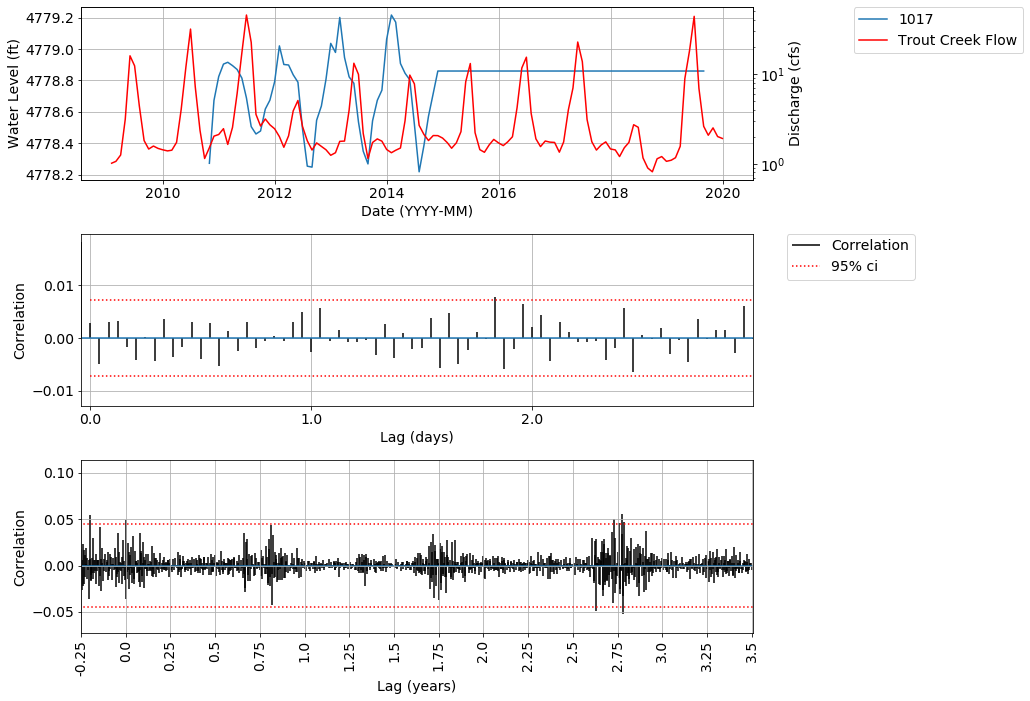

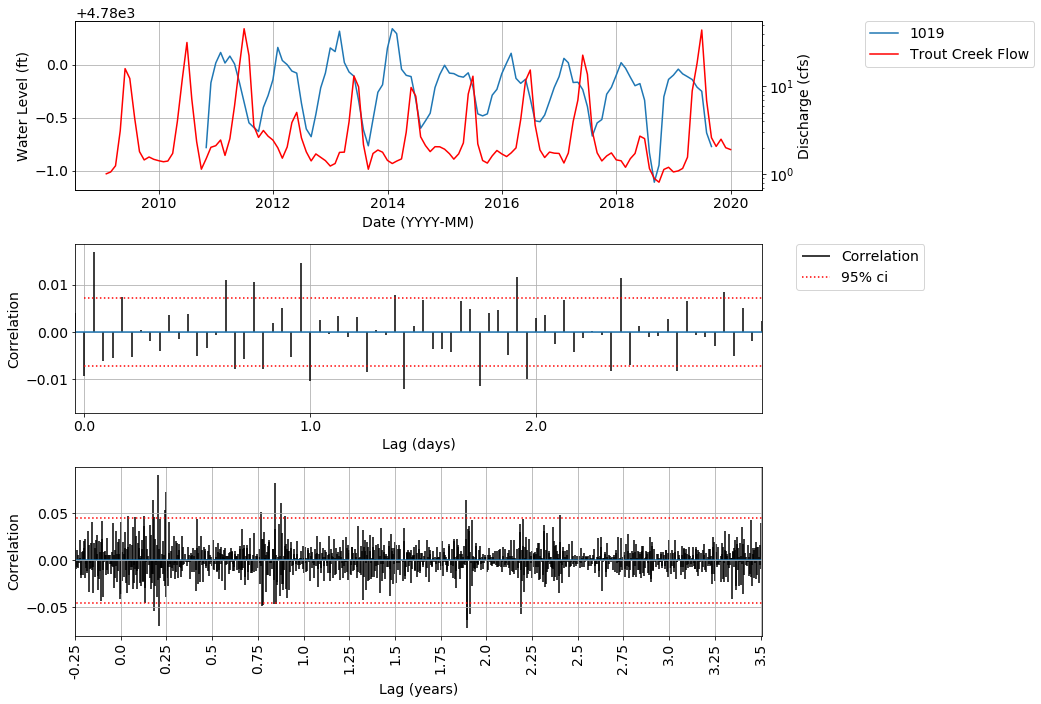

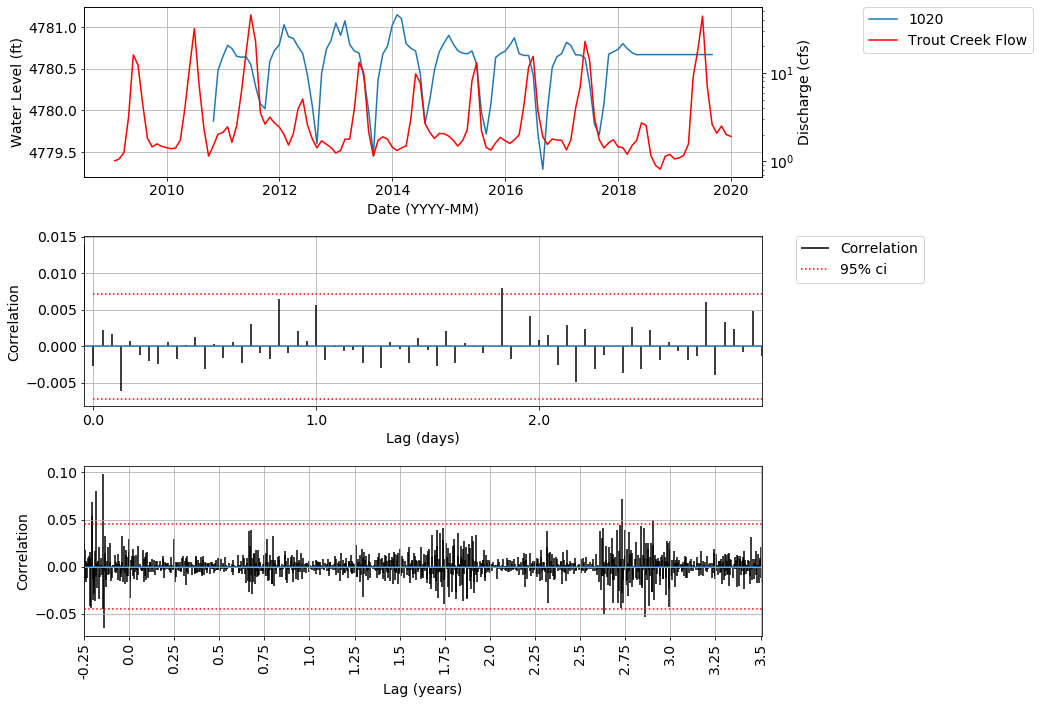

In [135]:
flowwl = pd.concat([wls_piv,trout_hr['Q_cfs']],axis=1).loc['2010-10-01':'2019-08-07']
param = 'Q_cfs'
for col in flowwl.columns:
    if '_wle' in col:

        fig, ax = plt.subplots(3,1)
        df = flowwl.loc[:,(param,col)].resample('1H').mean().interpolate(method='time').dropna()
        #df = df[df.index.month.isin([11,12,1,2,3])]
        x = df.index
        y1 = df[col]
        y2 = df[param]

        y3 = y1.diff().diff()[2:-2].values
        y4 = y2.diff().diff()[2:-2].values
        sampint = '1M'
        ln1 = ax[0].plot(df.resample(sampint).mean().index,
                         y1.resample(sampint).mean(),label=col.split('_')[0])
        ax0a = ax[0].twinx()
        ln2 = ax0a.plot(trout_hr['Q_cfs'].resample(sampint).mean().index,
                        trout_hr['Q_cfs'].resample(sampint).mean(),
                        color='red',label='Trout Creek Flow')
        ax[0].set_ylabel('Water Level (ft)')
        ax0a.set_ylabel('Discharge (cfs)')
        ax0a.set_yscale('log')
        ax[0].grid(True)
        ax[0].set_xlabel('Date (YYYY-MM)')
        lns = ln1+ln2
        labs = [l.get_label() for l in lns]
        ax[0].legend(lns, labs, loc='upper left',bbox_to_anchor=(1.15, 1), borderaxespad=0.)
        
        lillags = 3*24
        sl = 2 / np.sqrt(len(df)-lillags)
        ax[1].xcorr(y4,y3, usevlines=True, normed=True, maxlags=lillags, label='Correlation')
        ax[1].grid()
        ax[1].set_xlabel('Lag (days)')
        ax[1].set_xlim(-1,lillags)
        ax[1].hlines(sl,0,lillags,linestyles=':',color='red',label='95% ci')
        ax[1].hlines(-sl,0,lillags,linestyles=':',color='red')
        ax[1].set_xticks(np.arange(0, lillags, 24))
        ax[1].set_xticklabels(np.arange(0, lillags/24, 1))
        ax[1].set_ylabel('Correlation')
        ax[1].legend(loc='upper left',bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        
        mult = 1
        biglags = 1280*mult
        df2 = df.resample('1D').mean()
        sl2 = 2 / np.sqrt(len(df2)-biglags)
        ax[2].xcorr(df2[param].diff().diff()[2:-2].values,
                    df2[col].diff().diff()[2:-2].values,
                    usevlines=True, normed=True, 
                    maxlags=biglags,
                    zorder=0)

        ax[2].hlines(sl2,-1*biglags,biglags,linestyles=':',color='red',label='95% ci',zorder=10)
        ax[2].hlines(-sl2,-1*biglags,biglags,linestyles=':',color='red',zorder=11)
        ax[2].grid()
        ax[2].set_xlabel('Lag (years)')
        ax[2].set_xlim(-91.25*mult, biglags)
        ax[2].set_xticks(np.arange(-91.25*mult, biglags, 91.25*mult))
        ax[2].set_xticklabels(np.arange(-0.25, round(biglags/(365.25*mult)+0.25,2), 0.25),rotation=90)
        ax[2].set_ylabel('Correlation')
        
        plt.tight_layout()
        plt.savefig(file_place+f'flow_corr_{col}.png')
        plt.savefig(file_place+f'flow_corr_{col}.pdf')
        plt.savefig(file_place+f'flow_corr_{col}.svg')

In [102]:
365.25*3.5

1278.375

## Groundwater Levels

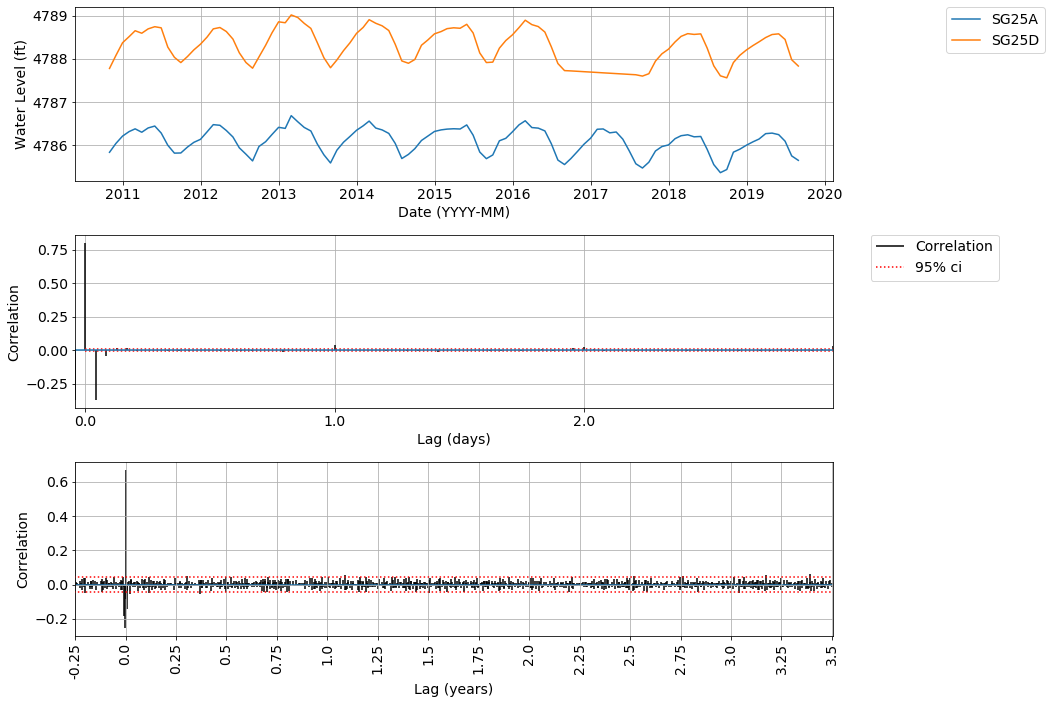

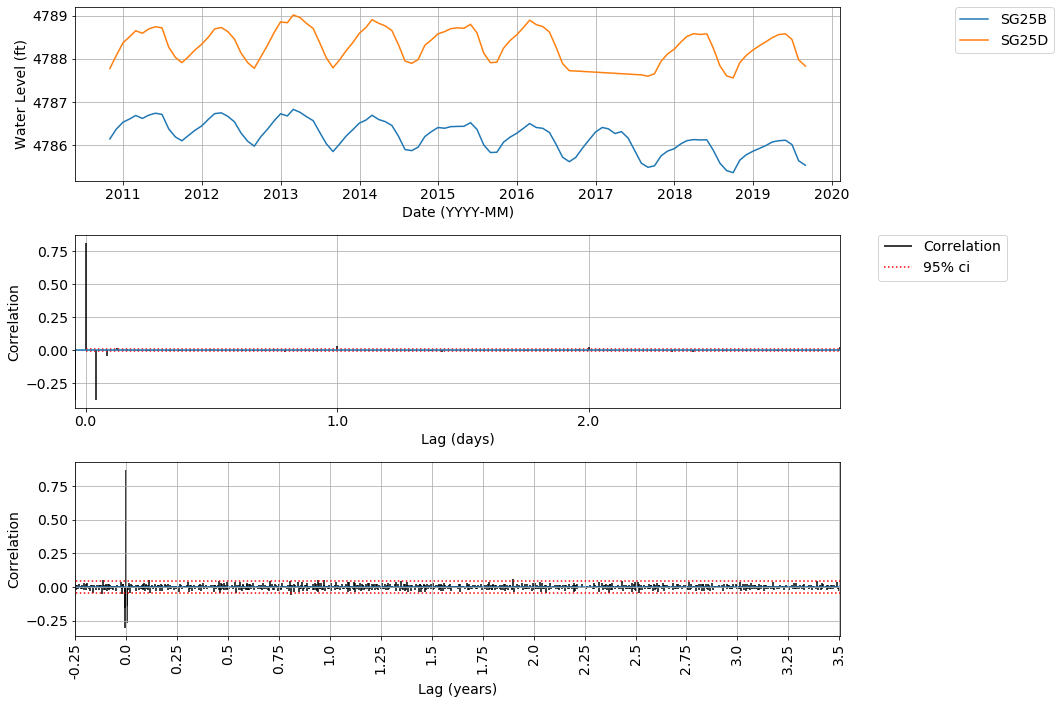

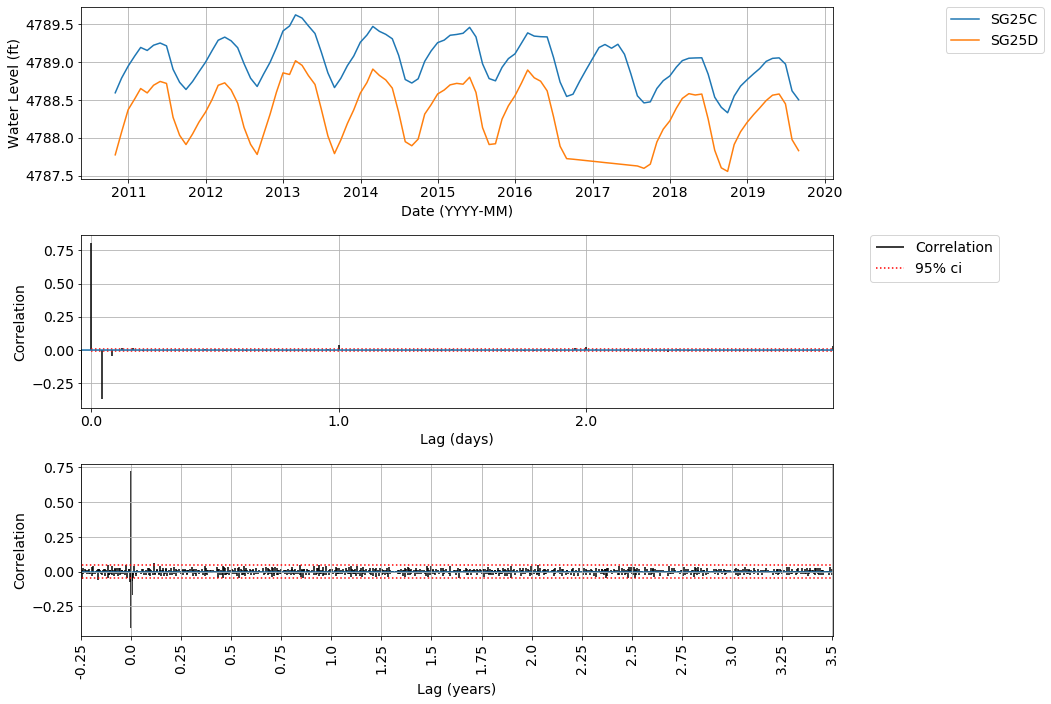

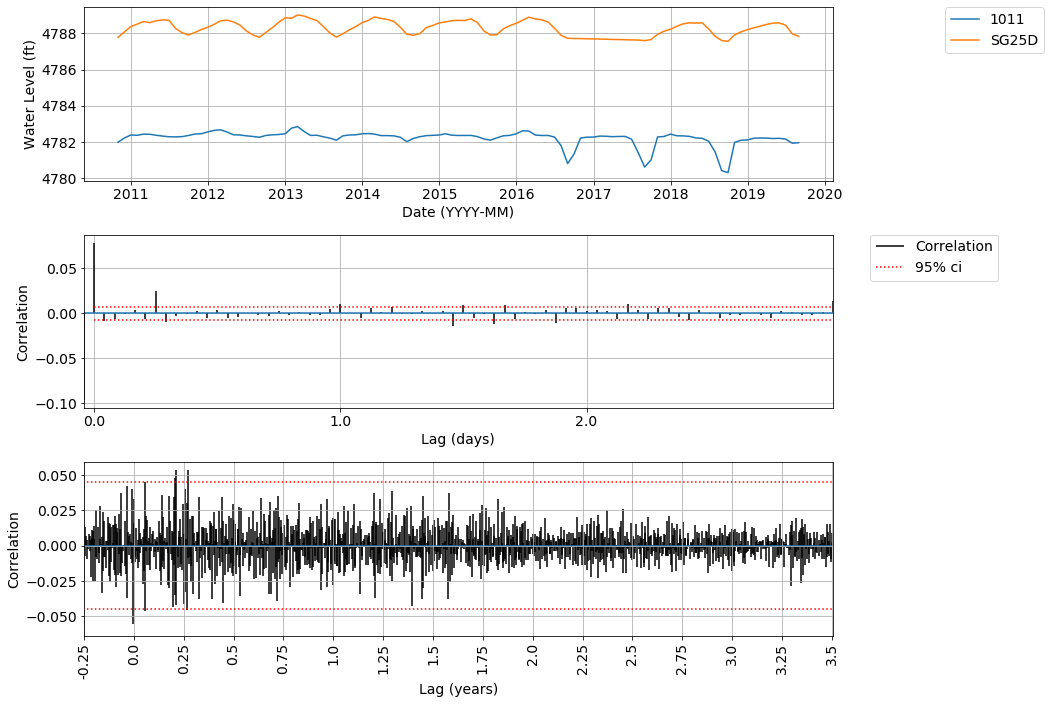

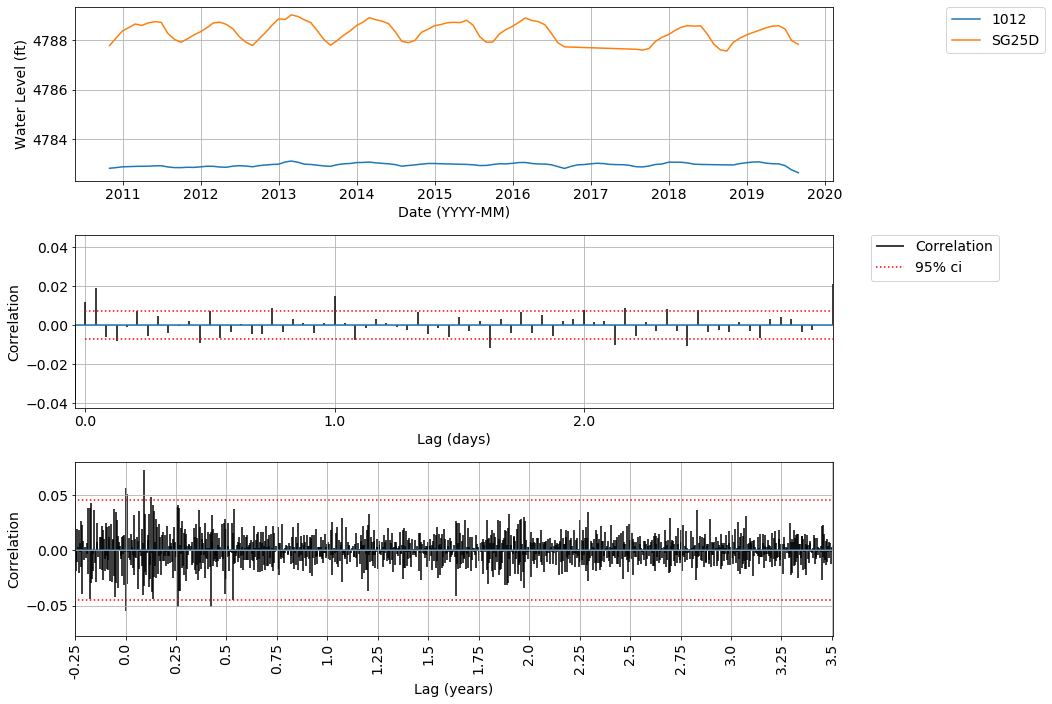

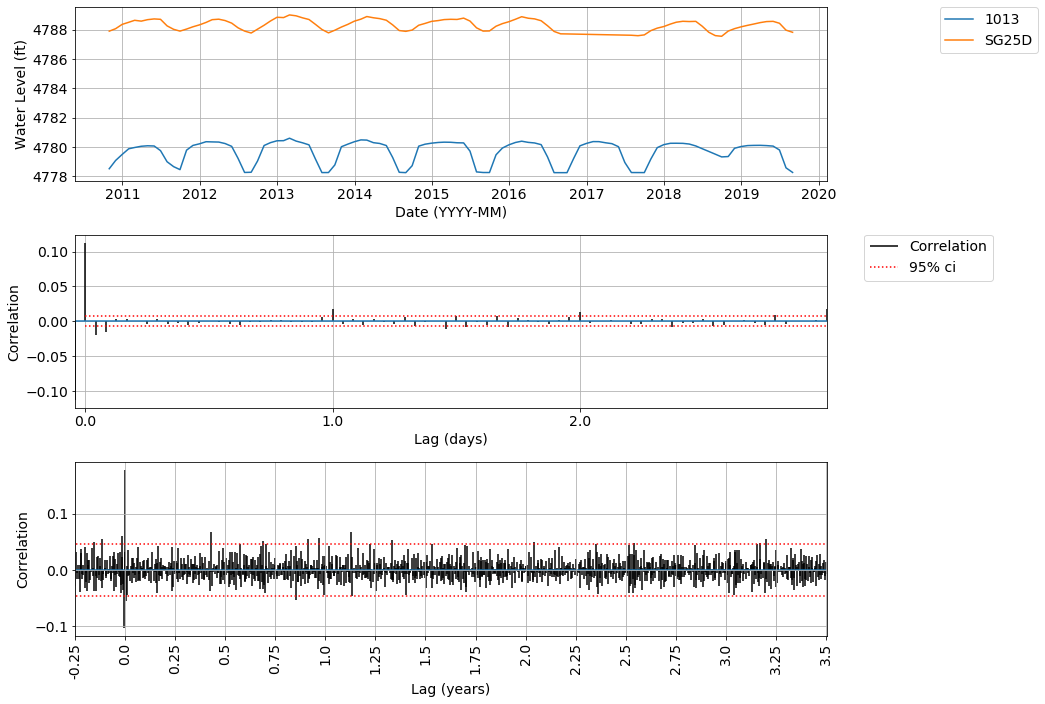

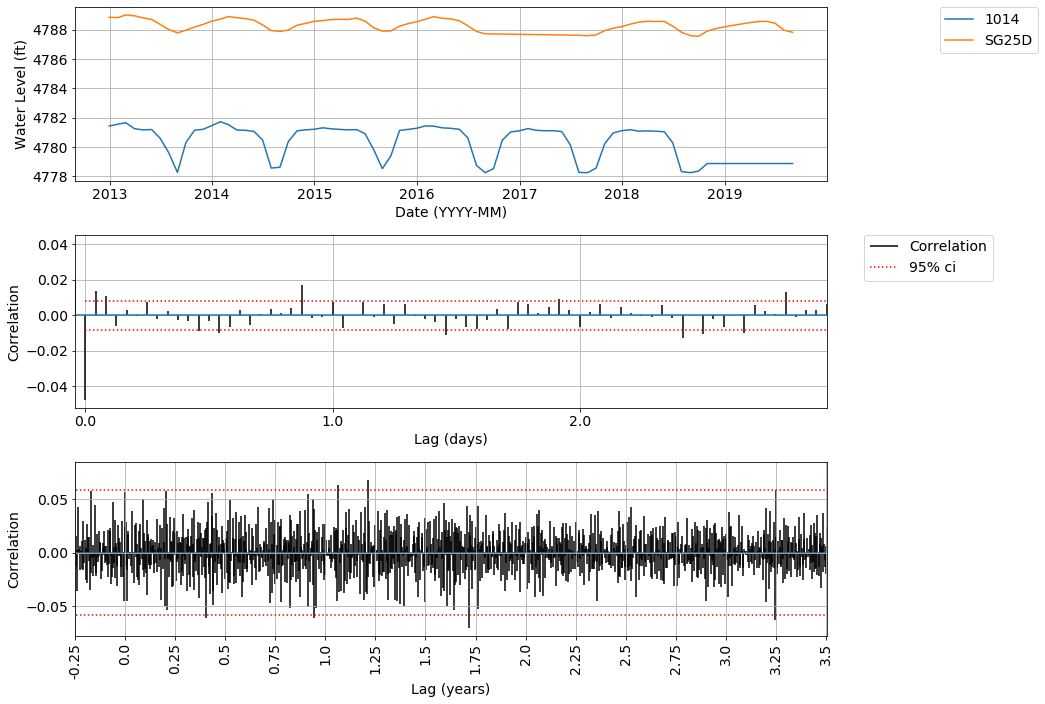

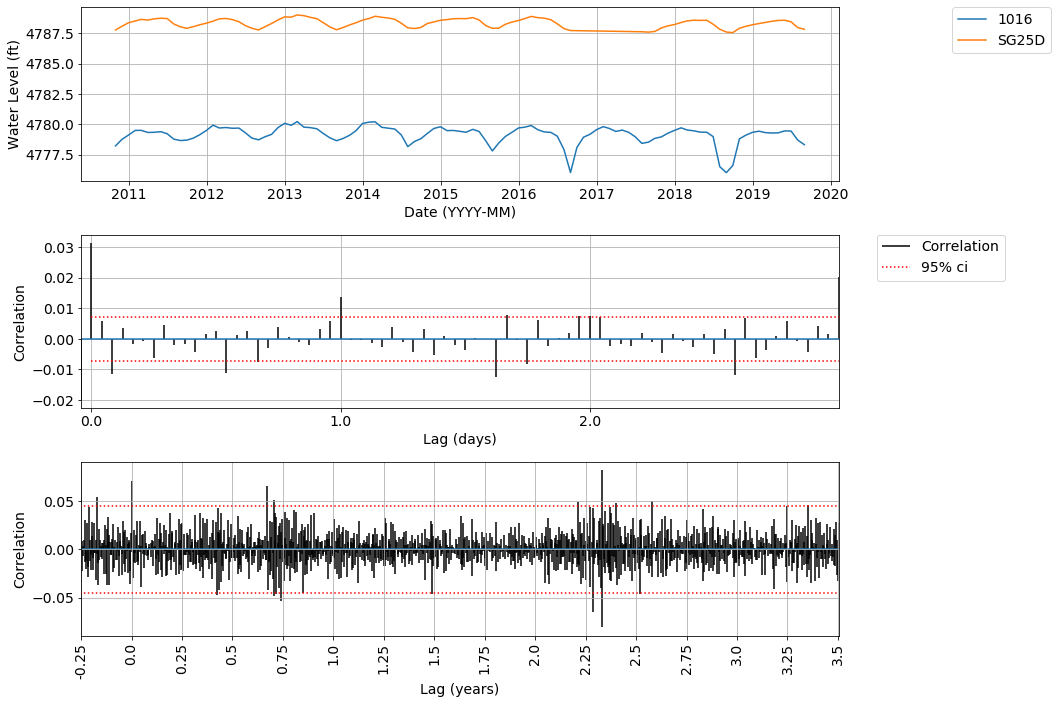

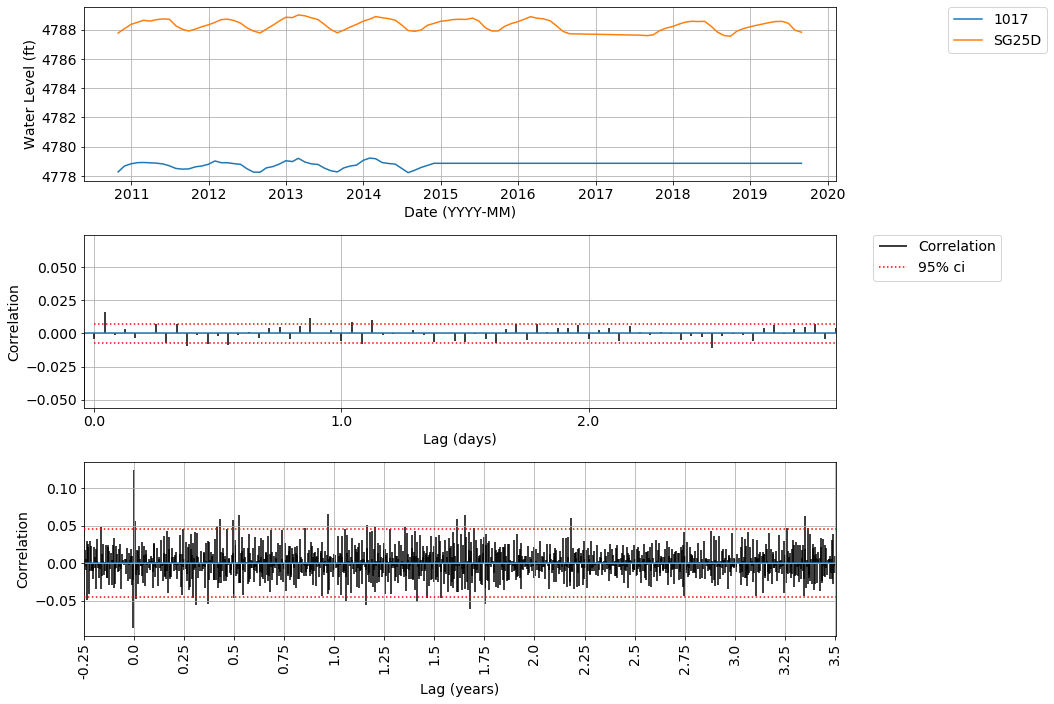

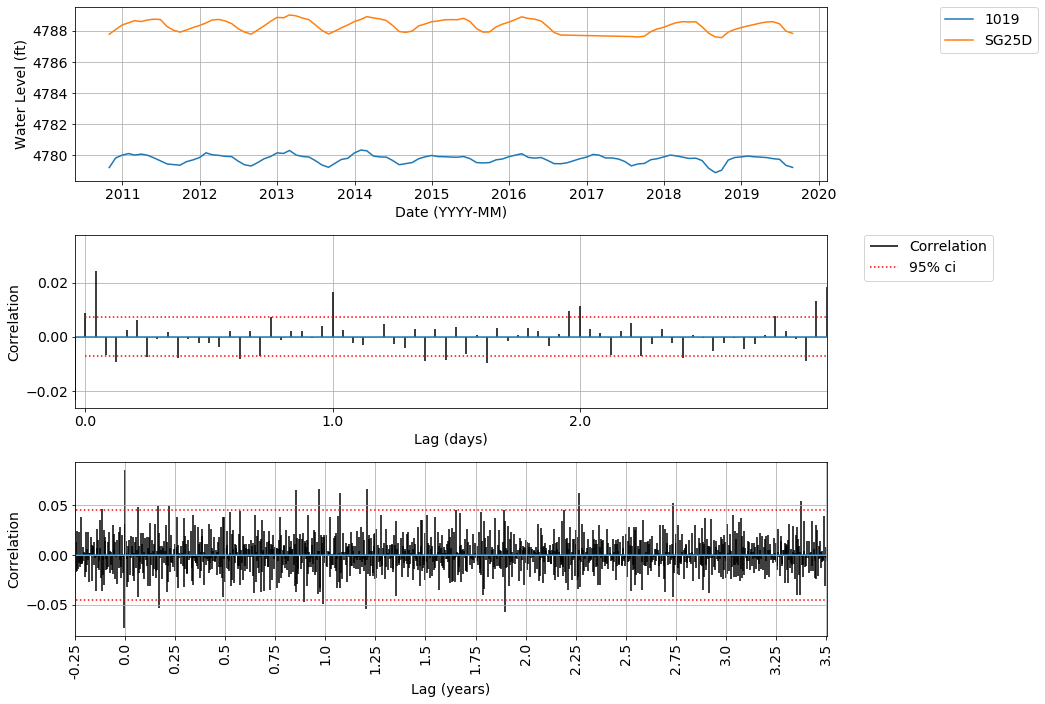

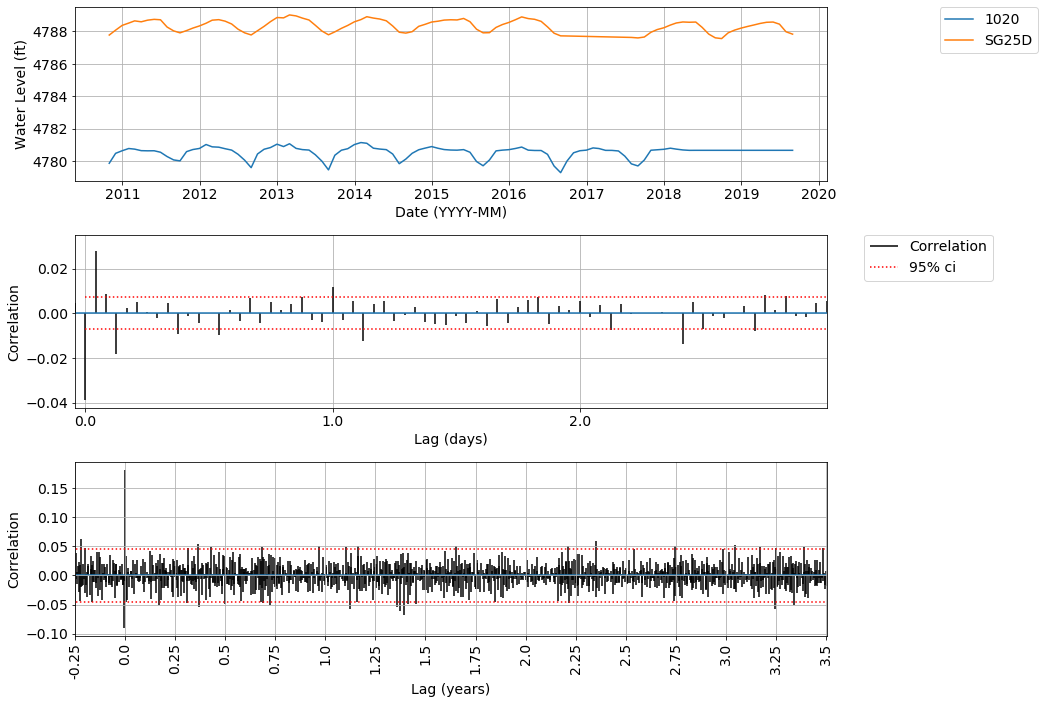

In [134]:
param = 'SG25D_wle'
for col in wls_piv.columns:
    if '_wle' in col and col != param:

        fig, ax = plt.subplots(3,1)
        df = wls_piv.loc['2010-10-01':'2019-08-07',(param,col)].resample('1H').mean().interpolate(method='time').dropna()
        #df = df[df.index.month.isin([11,12,1,2,3])]
        x = df.index
        y1 = df[col]
        y2 = df[param]

        y3 = y1.diff().diff()[2:-2].values
        y4 = y2.diff().diff()[2:-2].values

        sampint = '1M'
        ax[0].plot(df.resample(sampint).mean().index, y1.resample(sampint).mean(), label=col.split('_')[0])
        ax[0].plot(df.resample(sampint).mean().index, y2.resample(sampint).mean(), label=param.split('_')[0])
        ax[0].set_ylabel('Water Level (ft)')
        #begdate = pd.to_datetime('2011-04-01')
        #enddate = pd.to_datetime('2011-10-01')
        #ax[0].set_xlim(begdate,enddate)
        ax[0].grid(True)
        ax[0].set_xlabel('Date (YYYY-MM)')
        ax[0].legend(loc='upper left',bbox_to_anchor=(1.15, 1), borderaxespad=0.)
                        
        lillags = 3*24
        sl = 2 / np.sqrt(len(y4)-lillags)
        ax[1].xcorr(y4,y3, usevlines=True, normed=True, maxlags=lillags, label='Correlation')
        ax[1].grid()
        ax[1].set_xlabel('Lag (days)')
        ax[1].set_xlim(-1,lillags)
        ax[1].hlines(sl,0,lillags,linestyles=':',color='red',label='95% ci')
        ax[1].hlines(-sl,0,lillags,linestyles=':',color='red')
        ax[1].set_xticks(np.arange(0, lillags, 24))
        ax[1].set_xticklabels(np.arange(0, lillags/24, 1))
        ax[1].set_ylabel('Correlation')
        ax[1].legend(loc='upper left',bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        
        mult = 1
        biglags = 1279*mult
        df2 = df.resample('1D').mean()
        sl2 = 2 / np.sqrt(len(df2) - biglags)
        ax[2].xcorr(df2[param].diff().diff()[2:-2].values,
                    df2[col].diff().diff()[2:-2].values,
                    usevlines=True, normed=True, 
                    maxlags=biglags,
                    zorder=0)

        ax[2].hlines(sl2,-1*biglags,biglags,linestyles=':',color='red',label='95% ci',zorder=10)
        ax[2].hlines(-sl2,-1*biglags,biglags,linestyles=':',color='red',zorder=11)
        ax[2].grid()
        ax[2].set_xlabel('Lag (years)')
        ax[2].set_xlim(-91.25*mult, biglags)
        ax[2].set_xticks(np.arange(-91.25*mult, biglags, 91.25*mult))
        ax[2].set_xticklabels(np.arange(-0.25, round(biglags/(365.25*mult)+0.25,2), 0.25),rotation=90)
        ax[2].set_ylabel('Correlation')
        
        
        plt.tight_layout()
        plt.savefig(file_place+f'gw_corr_{col}.png')
        plt.savefig(file_place+f'gw_corr_{col}.pdf')
        plt.savefig(file_place+f'gw_corr_{col}.svg')

# Correlation Matrices

## Regional Climate

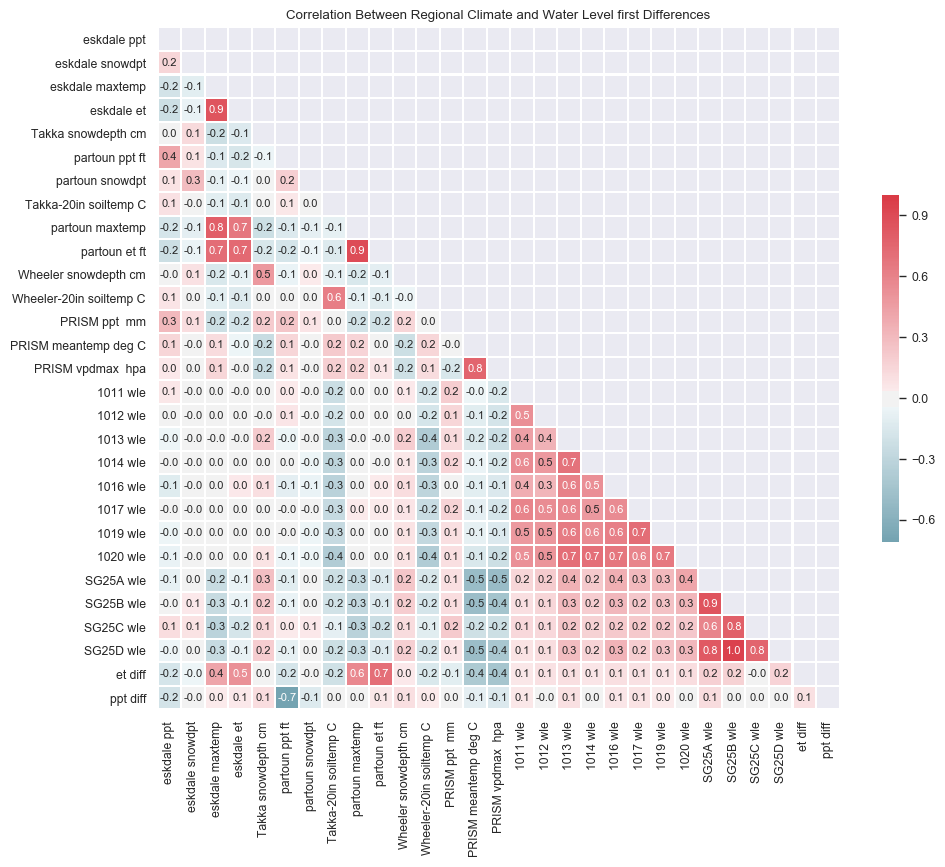

In [319]:
import pandas as pd
import seaborn as sns
sns.set(context='paper')

df = wlClim

for col in df.columns:
    df = df.rename(columns={col:col.replace('_',' ')})

corr = df.diff().corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the full plot
sns.heatmap(corr, center=0, cmap=cmap, mask=mask,square=True,
               linewidths=.75, annot=True, fmt="0.1f",annot_kws={'size':8},
            cbar_kws={"shrink": .5})

plt.title('Correlation Between Regional Climate and Water Level first Differences')

plt.savefig(file_place+'correlation_matrix_climate_1stdiff.pdf')
plt.savefig(file_place+'correlation_matrix_climate_1stdiff.png')
plt.savefig(file_place+'correlation_matrix_climate_1stdiff.svg')

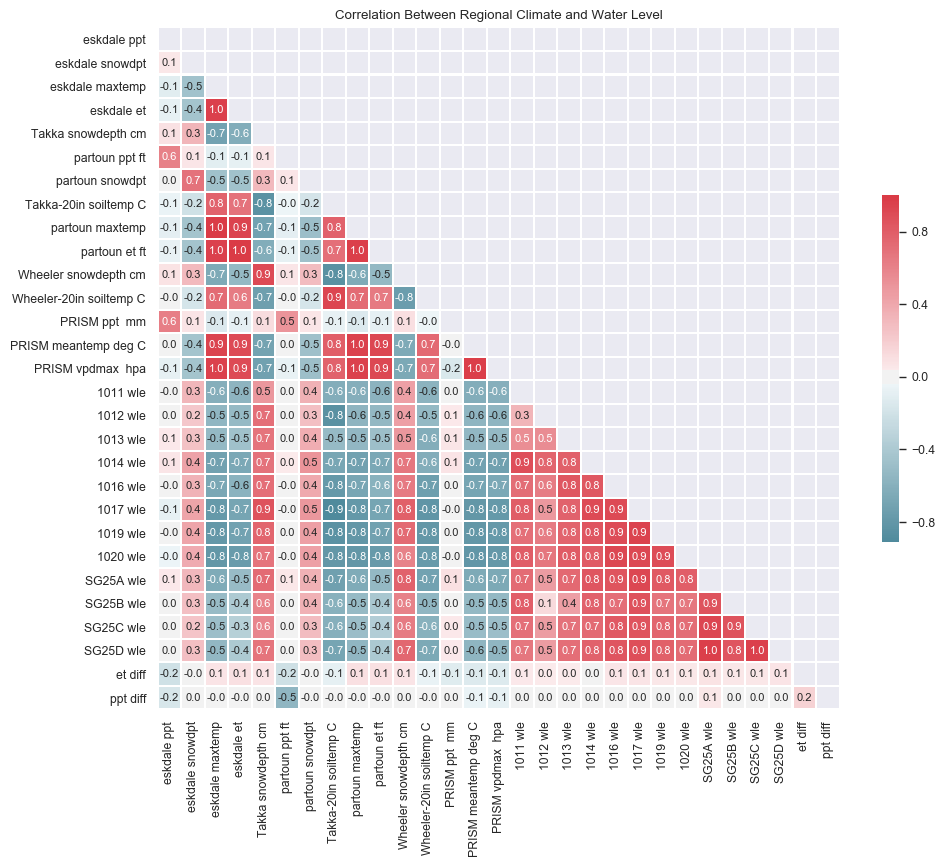

In [321]:
import pandas as pd
import seaborn as sns
sns.set()
sns.set(context='paper')
df = wlClim

for col in df.columns:
    df = df.rename(columns={col:col.replace('_',' ')})

corr = df.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the full plot
sns.heatmap(corr, center=0, cmap=cmap, mask=mask,square=True,
               linewidths=.75, annot=True, fmt="0.1f",annot_kws={'size':8},
            cbar_kws={"shrink": .5})

plt.title('Correlation Between Regional Climate and Water Level')

plt.savefig(file_place+'correlation_matrix_climate.pdf')
plt.savefig(file_place+'correlation_matrix_climate.png')
plt.savefig(file_place+'correlation_matrix_climate.svg')

## Local Climate

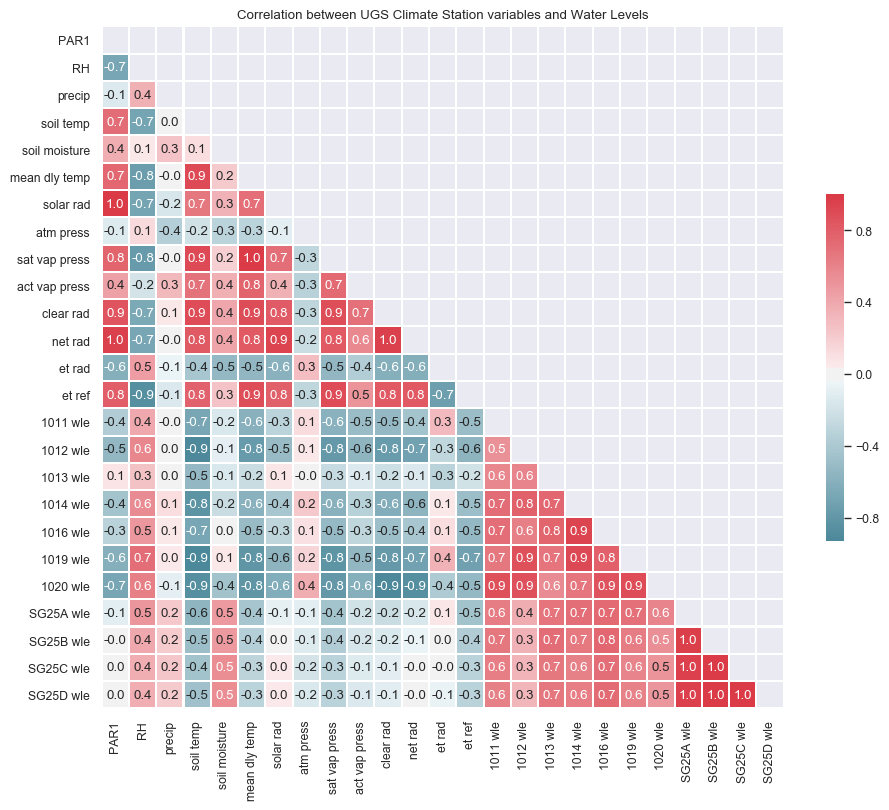

In [323]:
localclim = pd.concat([ugs_clim_raw_dly,justwl],axis=1)
localclim = localclim.dropna(subset=ugs_clim_raw_dly.columns, how='all').dropna(how='all',axis=1)


droplist = ['Wind_Speed','Gust_Speed','extra_rad','declin','julian', 'Wind_Direction','rns','net_out_rad',
            'net_rad_g','et_wind','SolarRadiation1','SolarRadiation2','BaroPressure','u2_wind','esslope',
            'psi','psy_const','numb','air_temp','TT','delta','dr','sunst_hr','min_dly_temp','air_temp_c',
            'tmean','max_dly_temp','DewPt','PAR2']
localclim = localclim.drop(droplist,axis=1)

df = localclim 

for col in df.columns:
    df = df.rename(columns={col:col.replace('_',' ')})

corr = df.corr(method='spearman')



# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the full plot
sns.heatmap(corr, center=0, cmap=cmap, mask=mask,square=True,
               linewidths=.75, annot=True, fmt="0.1f",
            cbar_kws={"shrink": .5})
plt.title('Correlation between UGS Climate Station variables and Water Levels')
plt.savefig(file_place+'correlation_matrix_ugs_station.pdf')
plt.savefig(file_place+'correlation_matrix_ugs_station.png')
plt.savefig(file_place+'correlation_matrix_ugs_station.svg')

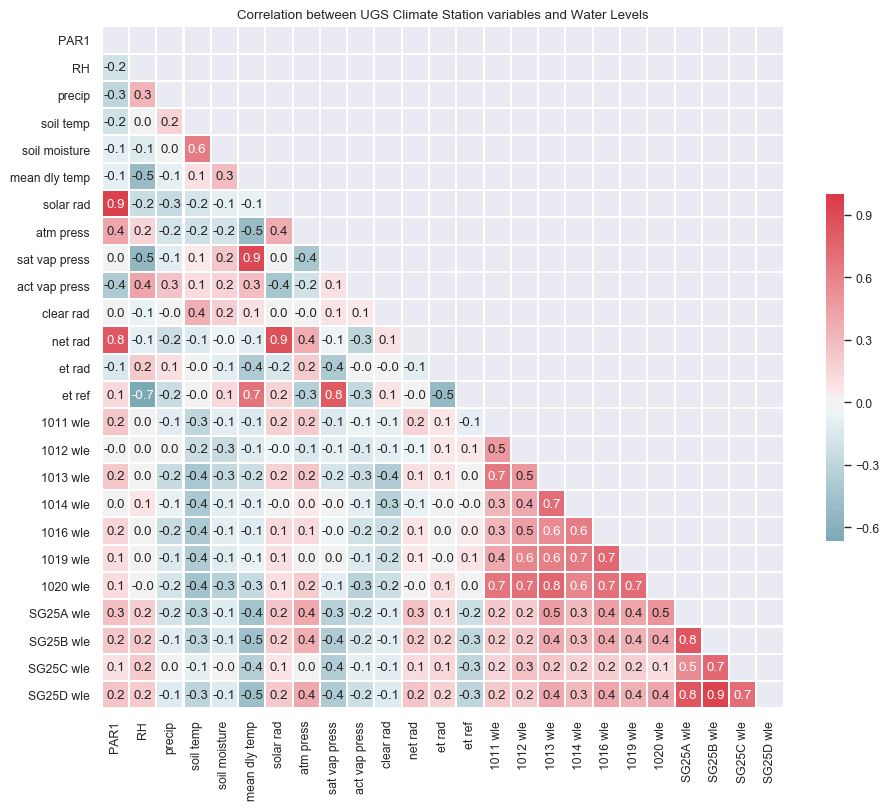

In [324]:
localclim = pd.concat([ugs_clim_raw_dly,justwl],axis=1)
localclim = localclim.dropna(subset=ugs_clim_raw_dly.columns, how='all').dropna(how='all',axis=1)


droplist = ['Wind_Speed','Gust_Speed','extra_rad','declin','julian', 'Wind_Direction','rns','net_out_rad',
            'net_rad_g','et_wind','SolarRadiation1','SolarRadiation2','BaroPressure','u2_wind','esslope',
            'psi','psy_const','numb','air_temp','TT','delta','dr','sunst_hr','min_dly_temp','air_temp_c',
            'tmean','max_dly_temp','DewPt','PAR2']
localclim = localclim.drop(droplist,axis=1)

df = localclim 

for col in df.columns:
    df = df.rename(columns={col:col.replace('_',' ')})

corr = df.diff().corr(method='spearman')



# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the full plot
sns.heatmap(corr, center=0, cmap=cmap, mask=mask,square=True,
               linewidths=.75, annot=True, fmt="0.1f",
            cbar_kws={"shrink": .5})
plt.title('Correlation between UGS Climate Station variables and Water Levels')
plt.savefig(file_place+'correlation_matrix_ugs_station_1st_diff.pdf')
plt.savefig(file_place+'correlation_matrix_ugs_station_1st_diff.png')
plt.savefig(file_place+'correlation_matrix_ugs_station_1st_diff.svg')